![title](notebook_images/logo.png)

# Biometrics System Concepts
## Assignment 3: Face Recognition
<b>Name</b>: Joe |
<b>Student-nr</b>: KD6-3.7 |
<b>Date</b>: July 1, 2049
---
Facial biometrics is among the most common biometric benchmarks. That is due to the easy deployment and implementation of such a system and the lack of requirement of physical interaction by the end-user. The top three application categories where facial recognition are mostly used are: 
* Security - law enforcement: e.g. to find missing children/disoriented adults, or to identify and track criminals  
* Health care: e.g. for detecting genetic diseases, pain management or monitoring response to medication. 
* Banking and retails: Since the beginning of the digital revolution, facial recognition has been picking up prominence over touch- and type-based interactions because of the convenience it offers without settling on the security of transactions. Facial Recognition softwares for banking usually have a liveness detection which keeps hackers from utilizing an image of the user for impersonation purposes. 

Any facial recognition system requires the implementation of the following steps:
<pre>
1. Face detection, to detect faces from a given image.
2. Feature extraction, to extract feature vector descriptors from the raw face image.
3. Face matching process, for verification or identification purposes.
</pre>

In this assignment, you will implement, test and report about a face recognition system based on Principal Components Analysis (Eigenfaces), Linear Discriminant Analysis (Fisherfaces), Local Binary Pattern (LBP) and deep learning. The first three procedures are representative of old-school computer vision techniques that are still in use and retain their merits. All four generated feature vector descriptors can be compared for verification/identification.

This document is structured as follows:
* [Ethics](#Ethics)
* [Importing and installing packages](#Importing-and-installing-packages)
* [I. Loading data](#I.-Loading-data)
    * Read caltech dataset
    * Inspect some images   
    
* [II. Face detection](#II.-Face-detection)
    * Detect faces
    * Print statistics of data
    * Visualise some faces
    
* [III. Feature-extraction](#III.-Feature-extraction)
    * Eigenfaces for face recognition
    * Fisherfaces for face recognition
    * LBP for face recognition
    * Deep metric learning
        
* [IV. Distance-based and classification-based scoring](#IV.-Distance-based-and-classification-based-scoring)
* [V. Evaluation](#V.-Evaluation)
    * Validation as verification system
    * Validation as identification system
    
* [VI. Tasks](#VI.-Tasks)
    * Mandatory tasks
    * Tasks of choice


** Note 1: In case you find yourself needing extra computational power you can make use of [google colab](https://colab.research.google.com/). However, implementing overly complicated routines is discouraged. **

**Note 2: large parts of this notebook are based on the [PyImageSearch Gurus Course on Computer Vision](https://www.pyimagesearch.com/pyimagesearch-gurus/) by Adrian Rosebrock.**

## Ethics
The ethical and societal challenge posed by data protection is radically affected by the use of facial recognition technologies.

In Europe and the UK, the [General Data Protection Regulation](https://www.thalesgroup.com/en/markets/digital-identity-and-security/government/biometrics/biometric-data) (GDPR) provides a rigorous framework for these practices.

Any investigations into a citizen's private life or business travel habits are out of the question, and any such invasions of privacy carry severe penalties. 

Applicable from May 2018, the GDPR supports the principle of a harmonized European framework, in particular protecting the right to be forgotten and the giving of consent through clear affirmative action.






## Importing and installing packages
Note: this exercise makes use of keras, which is now part of TensorFlow 2.0. It is easy to install using pip, have a look at the [installation guide](https://www.tensorflow.org/install) for more information. Note that you need Python Version 3.5 to 3.7 for this to run (not lower, not higher).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import cv2
import os
import attr
from pathlib import Path
from icecream import ic

from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
%matplotlib inline

# the following package contains some handy routines for image manipulation
# they have been developed by Adrian Rosenbrock
# simply install this package in your environment using "conda install imutils"
# see https://www.pyimagesearch.com/opencv-tutorials-resources-guides/ for further info
import imutils
from sklearn.metrics import average_precision_score
from sklearn.datasets import fetch_olivetti_faces, fetch_lfw_people
from sklearn.utils import Bunch
from sklearn.preprocessing import LabelEncoder

# To visualize your model structure:
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from scipy.spatial.distance import euclidean
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import src.metrics as metrics
import src.utils as utils
from src.descriptor import FacialDescriptor, FeatureDescriptor
from src.dataprocessing import DataPreProcessor

# the following packages are imported when needed throughout this notebook, 
# we are only listing them here so that you can install all necessary packages upfront.
# sklearn
# enum
# scipy
# tensorflow.keras

In [3]:
# split data for training and testing
holdout_split = lambda X,y: train_test_split(X, y, test_size=.25, shuffle = True, stratify = y, random_state = 22)

## I. Loading data

[From OpenCV Docs](https://docs.opencv.org/3.4/da/d60/tutorial_face_main.html):

In order to test face recognition systems, we need databases of labeled face images. You can either create your own dataset (but that takes time) or, better, start with one of the available face databases, http://face-rec.org/databases/ gives you an up-to-date overview. Some interesting databases are:

* [AT&T Facedatabase](https://cam-orl.co.uk/facedatabase.html). Quoted from http://face-rec.org):
> The AT&T Facedatabase, sometimes also referred to as ORL (Olivetti Research Lab) Database of Faces or Olivetti faces, contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement).The AT&T Facedatabase is good for initial tests, but it's a fairly easy database. The Eigenfaces method already has a 97% recognition rate on it, so you won't see any great improvements with other algorithms.

This database can be accessed in a straightforward way through the [sklearn.datasets.fetch_olivetti_faces](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html#sklearn.datasets.fetch_olivetti_faces) module. 
A preview of this database can be seen [here](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/) 

* [The CALTECH Faces dataset](http://www.vision.caltech.edu/html-files/archive.html) is a popular benchmark dataset for face recognition algorithms. Overall, the dataset consists of 450 images of approximately 27 unique people. Each subject was captured under various lighting conditions, background scenes, and facial expressions. Furthermore, bounding box coordinates are provided to crop the faces prior to recognition. A routine (load_caltech_faces)is provided to read the data. 

![A sample of the CALTECH Faces dataset.](notebook_images/lbps_fr_caltech_faches.jpg)

* [The Labeled Faces in the Wild (lfw)](http://vis-www.cs.umass.edu/lfw/). This dataset is a collection of more than 13000 JPEG pictures of famous people collected over the internet. Each face has been labeled with the name of the person pictured. 1680 of the people pictured have two or more distinct photos in the data set. These images are completely unconstrained (pose, illumination, expression, occlusion).  The only constraint on these faces is that they were detected by the Viola-Jones face detector. Each picture is centered on a single face. A loader [sklearn.datasets.fetch_lfw_people](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html#sklearn.datasets.fetch_lfw_people) is provided by scikit-learn. 


### 1. Read caltech dataset
For this assignemnt we'll work with the CALTECH dataset because it contains raw images and is not very large. A copy of the dataset is available in the folder "CalTechFacesDirs".

The data are returned as a list object with the following components:
* data: (NxM) matrix of N flattened (linear dimension M) images
* images: (Nx(nxm)) matrix of N images of dimension nxm 
* target: N-dimensional vector of labels 

In [4]:
# size of each face after preprocessing
face_size=(47, 47)

In [5]:
# grab in all the subdirs all the image paths associated with the faces
datasetPath = Path("data/CalTechFacesDirs")
imagePaths = datasetPath.glob("*/*.jpg")

# read image and label information
imgs = [utils.read_img(imagePath) for imagePath in imagePaths]
data = pd.DataFrame(imgs, columns =['images', 'target']).to_dict('list')

# check if all images were found successfully 
# Please note that 5 images were removed from the original set, because 
# they wouldn't match the corresponding individual.
assert len(data['images']) == len(data['target']) == 445

In [6]:
# display data structure
display(data)

{'images': [array([[ 76,  63,  74, ..., 147, 149, 167],
         [ 76,  68,  86, ..., 147, 148, 166],
         [ 80,  76,  80, ..., 146, 147, 165],
         ...,
         [133, 133, 140, ...,  63,  53,  47],
         [137, 133, 134, ...,  68,  63,  34],
         [136, 135, 133, ...,  66,  67,  46]], dtype=uint8),
  array([[  6,   4,   0, ...,  98,  92, 132],
         [  7,   2,   8, ..., 106,  99, 132],
         [  1,  10,   4, ...,  98,  98, 132],
         ...,
         [125, 129, 112, ...,  51,  60,  36],
         [125, 112,  82, ...,  60,  62,  38],
         [110,  75,  56, ...,  57,  59,  41]], dtype=uint8),
  array([[220, 218, 217, ..., 254, 255, 255],
         [190, 190, 194, ..., 255, 255, 253],
         [188, 184, 184, ..., 247, 241, 255],
         ...,
         [206, 206, 208, ...,  45,  45,   1],
         [205, 205, 208, ...,  46,  46,   0],
         [205, 206, 210, ...,  45,  46,   0]], dtype=uint8),
  array([[177, 192, 179, ..., 143, 151, 156],
         [177, 177, 183, ...,

### 2. Inspect some images

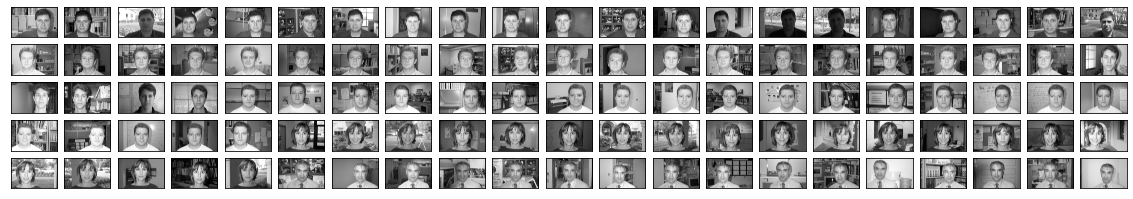

In [7]:
fig = plt.figure(figsize=(20, 20))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(5, 21), 
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, data['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## II. Face detection


Even though the bounding box coordinates are stored in the <em>CalTechFacesDirs/ImageData.mat</em> file, we'll be computing them from scratch for demonstrative purposes. 

### 1. Detect faces
There are many different face detection algorithms, you can follow the [Learn OpenCV tutorial on Face Detection](https://www.learnopencv.com/face-detection-opencv-dlib-and-deep-learning-c-python/) for some (very coarse) background info for two "conventional" (HAAR-cascade, HOG) CV methods and two Deep Neural Net (Dlib) based (SSD, MMOD) methods.

* Some background on Haar, HOG and MMOD face detectors can be found in this [Guide to Face Detection in Python](https://towardsdatascience.com/a-guide-to-face-detection-in-python-3eab0f6b9fc1). 

* For MMOD specifically, see: [Max-Margin Object Detection by Davis E. King](http://arxiv.org/abs/1502.00046) and the comments at the beginning of the [dnn_mmod_ex.cpp code](https://github.com/davisking/dlib/blob/master/examples/dnn_mmod_ex.cpp).

* For further info on the Single-Shot-Multibox Detector, see [the arXiv publication](https://arxiv.org/abs/1512.02325).

In this assignment we'll be using HAAR, you can find more information about this technique on the [OpenCV website](https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html).

In [8]:
faceCascade = cv2.CascadeClassifier('./models/haarcascade_frontalface_default.xml')

In [9]:
feat_data, images, labels = [], [], []

for img, label in zip(data['images'], data['target']):
    faces = faceCascade.detectMultiScale(
        img,
        scaleFactor = 1.2,
        minNeighbors = 9,
        minSize = (30, 30),
        flags = cv2.CASCADE_SCALE_IMAGE
    )

    # iterate faces found in image
    for (x, y, w, h) in faces:
        new_img = img.copy()
        
        # extract ROI
        raw_face = new_img[y:y+h, x:x+w]

        # resize the face to the preferred size
        face = cv2.resize(raw_face, face_size)
        face_flatten = face.flatten()
        
        images.append(np.expand_dims(face, axis=-1)), feat_data.append(face_flatten), labels.append(label)

# encode classes as integer value
label_encoder = LabelEncoder()
targets = label_encoder.fit_transform(labels)

faces = Bunch(data       = np.array(feat_data), 
              images     = np.array(images), 
              labels     = np.array(labels),
              target     = np.array(targets))

for key in faces.keys():
    print(faces[key][0:2])

[[125  84  55 ...  72  69  81]
 [110  47  24 ...  25  28  49]]
[[[[125]
   [ 84]
   [ 55]
   ...
   [ 88]
   [ 84]
   [ 80]]

  [[118]
   [ 64]
   [ 48]
   ...
   [158]
   [152]
   [ 61]]

  [[ 76]
   [ 68]
   [ 53]
   ...
   [107]
   [114]
   [ 99]]

  ...

  [[ 88]
   [ 98]
   [102]
   ...
   [106]
   [ 85]
   [ 86]]

  [[ 95]
   [ 92]
   [101]
   ...
   [ 83]
   [ 86]
   [112]]

  [[ 81]
   [ 93]
   [ 99]
   ...
   [ 72]
   [ 69]
   [ 81]]]


 [[[110]
   [ 47]
   [ 24]
   ...
   [ 15]
   [ 21]
   [ 24]]

  [[ 86]
   [ 78]
   [ 21]
   ...
   [ 20]
   [ 22]
   [ 20]]

  [[161]
   [122]
   [ 31]
   ...
   [ 17]
   [ 28]
   [ 38]]

  ...

  [[ 99]
   [103]
   [108]
   ...
   [ 19]
   [115]
   [178]]

  [[ 99]
   [102]
   [106]
   ...
   [ 26]
   [ 28]
   [128]]

  [[107]
   [103]
   [ 43]
   ...
   [ 25]
   [ 28]
   [ 49]]]]
['person_001' 'person_001']
[0 0]


### 2. Print statistics of data

In [10]:
# extract number of samples and image dimensions (for later display)
n_samples, h, w, n_channels = faces.images.shape
imshape = (h, w, n_channels)

# count number of individuals
n_classes = faces.target.max() +1

n_features = faces.data.shape[1]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_classes: %d" % n_classes)
print("n_features: %d" % n_features)
print("imshape : " + str(imshape))

Total dataset size:
n_samples: 440
n_classes: 26
n_features: 2209
imshape : (47, 47, 1)


### 3. Visualise some faces

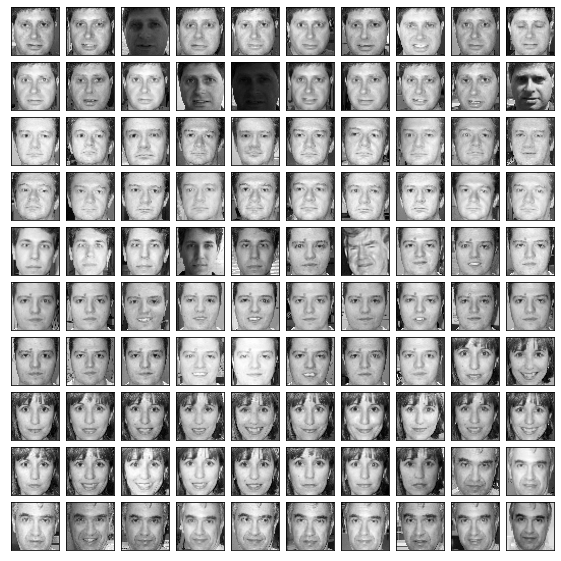

In [11]:
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(10, 10), 
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, faces['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(np.mean(im, -1), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## III. Feature extraction

Images tend to be large and can differ a lot in lighting, positioning, ... To combat this we'll extract features from each image using 4 different techniques. They all belong to the global/holistic feature representation approaches that map the image to a lower-dimensional subspace through linear and non-linear mapping. 

In [12]:
######################################
# select the technique you want to use
DESC = FeatureDescriptor.PCA
######################################

# number of PCA/LDA components to retain
num_components = 35

### 1. Eigenfaces for face recognition

From [PyImageSearch Gurus Course on Computer Vision](https://www.pyimagesearch.com/pyimagesearch-gurus/) by Adrian Rosebrock:
>In 1971 Goldstein et al. [Identification of human faces](https://ieeexplore.ieee.org/document/1450184) demonstrated that facial characteristics can be manually extracted, quantified and used for face recognition. The question then remained: could this be done in an automatic fashion? 

>It wasn’t until the 1987 paper by Kirby and Sirovich ([A Low-Dimensional Procedure for the Characterization of Human Faces](https://www.researchgate.net/publication/19588504_Low-Dimensional_Procedure_for_the_Characterization_of_Human_Faces)) that we were able to answer this question. This paper is considered to be a seminal work in the history of computer vision — and while other approaches have since been proposed that can outperform Eigenfaces, it’s still important that we take the time to understand and appreciate this algorithm. [Turk and Pentland](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=2ahUKEwjmvqy6jqfhAhWFZFAKHb74DNgQFjAAegQIABAC&url=http%3A%2F%2Fwww.face-rec.org%2Falgorithms%2Fpca%2Fjcn.pdf&usg=AOvVaw2IlxVps8dldmeA01yQDa_I) built on this idea in the context of face recognition. 

>The Eigenfaces algorithm uses Principal Component Analysis to construct a low-dimensional representation of face images.

>![An example of applying an eigenvalue decomposition to a dataset of faces and extracting the 16 "eigenfaces" with the largest corresponding eigenvalue magnitude.](notebook_images/what_is_fr_eigenfaces.jpg)


>This involves collecting a dataset of faces with multiple face images per person we want to identify — like having multiple training examples of an image class we would want to label in image classification. Given this dataset of face images, presumed to be the same width, height, and ideally — with their eyes and facial structures aligned at the same (x, y)-coordinates, we apply an eigenvalue decomposition of the dataset, keeping the eigenvectors with the largest corresponding eigenvalues.

>Given these eigenvectors, a face can then be represented as a linear combination of what Kirby and Sirovich call eigenfaces.

>Face identification can be performed by computing the Euclidean distance between the eigenface representations and treating the face identification as a k-Nearest Neighbor classification problem — however, we tend to commonly apply more advanced machine learning algorithms to the eigenface representations.

>Last, it’s important to note that the Eigenfaces algorithm is **not-specific to faces** — we can actually apply it to any arbitrary dataset containing objects of the same type that need to be compared, whether that may be bicycles, cans of soup, or ancient Aztec coins. The Eigenfaces algorithm can be modified to accommodate each of these identification tasks.

In [13]:
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean

if DESC == FeatureDescriptor.PCA:
    # Compute a PCA (eigenfaces) on the face dataset
    num_components = min(num_components, min(n_samples, n_features))
    print("num_components {n}".format(n=num_components))
    desc = PCA(n_components=num_components, svd_solver='randomized', whiten=True).fit(faces.data)
    X_pca = desc.transform(faces.data)
    embedded = X_pca
    
    dist_metric = euclidean

num_components 35


### 2. Fisherfaces for face recognition

From [Scholarpaedia](http://www.scholarpedia.org/article/Fisherfaces):
> When the goal is classification rather than representation, PCA may not yield the most desirable results. In such cases, one wishes to find a subspace that maps the sample vectors of the same class in a single spot of the feature representation and those of different classes as far apart from each other as possible. The techniques derived to achieve this goal are known as discriminant analysis (DA).
The most known DA is Linear Discriminant Analysis (LDA), which can be derived from an idea suggested by R.A. Fisher in 1936. When LDA is used to find the subspace representation of a set of face images, the resulting basis vectors defining that space are known as [Fisherfaces](http://www.scholarpedia.org/article/Fisherfaces).

![Example of FisherFaces](notebook_images/FisherFaces.jpg)

In [14]:
DESC = FeatureDescriptor.LDA

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.spatial.distance import euclidean

if DESC == FeatureDescriptor.LDA:
    num_components = min(num_components, min(n_classes - 1, n_features))
    desc = LinearDiscriminantAnalysis(n_components=num_components).fit(faces.data, faces.target)
    X_lda = desc.fit_transform(faces.data, faces.target)
    embedded = X_lda
    
    dist_metric = euclidean

### 3. LBP for face recognition

Local Binary Patterns, or LBPs for short, are a texture descriptor made popular by the work of Ojala et al. in their 2002 paper, [Multiresolution Grayscale and Rotation Invariant Texture Classification with Local Binary Patterns](https://ieeexplore.ieee.org/document/1017623) (although the concept of LBPs were introduced as early as 1993).

Unlike [Haralick texture features](http://haralick.org/journals/TexturalFeatures.pdf) that compute a global representation of texture based on the [Gray Level Co-occurrence Matrix](https://en.wikipedia.org/wiki/Co-occurrence_matrix), LBPs instead compute a local representation of texture. This local representation is constructed by comparing each pixel with its surrounding neighborhood of pixels. See [PyImageSearch](https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/) and [Scikit-Image](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html) for further details on LBP.
![LBP](notebook_images/LBP.png)

In [16]:
from localmodules.local_binary_patterns import LBP
from scipy.stats import chisquare

if DESC == FeatureDescriptor.LBP:
    desc = LBP(numPoints=8, radius=1, grid_x=7, grid_y=7)
    embedded = desc.describe_list(faces.images[...,0])
    
    dist_metric = chisquare
    
# Hint: If you get NaN values as a result of Chi-Square, feel free to use the following function:

def CHI2(histA, histB, eps=1e-10):
    # compute the chi-squared distance
    d = 0.5 * np.sum(((histA - histB) ** 2) / (histA + histB + eps))

    # return the chi-squared distance
    return d

### 4. Deep metric learning
Similar to previous techniques, we can use deep learning to generate an enriched representation of faces that you can use in simple or more complicated classification algorithms. 
Instead of building networks that are trained end-to-end to perform face recognition, we will use deep metric learning. Metric learning based methods learn a projection of the input data on a low-dimensional vector, such that classification in that lower-dimensional space is much easier and can be performed using simple distance metrics. 

In the context of face recognition we can observe the following major Deep Learning based approaches since 2014.

1. The first approach was developed and presented in 2014 by researchers at Facebook and is called [DeepFace](https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf) . The major contributions where a CDNN to classify faces. In addition a 3D/2D alignment procedure is applied prior to classification. 
The CDNN is trained as a classifier on the SFC (Social Face Classification) dataset, which is a very large (4.4 million image of 4000 individuals) dataset. This setting is called supervised.  The challenge is whether this can also be generalizd to other datasets and subjects as well. By training it on the large collection of uncontrolled images, an embedded representation (the vector description prior to the classification layer) can be generated that is, allegedly, generalizable to other face recognition data. One can then use this representation as we have previously done for classical representations. 
By way of demonstration they tested it on the LFW dataset to achieve >0.95% verification accuracy. <br> 

2. The second approach was developed by researchers at Google.  An in-depth presentation of their FaceNet/OpenFace deep CNN's for metric embedding of faces is given by [Martin Krasser et al](http://krasserm.github.io/2018/02/07/deep-face-recognition/). Note that this method was trained on 200 million images of eight million identities. The main methodological point is that these networks are trained using a special loss-function: the triplet loss function. 
>This function is minimized when the distance between an anchor image $x_{ai}$ and a positive image $x_{pi}$ (same identity) in embedding space is smaller than the distance between that anchor image and a negative image $x_{ni}$ (different identity) by at least a margin $\alpha$. Model training aims to learn an embedding f(x) of image x such that the squared L2 distance between all faces of the same identity is small and the distance between a pair of faces from different identities is large. 







There is a very elegant Python implementations available of the FaceNet/OpenFace approach. It is nicely described in [this PyImageSearch tutorial](https://www.pyimagesearch.com/2018/06/18/face-recognition-with-opencv-python-and-deep-learning/). It explicitly includes the Dlib package with the [face_recognition modules](https://face-recognition.readthedocs.io/en/latest/index.html) for face detection and recognition. Especially the latter package provides a very convenient interface. 

From the [Dlib face_recognition.py](https://github.com/davisking/dlib/blob/master/python_examples/face_recognition.py) code, we get an application view of the embedding:

> This example shows how to use dlib's face recognition tool.  This tool maps an image of a human face to a 128 dimensional vector space where images of the same person are near to each other and images from different people are far apart.  Therefore, you can perform face recognition by mapping faces to the 128D space and then checking if their Euclidean distance is small enough. 

> When using a distance threshold of 0.6, the dlib model obtains an accuracy of 99.38% on the standard LFW face recognition benchmark, which is comparable to other state-of-the-art methods for face recognition as of February 2017. This accuracy means that, when presented with a pair of face images, the tool will correctly identify if the pair belongs to the same person or is from different people 99.38% of the time.

In the [DeepFace](https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf) paper they also tested a [siamese network](https://en.wikipedia.org/wiki/Siamese_network) DNN architecture for generating embedded vector representations.  This consists of two copies of the same CNN (sharing their weights) that are applied to pairs of images. During training the distance between the embedded representations of the same individual is minimized, and the distances between embedded representations of different individuals is maximized. In the mean time, this work was extended, steadily increasing the performance. Siamese networks are an example of *One-shot Learning* where you tyically have very few samples per object or dynamically changing number of objects/subjects. While [this link](https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d) tests it on a non-face recognition task, it can be applied to face recognition as well.

The localmodules.siamese file contains the description of a shallow CNN model that is trained with [contrastive loss](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf).
This subnetwork is copied twice and the output of both siamese copies are then passed onto a vector euclidean distance (ED) calculation layer. The network gets as input pairs of imposter or genuine images with the associated label (genuine = 0, imposter = 1). You can make use of the output of the network or the output before the ED layer (embedded) in your validation.

Note: this part on Siamese networks is adapted from [Packt tutorial](https://hub.packtpub.com/face-recognition-using-siamese-networks-tutorial/), which seems to be a re-implementation from  [this Packt book on Neural Network Projects with Python](https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781789138900)). See also [this Hackernoon tutorial](https://hackernoon.com/one-shot-learning-with-siamese-networks-in-pytorch-8ddaab10340e).

Note: you can change the CNN at your will, but beware that it might take additional training time.

In [17]:
# If you encounter problem importing the siamese model, consider using Google Colab.
import localmodules.siamese as siamese

In [18]:
encoder, model = siamese.create_siamese_model(imshape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 47, 47, 1)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 47, 47, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 128)          894400      ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 1)            0           ['sequential[0][0]',         

In [19]:
embedded_test = encoder(faces.images.astype(np.float32)).numpy()

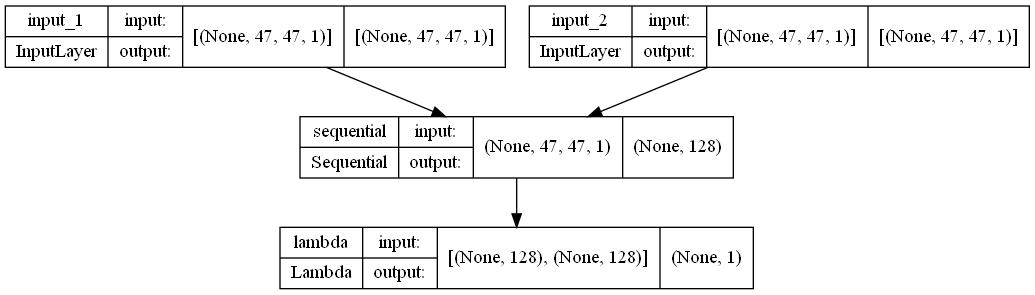

In [20]:
# To visualize your model structure:
plot_model(model, to_file='results/model.png', show_shapes = True, show_layer_names = True)

Depending on the complexity of the Siamese network this might take a while. You can also change the number of epochs to improve the training (with the risk of overfitting). You will notice that a small number (<10) of epochs already gets you a decent performance.

In [21]:
DESC = FeatureDescriptor.DL

In [22]:
if DESC == FeatureDescriptor.DL:
    x_train, x_test, y_train, y_test = holdout_split(*siamese.get_siamese_paired_data(faces.images, faces.target))
    rms = Adam()
    model.compile(
        loss=siamese.contrastive_loss, 
        optimizer=rms, 
        metrics = [siamese.accuracy],
        run_eagerly=True)

    epochs = 10
    model.fit([x_train[:, 0], x_train[:, 1]], y_train, 
              validation_split=0.2,
              batch_size=32, verbose=2, epochs=epochs)
    
    test_scores = model.predict([x_test[:, 0], x_test[:, 1]])
    test_acc = accuracy_score(y_test, test_scores > 0.5)
    print("Accuracy on the test set: {}".format(test_acc))
    embedded = encoder(faces.images.astype(np.float32)).numpy()

    dist_metric = euclidean

Epoch 1/10
38/38 - 1s - loss: 0.0925 - accuracy: 0.7484 - val_loss: 0.0528 - val_accuracy: 0.8750 - 1s/epoch - 37ms/step
Epoch 2/10
38/38 - 1s - loss: 0.0362 - accuracy: 0.9408 - val_loss: 0.0307 - val_accuracy: 0.9698 - 830ms/epoch - 22ms/step
Epoch 3/10
38/38 - 1s - loss: 0.0208 - accuracy: 0.9720 - val_loss: 0.0207 - val_accuracy: 0.9708 - 864ms/epoch - 23ms/step
Epoch 4/10
38/38 - 1s - loss: 0.0135 - accuracy: 0.9910 - val_loss: 0.0192 - val_accuracy: 0.9583 - 861ms/epoch - 23ms/step
Epoch 5/10
38/38 - 1s - loss: 0.0112 - accuracy: 0.9942 - val_loss: 0.0165 - val_accuracy: 0.9792 - 859ms/epoch - 23ms/step
Epoch 6/10
38/38 - 1s - loss: 0.0076 - accuracy: 0.9975 - val_loss: 0.0150 - val_accuracy: 0.9844 - 843ms/epoch - 22ms/step
Epoch 7/10
38/38 - 1s - loss: 0.0056 - accuracy: 0.9984 - val_loss: 0.0128 - val_accuracy: 0.9906 - 845ms/epoch - 22ms/step
Epoch 8/10
38/38 - 1s - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0125 - val_accuracy: 0.9906 - 831ms/epoch - 22ms/step
Epoch 9/10


## IV. Distance-based and classification-based scoring

Biometrics is based on generating pairwise matching scores. In it's simplest form, the score is computed based on the distance metrics (distance-based scoring). E.g. a simple pairwise comparision (L2-distance, e.g.) can be used. 

* In verification mode one compares this matching score to a decision threshold in a 1-to-1 setting.
* In identifcation mode one uses this matching score to rank the templates in the database and, possibly, thresholding it as well in a 1-to-N setting
 

On the other hand, some classification algorithms provide us with the classification scores (or probabilities), which are related to the likelihood that an image belongs to each subject in the dataset. These classification scores can be seen as an advanced classification-based matching score. 

* In verification mode one compares the soft scores (or probabilities) of the classification with a threshold to verify whether the person is who he claims to be.
* In identifcation mode one sorts the soft scores to propose the most similar people in the dataset.

To implement a classification-based system (optional task 3), the following steps are expected:
1. For each person in the dataset leave one image out (E.g. the first image in the dataset) for the testset. This means the size of the test set equals the number of individuals in the data (=n).
2. Run the classifier of your choice and generate the classification probabilities for each test image.
3. Build your n by n similarity matrix, in which each row corresponds to a test image and each column corresponds to an individual in the dataset.
4. Calculate the evaluation metrics (E.g. ROC) based on the obtained similarity matrix to test your system in a verification or identification scenario.

<div class="alert alert-block alert-success">
<b>Q1: </b> Compute distance-based pair-wise matching scores.
</div>

Given the function <em>dist_metric</em> and the vector representations in variable <em>embedded</em>, compute the pairwise distances. Do this for PCA, LDA, LBP and a DL facial representations, given the code above.

For easier use, I created a file containing utils function from the above described facial representations.

In [23]:
facial_descriptor = FacialDescriptor(num_components, faces, n_samples, n_features, n_classes, imshape)

### PCA

In [24]:
embedded_PCA, dist_metric_PCA = facial_descriptor.extract_face_representation(DESC=FeatureDescriptor.PCA)
df_scores_PCA, similarity_mat_pca = utils.compute_similarity_matrix(embedded_PCA, dist_metric_PCA, labels)
df_scores_PCA

num_components 25


100%|███████████████████████████████████████████████████████████████████████████████| 440/440 [00:01<00:00, 274.32it/s]


p1          p2  genuine     score  scores_norm
0       person_001  person_001        1  3.670895     0.837739
1       person_001  person_001        1  6.197264     0.670048
2       person_001  person_001        1  3.000082     0.882265
3       person_001  person_001        1  2.587310     0.909663
4       person_001  person_001        1  4.175082     0.804273
...            ...         ...      ...       ...          ...
193155  person_026  person_026        1  2.493292     0.915904
193156  person_026  person_026        1  4.406775     0.788894
193157  person_026  person_026        1  4.180320     0.803925
193158  person_026  person_026        1  3.460844     0.851681
193159  person_026  person_026        1  3.963375     0.818325

[193160 rows x 5 columns]

In [25]:
face_mat_pca = df_scores_PCA.pivot_table(index='p1', columns='p2',values='scores_norm',aggfunc = np.average)
face_mat_pca

p2          person_001  person_002  person_003  person_004  person_005  \
p1                                                                       
person_001    0.716266    0.632855    0.592561    0.635441    0.591460   
person_002    0.632855    0.827695    0.647495    0.717753    0.634746   
person_003    0.592561    0.647495    0.635495    0.613127    0.575271   
person_004    0.635441    0.717753    0.613127    0.767343    0.621254   
person_005    0.591460    0.634746    0.575271    0.621254    0.805517   
person_006    0.598799    0.668908    0.623670    0.633319    0.609069   
person_007    0.625524    0.699190    0.627667    0.696010    0.634197   
person_008    0.594523    0.628227    0.575439    0.652496    0.603055   
person_009    0.564081    0.616277    0.562145    0.585034    0.569425   
person_010    0.585199    0.646400    0.569076    0.610226    0.573062   
person_011    0.548839    0.585158    0.593511    0.575569    0.567066   
person_012    0.517268    0.607376    0.514560    0.599831    0.547428   
person_013    0.613258    0.725610    0.644334    0.666160    0.692667   
person_014    0.562736    0.601305    0.525887    0.606292    0.570136   
person_015    0.593705    0.641148    0.579535    0.610379    0.589984   
person_016    0.612782    0.723651    0.636030    0.653657    0.630780   
person_017    0.569562    0.586441    0.515761    0.552429    0.539880   
person_018    0.638834    0.704517    0.636691    0.663937    0.647618   
person_019    0.565777    0.595921    0.599329    0.591075    0.573526   
person_020    0.574795    0.651984    0.555657    0.630912    0.594432   
person_021    0.613227    0.689165    0.605060    0.656915    0.629058   
person_022    0.614507    0.662757    0.592841    0.665280    0.617720   
person_023    0.569441    0.635176    0.612081    0.634769    0.603693   
person_024    0.549857    0.579511    0.571929    0.592022    0.553645   
person_025    0.588424    0.655443    0.600591    0.634984    0.606078   
person_026    0.664005    0.678316    0.628837    0.657012    0.639076   

p2          person_006  person_007  person_008  person_009  person_010  ...  \
p1                                                                      ...   
person_001    0.598799    0.625524    0.594523    0.564081    0.585199  ...   
person_002    0.668908    0.699190    0.628227    0.616277    0.646400  ...   
person_003    0.623670    0.627667    0.575439    0.562145    0.569076  ...   
person_004    0.633319    0.696010    0.652496    0.585034    0.610226  ...   
person_005    0.609069    0.634197    0.603055    0.569425    0.573062  ...   
person_006    0.739434    0.647294    0.619601    0.573060    0.588050  ...   
person_007    0.647294    0.810099    0.639375    0.606654    0.633019  ...   
person_008    0.619601    0.639375    0.636618    0.596065    0.610730  ...   
person_009    0.573060    0.606654    0.596065    0.701273    0.563507  ...   
person_010    0.588050    0.633019    0.610730    0.563507    0.832171  ...   
person_011    0.604884    0.615751    0.583812    0.539131    0.567305  ...   
person_012    0.575766    0.589782    0.546032    0.517191    0.516417  ...   
person_013    0.660120    0.671664    0.612693    0.607125    0.636459  ...   
person_014    0.595979    0.604243    0.595336    0.554334    0.539599  ...   
person_015    0.602529    0.623534    0.593769    0.570035    0.579028  ...   
person_016    0.626737    0.684830    0.634386    0.595109    0.633139  ...   
person_017    0.588437    0.537392    0.540413    0.490087    0.532835  ...   
person_018    0.662007    0.697772    0.628847    0.610607    0.606015  ...   
person_019    0.599423    0.611064    0.587658    0.543710    0.547617  ...   
person_020    0.638668    0.617516    0.612514    0.564148    0.620187  ...   
person_021    0.628818    0.693438    0.617157    0.591666    0.600881  ...   
person_022    0.642878    0.706226    0.647546    0.594607    0.606632  ...   
person_023    0.609946    0.627

In [26]:
genuine_df_pca = df_scores_PCA['scores_norm'][df_scores_PCA['genuine'] == 1]
imposter_df_pca = df_scores_PCA['scores_norm'][df_scores_PCA['genuine'] == 0]

print('number of genuine scores : ', len(genuine_df_pca))
print('number of imposter scores : ', len(imposter_df_pca))

number of genuine scores :  8420
number of imposter scores :  184740


### LDA

In [27]:
embedded_LDA, dist_metric_LDA = facial_descriptor.extract_face_representation(DESC=FeatureDescriptor.LDA)
df_scores_LDA, similarity_mat_lda = utils.compute_similarity_matrix(embedded_LDA, dist_metric_LDA, labels)
df_scores_LDA

100%|███████████████████████████████████████████████████████████████████████████████| 440/440 [00:01<00:00, 428.02it/s]


p1          p2  genuine      score  scores_norm
0       person_001  person_001        1   6.255456     0.883117
1       person_001  person_001        1   9.828133     0.775818
2       person_001  person_001        1   7.391354     0.849002
3       person_001  person_001        1   6.824139     0.866038
4       person_001  person_001        1   5.418200     0.908262
...            ...         ...      ...        ...          ...
193155  person_026  person_026        1   6.303830     0.881664
193156  person_026  person_026        1   6.736131     0.868681
193157  person_026  person_026        1  10.646684     0.751235
193158  person_026  person_026        1   6.811352     0.866422
193159  person_026  person_026        1   5.784223     0.897269

[193160 rows x 5 columns]

In [28]:
face_mat_lda = df_scores_LDA.pivot_table(index='p1', columns='p2',values='scores_norm',aggfunc = np.average)
face_mat_lda

p2          person_001  person_002  person_003  person_004  person_005  \
p1                                                                       
person_001    0.858190    0.482878    0.462904    0.502984    0.228204   
person_002    0.482878    0.832485    0.498495    0.638965    0.323602   
person_003    0.462904    0.498495    0.849990    0.477264    0.269576   
person_004    0.502984    0.638965    0.477264    0.856741    0.291945   
person_005    0.228204    0.323602    0.269576    0.291945    0.932425   
person_006    0.416450    0.512578    0.406402    0.558653    0.268596   
person_007    0.430342    0.575778    0.461194    0.565554    0.286351   
person_008    0.391809    0.446568    0.353388    0.535500    0.227541   
person_009    0.351576    0.376465    0.305030    0.421481    0.200545   
person_010    0.441144    0.540354    0.430169    0.536877    0.244506   
person_011    0.407521    0.420739    0.469823    0.449076    0.283701   
person_012    0.339965    0.486580    0.324078    0.507044    0.250471   
person_013    0.310805    0.481036    0.366122    0.411789    0.552466   
person_014    0.216366    0.303237    0.143095    0.377604    0.094305   
person_015    0.386917    0.333615    0.356162    0.389977    0.178254   
person_016    0.432483    0.574233    0.473823    0.550355    0.277815   
person_017    0.388686    0.387884    0.352078    0.431008    0.172771   
person_018    0.536693    0.622386    0.532890    0.612736    0.395382   
person_019    0.485987    0.519135    0.559944    0.544589    0.282026   
person_020    0.457285    0.558652    0.417630    0.590406    0.268054   
person_021    0.395929    0.445136    0.389875    0.496989    0.304034   
person_022    0.489557    0.578847    0.469492    0.639571    0.291425   
person_023    0.291416    0.312647    0.418742    0.379460    0.165636   
person_024    0.415870    0.426370    0.407790    0.500073    0.188706   
person_025    0.425603    0.459819    0.426794    0.490456    0.294891   
person_026    0.554358    0.545245    0.526387    0.534651    0.346495   

p2          person_006  person_007  person_008  person_009  person_010  ...  \
p1                                                                      ...   
person_001    0.416450    0.430342    0.391809    0.351576    0.441144  ...   
person_002    0.512578    0.575778    0.446568    0.376465    0.540354  ...   
person_003    0.406402    0.461194    0.353388    0.305030    0.430169  ...   
person_004    0.558653    0.565554    0.535500    0.421481    0.536877  ...   
person_005    0.268596    0.286351    0.227541    0.200545    0.244506  ...   
person_006    0.873767    0.438509    0.465734    0.370690    0.464972  ...   
person_007    0.438509    0.770055    0.412981    0.361837    0.469330  ...   
person_008    0.465734    0.412981    0.871426    0.450515    0.458460  ...   
person_009    0.370690    0.361837    0.450515    0.907362    0.379825  ...   
person_010    0.464972    0.469330    0.458460    0.379825    0.893752  ...   
person_011    0.382371    0.429633    0.352813    0.290063    0.374486  ...   
person_012    0.509860    0.420021    0.374361    0.315876    0.405273  ...   
person_013    0.383781    0.410958    0.291060    0.287362    0.388216  ...   
person_014    0.400470    0.250760    0.382363    0.376476    0.298154  ...   
person_015    0.311002    0.294763    0.321091    0.376926    0.329577  ...   
person_016    0.463827    0.513478    0.472810    0.379565    0.504735  ...   
person_017    0.377127    0.355401    0.323826    0.242411    0.350922  ...   
person_018    0.534571    0.579290    0.494625    0.422278    0.557271  ...   
person_019    0.483640    0.505511    0.451484    0.404066    0.491495  ...   
person_020    0.641632    0.447072    0.494228    0.396395    0.538023  ...   
person_021    0.366700    0.506524    0.366625    0.321439    0.394404  ...   
person_022    0.560025    0.631788    0.501491    0.387960    0.529085  ...   
person_023    0.335905    0.324

In [29]:
genuine_df_lda = df_scores_LDA['scores_norm'][df_scores_LDA['genuine'] == 1]
imposter_df_lda = df_scores_LDA['scores_norm'][df_scores_LDA['genuine'] == 0]

### LBP

In [30]:
embedded_LBP, dist_metric_LBP = facial_descriptor.extract_face_representation(DESC=FeatureDescriptor.LBP)

df_scores_LBP, similarity_mat_lbp = utils.compute_similarity_matrix(embedded_LBP, utils.chi2, labels)
# dist_metric_LBP(embedded_LBP, axis=1).statistic
df_scores_LBP

ic| DESC: <FeatureDescriptor.LBP: 'LBP'>
100%|███████████████████████████████████████████████████████████████████████████████| 440/440 [00:01<00:00, 296.50it/s]


p1          p2  genuine     score  scores_norm
0       person_001  person_001        1  4.817430     0.910841
1       person_001  person_001        1  6.989416     0.693627
2       person_001  person_001        1  5.101078     0.882474
3       person_001  person_001        1  5.110625     0.881519
4       person_001  person_001        1  4.936796     0.898903
...            ...         ...      ...       ...          ...
193155  person_026  person_026        1  5.213133     0.871268
193156  person_026  person_026        1  5.501838     0.842395
193157  person_026  person_026        1  7.172513     0.675316
193158  person_026  person_026        1  5.262652     0.866316
193159  person_026  person_026        1  5.318515     0.860729

[193160 rows x 5 columns]

In [31]:
face_mat_lbp = df_scores_LBP.pivot_table(index='p1', columns='p2',values='scores_norm',aggfunc = np.average)
face_mat_lbp

p2          person_001  person_002  person_003  person_004  person_005  \
p1                                                                       
person_001    0.770368    0.733379    0.677255    0.713861    0.664364   
person_002    0.733379    0.827129    0.675055    0.766053    0.708955   
person_003    0.677255    0.675055    0.743205    0.659172    0.678719   
person_004    0.713861    0.766053    0.659172    0.825138    0.646241   
person_005    0.664364    0.708955    0.678719    0.646241    0.846521   
person_006    0.710772    0.754482    0.696355    0.744639    0.705222   
person_007    0.552227    0.528436    0.591677    0.570422    0.384002   
person_008    0.684709    0.727437    0.661735    0.742507    0.649630   
person_009    0.707581    0.732913    0.717691    0.742625    0.633678   
person_010    0.693941    0.742831    0.616054    0.744231    0.624697   
person_011    0.655474    0.653073    0.690268    0.634705    0.602679   
person_012    0.646920    0.657878    0.630819    0.640944    0.664911   
person_013    0.671686    0.702984    0.656088    0.648231    0.759759   
person_014    0.661603    0.694329    0.660341    0.724259    0.590991   
person_015    0.719634    0.738891    0.694846    0.734966    0.707786   
person_016    0.718123    0.758346    0.680736    0.745896    0.680250   
person_017    0.678575    0.681709    0.633986    0.679782    0.625457   
person_018    0.695383    0.719684    0.718174    0.707105    0.673811   
person_019    0.617632    0.619259    0.651786    0.617862    0.596249   
person_020    0.663955    0.693652    0.625625    0.677682    0.689378   
person_021    0.699017    0.717459    0.657700    0.695961    0.673048   
person_022    0.605285    0.582387    0.617418    0.601683    0.456163   
person_023    0.705912    0.721856    0.713601    0.723697    0.724241   
person_024    0.634045    0.659062    0.670756    0.671059    0.560373   
person_025    0.692627    0.728917    0.707262    0.729595    0.640319   
person_026    0.690753    0.699910    0.669717    0.690556    0.687538   

p2          person_006  person_007  person_008  person_009  person_010  ...  \
p1                                                                      ...   
person_001    0.710772    0.552227    0.684709    0.707581    0.693941  ...   
person_002    0.754482    0.528436    0.727437    0.732913    0.742831  ...   
person_003    0.696355    0.591677    0.661735    0.717691    0.616054  ...   
person_004    0.744639    0.570422    0.742507    0.742625    0.744231  ...   
person_005    0.705222    0.384002    0.649630    0.633678    0.624697  ...   
person_006    0.781868    0.526414    0.725772    0.723885    0.717212  ...   
person_007    0.526414    0.841835    0.531943    0.664170    0.467075  ...   
person_008    0.725772    0.531943    0.737180    0.723686    0.699588  ...   
person_009    0.723885    0.664170    0.723686    0.840922    0.688989  ...   
person_010    0.717212    0.467075    0.699588    0.688989    0.843254  ...   
person_011    0.650874    0.598352    0.621633    0.703876    0.593982  ...   
person_012    0.675455    0.416219    0.659557    0.641489    0.632400  ...   
person_013    0.685078    0.429101    0.635231    0.630721    0.642530  ...   
person_014    0.713225    0.615873    0.717204    0.757438    0.691884  ...   
person_015    0.741867    0.547633    0.728887    0.743549    0.683999  ...   
person_016    0.727763    0.546288    0.709382    0.707821    0.700087  ...   
person_017    0.705506    0.467448    0.674176    0.692454    0.712680  ...   
person_018    0.705506    0.637037    0.662357    0.736329    0.639054  ...   
person_019    0.639436    0.505821    0.646596    0.666559    0.605718  ...   
person_020    0.712244    0.407016    0.696458    0.662370    0.685529  ...   
person_021    0.687211    0.504916    0.673061    0.659225    0.650310  ...   
person_022    0.579435    0.751860    0.563799    0.675120    0.536989  ...   
person_023    0.733820    0.531

In [32]:
genuine_df_lbp = df_scores_LBP['scores_norm'][df_scores_LBP['genuine'] == 1]
imposter_df_lbp = df_scores_LBP['scores_norm'][df_scores_LBP['genuine'] == 0]

### DL

In [33]:
embedded_DL, dist_metric_DL = facial_descriptor.extract_face_representation(DESC=FeatureDescriptor.DL, holdout_split=holdout_split)
df_scores_DL, similarity_mat_dl = utils.compute_similarity_matrix(embedded_DL, dist_metric_DL, labels)
df_scores_DL

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 47, 47, 1)]  0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 47, 47, 1)]  0           []                               
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          894400      ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 1)            0           ['sequential_1[0][0]',     

100%|███████████████████████████████████████████████████████████████████████████████| 440/440 [00:01<00:00, 330.67it/s]


p1          p2  genuine      score  scores_norm
0       person_001  person_001        1  54.697399     0.888680
1       person_001  person_001        1  53.108501     0.892315
2       person_001  person_001        1  25.218859     0.956131
3       person_001  person_001        1  34.589367     0.934690
4       person_001  person_001        1  34.697121     0.934443
...            ...         ...      ...        ...          ...
193155  person_026  person_026        1  22.896046     0.961446
193156  person_026  person_026        1  33.979977     0.936084
193157  person_026  person_026        1  34.371868     0.935187
193158  person_026  person_026        1  22.882639     0.961476
193159  person_026  person_026        1  26.187286     0.953915

[193160 rows x 5 columns]

In [34]:
face_mat_dl = df_scores_DL.pivot_table(index='p1', columns='p2',values='scores_norm',aggfunc = np.average)
face_mat_dl

p2          person_001  person_002  person_003  person_004  person_005  \
p1                                                                       
person_001    0.901557    0.658141    0.815520    0.616798    0.399523   
person_002    0.658141    0.955970    0.620979    0.721359    0.288043   
person_003    0.815520    0.620979    0.873390    0.554213    0.400618   
person_004    0.616798    0.721359    0.554213    0.930578    0.273466   
person_005    0.399523    0.288043    0.400618    0.273466    0.943935   
person_006    0.552446    0.536893    0.588334    0.526885    0.375434   
person_007    0.641689    0.777226    0.612496    0.635139    0.372443   
person_008    0.465258    0.464471    0.469053    0.576491    0.298975   
person_009    0.445930    0.430254    0.436207    0.517454    0.281990   
person_010    0.629057    0.643485    0.602540    0.639495    0.153102   
person_011    0.714056    0.638415    0.750393    0.555014    0.531962   
person_012    0.522689    0.601669    0.512386    0.617533    0.426027   
person_013    0.616217    0.624912    0.587713    0.542102    0.623044   
person_014    0.249438    0.222181    0.256798    0.348259    0.128412   
person_015    0.490753    0.324182    0.481939    0.415917    0.362218   
person_016    0.689996    0.725624    0.690250    0.668264    0.281721   
person_017    0.559507    0.444939    0.579102    0.491147    0.466882   
person_018    0.687303    0.855130    0.633301    0.734021    0.304010   
person_019    0.707738    0.609217    0.675953    0.689427    0.303497   
person_020    0.616890    0.625634    0.581334    0.710921    0.253781   
person_021    0.485930    0.417868    0.511300    0.386032    0.696086   
person_022    0.585996    0.774021    0.586021    0.668747    0.367412   
person_023    0.498423    0.338471    0.533136    0.410977    0.420026   
person_024    0.637411    0.608338    0.588943    0.749503    0.247844   
person_025    0.637258    0.605857    0.595535    0.577880    0.494038   
person_026    0.686445    0.574577    0.610205    0.523768    0.525490   

p2          person_006  person_007  person_008  person_009  person_010  ...  \
p1                                                                      ...   
person_001    0.552446    0.641689    0.465258    0.445930    0.629057  ...   
person_002    0.536893    0.777226    0.464471    0.430254    0.643485  ...   
person_003    0.588334    0.612496    0.469053    0.436207    0.602540  ...   
person_004    0.526885    0.635139    0.576491    0.517454    0.639495  ...   
person_005    0.375434    0.372443    0.298975    0.281990    0.153102  ...   
person_006    0.941615    0.477159    0.634510    0.469432    0.481981  ...   
person_007    0.477159    0.961137    0.430622    0.440493    0.503209  ...   
person_008    0.634510    0.430622    0.944153    0.700229    0.436938  ...   
person_009    0.469432    0.440493    0.700229    0.926828    0.358621  ...   
person_010    0.481981    0.503209    0.436938    0.358621    0.963781  ...   
person_011    0.630851    0.674325    0.490739    0.417580    0.491045  ...   
person_012    0.673325    0.530250    0.610305    0.531775    0.485555  ...   
person_013    0.528405    0.638865    0.409890    0.370861    0.449178  ...   
person_014    0.525141    0.157826    0.679041    0.525059    0.263325  ...   
person_015    0.533348    0.276685    0.571960    0.551860    0.379734  ...   
person_016    0.568156    0.664479    0.581666    0.537623    0.667225  ...   
person_017    0.742209    0.466309    0.686735    0.563875    0.375972  ...   
person_018    0.500254    0.801993    0.449945    0.442462    0.630534  ...   
person_019    0.588922    0.601159    0.613178    0.583454    0.593374  ...   
person_020    0.646304    0.501514    0.609398    0.510798    0.681436  ...   
person_021    0.520790    0.526800    0.464595    0.447787    0.252247  ...   
person_022    0.637791    0.772566    0.562010    0.501776    0.517032  ...   
person_023    0.628863    0.369

In [35]:
genuine_df_dl = df_scores_DL['scores_norm'][df_scores_DL['genuine'] == 1]
imposter_df_dl = df_scores_DL['scores_norm'][df_scores_DL['genuine'] == 0]

## V. Evaluation

In this section you can re-use the code you developed for validation in the previous assignments, and in particular assignment 1. 

### 1. Validation as verification system

<div class="alert alert-block alert-success">
<b>Q2: </b> Compute F1 and accuracy scores for variable (and optimal) thresholds
</div>

* Calculate and plot F1 and accuracy scores for a range (min, max) of thresholds.
* Determine some optimal threshold (look up in classification literature). Justify your answer.

In [36]:
score_pca, y_true_pca = df_scores_PCA['genuine'], df_scores_PCA['scores_norm']
score_lda, y_true_lda = df_scores_LDA['genuine'], df_scores_LDA['scores_norm']
score_lbp, y_true_lbp = df_scores_LBP['genuine'], df_scores_LBP['scores_norm']
score_dl, y_true_dl = df_scores_DL['genuine'], df_scores_DL['scores_norm']

In [37]:
df_classification_metrics_pca, precision_pca, recall_pca = metrics.get_f1_and_acc_dataframe(genuine_df_pca, imposter_df_pca, score_pca, y_true_pca)
df_classification_metrics_lda, precision_lda, recall_lda = metrics.get_f1_and_acc_dataframe(genuine_df_lda, imposter_df_lda, score_lda, y_true_lda)
df_classification_metrics_lbp, precision_lbp, recall_lbp = metrics.get_f1_and_acc_dataframe(genuine_df_lbp, imposter_df_lbp, score_lbp, y_true_lbp)
df_classification_metrics_dl, precision_dl, recall_dl = metrics.get_f1_and_acc_dataframe(genuine_df_dl, imposter_df_dl, score_dl, y_true_dl)

2022-05-28 13:03:01,079 - Computing precision recall
2022-05-28 13:03:01,104 - Computing accuracy
2022-05-28 13:03:06,969 - Generate dataframe
2022-05-28 13:03:06,978 - Computing precision recall
2022-05-28 13:03:07,003 - Computing accuracy
2022-05-28 13:03:08,729 - Generate dataframe
2022-05-28 13:03:08,733 - Computing precision recall
2022-05-28 13:03:08,758 - Computing accuracy
2022-05-28 13:03:13,630 - Generate dataframe
2022-05-28 13:03:13,638 - Computing precision recall
2022-05-28 13:03:13,661 - Computing accuracy
2022-05-28 13:03:14,633 - Generate dataframe


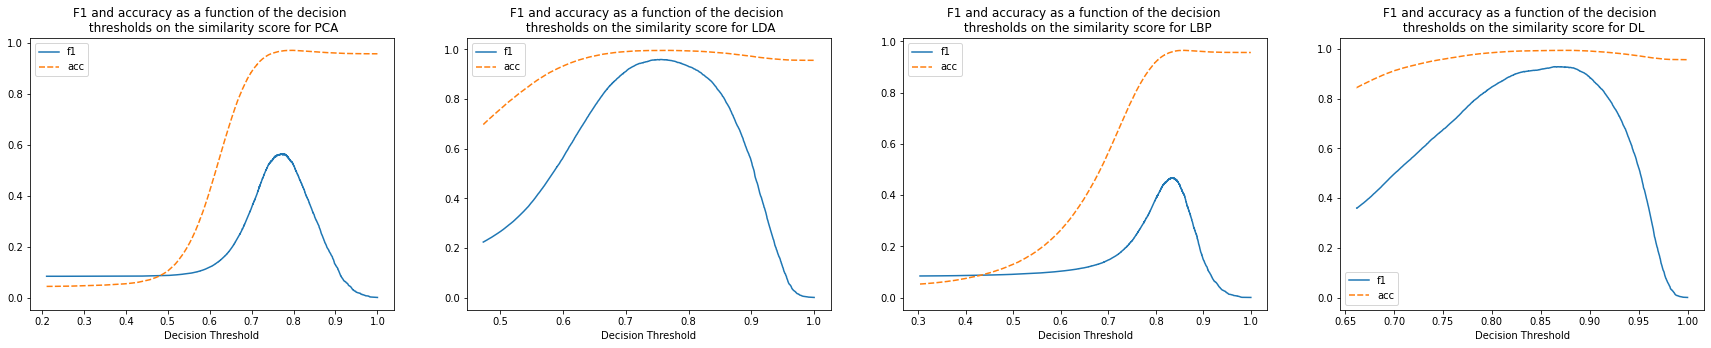

In [38]:
figure, axes = plt.subplots(1, 4, figsize=(30, 5))
metrics.plot_decision_threshold_f1_acc(df_classification_metrics_pca, "PCA", axes[0])
metrics.plot_decision_threshold_f1_acc(df_classification_metrics_lda, "LDA", axes[1])
metrics.plot_decision_threshold_f1_acc(df_classification_metrics_lbp, "LBP", axes[2])
metrics.plot_decision_threshold_f1_acc(df_classification_metrics_dl, "DL", axes[3])

<div class="alert alert-block alert-success">
<b>Q3: </b> Plot genuine and impostor scores
</div>
When comparing the different feature extractions/facial representations, discuss the difference in the overlap between genuine and imposter scores.

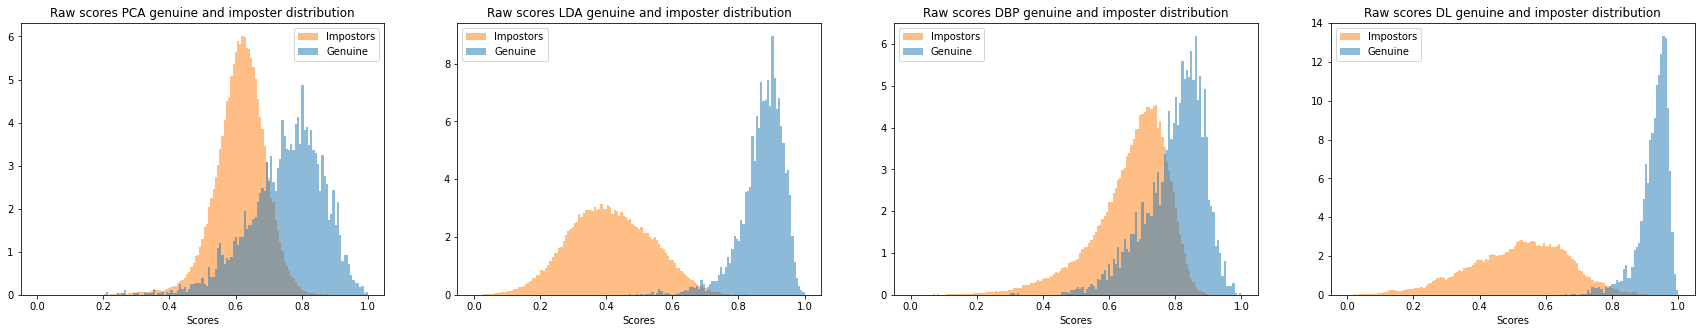

In [39]:
figure, axes = plt.subplots(1, 4, figsize=(30, 5))
# left index
metrics.plot_score_distribution(axes[0], imposter_df_pca, genuine_df_pca, "PCA genuine and imposter distribution")
metrics.plot_score_distribution(axes[1], imposter_df_lda, genuine_df_lda, "LDA genuine and imposter distribution")
metrics.plot_score_distribution(axes[2], imposter_df_lbp, genuine_df_lbp, "DBP genuine and imposter distribution")
metrics.plot_score_distribution(axes[3], imposter_df_dl, genuine_df_dl, "DL genuine and imposter distribution")

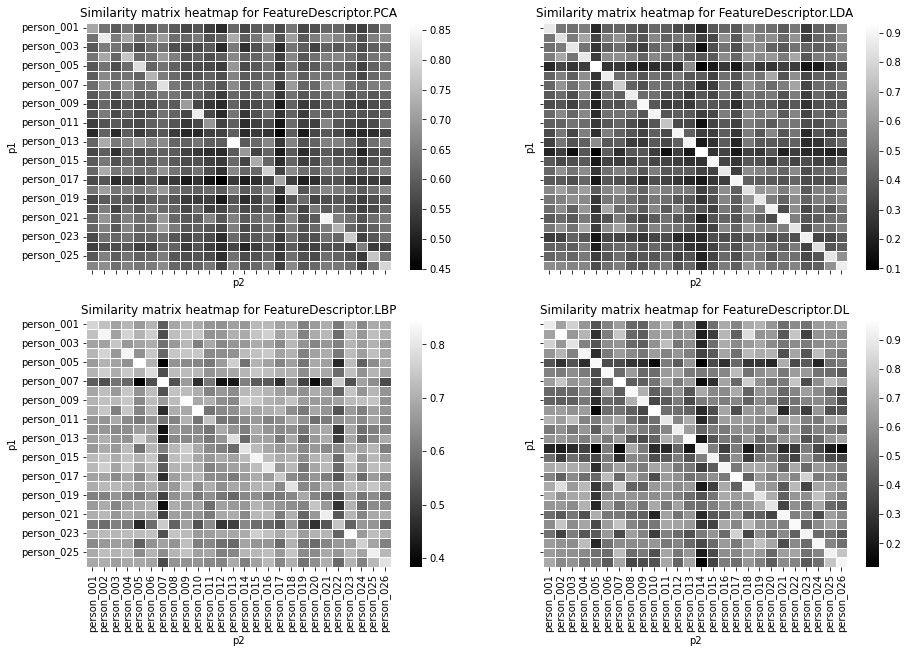

In [40]:
figure, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)
metrics.plot_sim_matrix(face_mat_pca, axes[0][0], FeatureDescriptor.PCA)
metrics.plot_sim_matrix(face_mat_lda, axes[0][1], FeatureDescriptor.LDA)
metrics.plot_sim_matrix(face_mat_lbp, axes[1][0], FeatureDescriptor.LBP)
metrics.plot_sim_matrix(face_mat_dl, axes[1][1], FeatureDescriptor.DL)

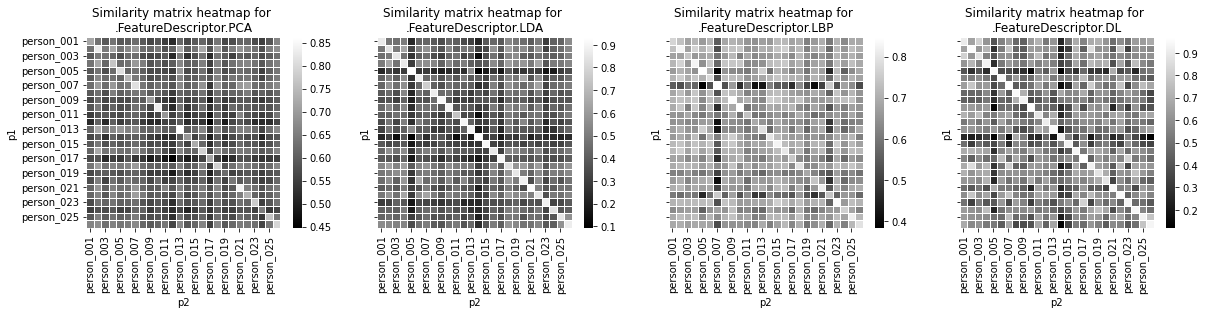

In [41]:
figure, axes = plt.subplots(1, 4, figsize=(20, 3.5), sharex=True, sharey=True)
metrics.plot_sim_matrix(face_mat_pca, axes[0], "\n.{}".format(FeatureDescriptor.PCA))
metrics.plot_sim_matrix(face_mat_lda, axes[1], "\n.{}".format(FeatureDescriptor.LDA))
metrics.plot_sim_matrix(face_mat_lbp, axes[2], "\n.{}".format(FeatureDescriptor.LBP))
metrics.plot_sim_matrix(face_mat_dl, axes[3], "\n.{}".format(FeatureDescriptor.DL))

<div class="alert alert-block alert-success">
<b>Q4: </b> Perform a full-on verification assessment based on the scores obtained. Interpret the results.
</div>

Hint: Calculate and plot the equal error rate. Plot the precision-recall curve and compute AUC and average precision. Interpret the results e.g. by explaining what aspect of the system performance is explored by each metric.

In [42]:
fpr_roc_pca, fnr_roc_pca, tpr_roc_pca, threshold_roc_pca = metrics.compute_fpr_fnr_tpr_from_roc_curve(score_pca, y_true_pca)
fpr_roc_lda, fnr_roc_lda, tpr_roc_lda, threshold_roc_lda = metrics.compute_fpr_fnr_tpr_from_roc_curve(score_lda, y_true_lda)
fpr_roc_lbp, fnr_roc_lbp, tpr_roc_lbp, threshold_roc_lbp = metrics.compute_fpr_fnr_tpr_from_roc_curve(score_lbp, y_true_lbp)
fpr_roc_dl, fnr_roc_dl, tpr_roc_dl, threshold_roc_dl = metrics.compute_fpr_fnr_tpr_from_roc_curve(score_dl, y_true_dl)

2022-05-28 13:03:31,729 - Computing roc curve
2022-05-28 13:03:31,755 - End roc curve computation
2022-05-28 13:03:31,756 - Computing roc curve
2022-05-28 13:03:31,779 - End roc curve computation
2022-05-28 13:03:31,780 - Computing roc curve
2022-05-28 13:03:31,803 - End roc curve computation
2022-05-28 13:03:31,804 - Computing roc curve
2022-05-28 13:03:31,826 - End roc curve computation


### ROC score

In [43]:
from sklearn.metrics import roc_auc_score
roc_au_pca = roc_auc_score(y_true=score_pca, y_score=y_true_pca)
roc_au_lda = roc_auc_score(y_true=score_lda, y_score=y_true_lda)
roc_au_lbp = roc_auc_score(y_true=score_lbp, y_score=y_true_lbp)
roc_au_dl = roc_auc_score(y_true=score_dl, y_score=y_true_dl)
print('ROC score for PCA : ', roc_au_pca)
print('ROC score for LDA : ', roc_au_lda)
print('ROC score for LBP : ', roc_au_lbp)
print('ROC score for DL : ', roc_au_dl)

ROC score for PCA :  0.8538758200843093
ROC score for LDA :  0.9984974967708357
ROC score for LBP :  0.84012165521448
ROC score for DL :  0.9985069701862566


### EER thresholds

In [44]:
eer_threshold_roc_pca = threshold_roc_pca[np.nanargmin(np.absolute((fnr_roc_pca - fpr_roc_pca)))]
eer_threshold_roc_lda = threshold_roc_lda[np.nanargmin(np.absolute((fnr_roc_lda - fpr_roc_lda)))]
eer_threshold_roc_lbp = threshold_roc_lbp[np.nanargmin(np.absolute((fnr_roc_lbp - fpr_roc_lbp)))]
eer_threshold_roc_dl = threshold_roc_dl[np.nanargmin(np.absolute((fnr_roc_dl - fpr_roc_dl)))]
print('EER threshold for PCA : ', eer_threshold_roc_pca)
print('EER threshold for LDA : ', eer_threshold_roc_lda)
print('EER threshold for LBP : ', eer_threshold_roc_lbp)
print('EER threshold for DL : ', eer_threshold_roc_dl)

EER threshold for PCA :  0.670415582493745
EER threshold for LDA :  0.6702372683719546
EER threshold for LBP :  0.745927988712306
EER threshold for DL :  0.7868242612282494


In [45]:
df_decision_threshold_fpr_fnr_pca = metrics.generate_dataframe(columns=['fpr', 'fnr', 'tpr'], data_list=[fpr_roc_pca, fnr_roc_pca, tpr_roc_pca], index_values=threshold_roc_pca)
df_decision_threshold_fpr_fnr_lda = metrics.generate_dataframe(columns=['fpr', 'fnr', 'tpr'], data_list=[fpr_roc_lda, fnr_roc_lda, tpr_roc_lda], index_values=threshold_roc_lda)
df_decision_threshold_fpr_fnr_lbp = metrics.generate_dataframe(columns=['fpr', 'fnr', 'tpr'], data_list=[fpr_roc_lbp, fnr_roc_lbp, tpr_roc_lbp], index_values=threshold_roc_lbp)
df_decision_threshold_fpr_fnr_dl = metrics.generate_dataframe(columns=['fpr', 'fnr', 'tpr'], data_list=[fpr_roc_dl, fnr_roc_dl, tpr_roc_dl], index_values=threshold_roc_dl)

In [46]:
result_roc_pca = df_decision_threshold_fpr_fnr_pca.loc[eer_threshold_roc_pca]
result_roc_lda = df_decision_threshold_fpr_fnr_lda.loc[eer_threshold_roc_lda]
result_roc_lbp = df_decision_threshold_fpr_fnr_lbp.loc[eer_threshold_roc_lbp]
result_roc_dl = df_decision_threshold_fpr_fnr_dl.loc[eer_threshold_roc_dl]

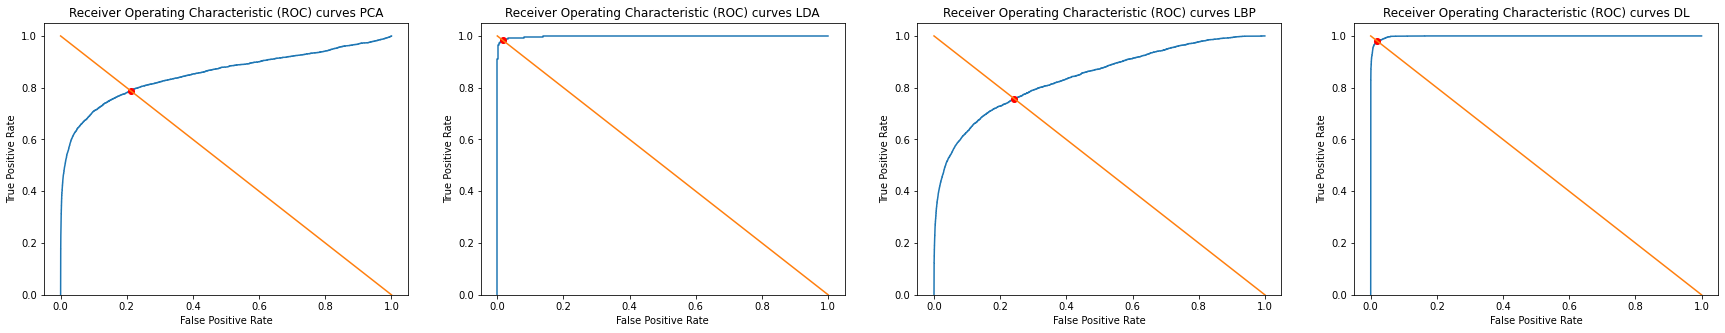

In [47]:
figure, axes = plt.subplots(1,4, figsize=(30, 5))
metrics.plot_eer_roc(fpr_roc_pca, tpr_roc_pca, axes[0], result_roc_pca, "PCA")
metrics.plot_eer_roc(fpr_roc_lda, tpr_roc_lda, axes[1], result_roc_lda, "LDA")
metrics.plot_eer_roc(fpr_roc_lbp, tpr_roc_lbp, axes[2], result_roc_lbp, "LBP")
metrics.plot_eer_roc(fpr_roc_dl, tpr_roc_dl, axes[3], result_roc_dl, "DL")

In [48]:
"""Calculate the decision threshold for which the sum of FRR and FAR is minimal."""
df_decision_threshold_fpr_fnr_pca["sum"] = df_decision_threshold_fpr_fnr_pca[['fnr', 'fpr']].sum(axis=1)
df_decision_threshold_fpr_fnr_lda["sum"] = df_decision_threshold_fpr_fnr_lda[['fnr', 'fpr']].sum(axis=1)
df_decision_threshold_fpr_fnr_lbp["sum"] = df_decision_threshold_fpr_fnr_lbp[['fnr', 'fpr']].sum(axis=1)
df_decision_threshold_fpr_fnr_dl["sum"] = df_decision_threshold_fpr_fnr_dl[['fnr', 'fpr']].sum(axis=1)

# df_decision_threshold_pca = df_decision_threshold_fpr_fnr_pca[df_decision_threshold_fpr_fnr_pca['tpr']>0.9]
# df_decision_threshold_lda = df_decision_threshold_fpr_fnr_lda[df_decision_threshold_fpr_fnr_lda['tpr']>0.9]
# df_decision_threshold_lbp = df_decision_threshold_fpr_fnr_lbp[df_decision_threshold_fpr_fnr_lbp['tpr']>0.9]
# df_decision_threshold_dl = df_decision_threshold_fpr_fnr_dl[df_decision_threshold_fpr_fnr_dl['tpr']>0.9]

print('Decision threshold where sum of frr and far are minimal')
print('threshold for PCA', df_decision_threshold_fpr_fnr_pca["sum"].idxmin())
print('threshold for LDA', df_decision_threshold_fpr_fnr_lda["sum"].idxmin())
print('threshold for LBP', df_decision_threshold_fpr_fnr_lbp["sum"].idxmin())
print('threshold for DL', df_decision_threshold_fpr_fnr_dl["sum"].idxmin())

Decision threshold where sum of frr and far are minimal
threshold for PCA 0.7021759222751864
threshold for LDA 0.6868490602243359
threshold for LBP 0.770238796990481
threshold for DL 0.791767176066947


### Precision recall curve

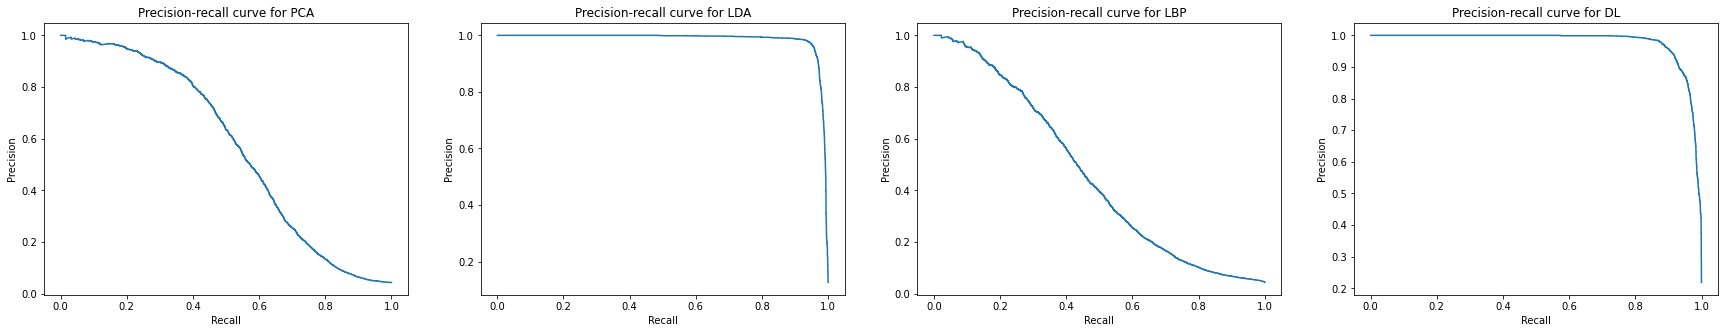

In [49]:
"""Calculate and plot the Precision-Recall curve for this system"""
figure, axes = plt.subplots(1, 4, figsize=(30, 5))
metrics.plot_recall_precision(recall_pca, precision_pca, axes[0], title_add="PCA")
metrics.plot_recall_precision(recall_lda, precision_lda, axes[1], title_add="LDA")
metrics.plot_recall_precision(recall_lbp, precision_lbp, axes[2], title_add="LBP")
metrics.plot_recall_precision(recall_dl, precision_dl, axes[3], title_add="DL")

#### Average precision score

In [50]:
"""Calculate the average precision scores"""
average_prec_score_pca = average_precision_score(y_true=score_pca, y_score=y_true_pca)
average_prec_score_lda = average_precision_score(y_true=score_lda, y_score=y_true_lda)
average_prec_score_lbp = average_precision_score(y_true=score_lbp, y_score=y_true_lbp)
average_prec_score_dl = average_precision_score(y_true=score_dl, y_score=y_true_dl)
print('Average precision score for PCA', average_prec_score_pca)
print('Average precision score for LDA', average_prec_score_lda)
print('Average precision score for LBP', average_prec_score_lbp)
print('Average precision score for DL', average_prec_score_dl)

Average precision score for PCA 0.569193527469802
Average precision score for LDA 0.9853387732625173
Average precision score for LBP 0.46043081437238187
Average precision score for DL 0.9783628694945233


### 2. Validation as identification system

<div class="alert alert-block alert-success">
<b>Q5: </b> Validate the systems in an identification scenario. 
</div>

Hint: Generate a Cumulative Matching Curve. Calculate and compare rank-1 performance among the four feature extraction techniques.

In [51]:
face_mat_lda

p2          person_001  person_002  person_003  person_004  person_005  \
p1                                                                       
person_001    0.858190    0.482878    0.462904    0.502984    0.228204   
person_002    0.482878    0.832485    0.498495    0.638965    0.323602   
person_003    0.462904    0.498495    0.849990    0.477264    0.269576   
person_004    0.502984    0.638965    0.477264    0.856741    0.291945   
person_005    0.228204    0.323602    0.269576    0.291945    0.932425   
person_006    0.416450    0.512578    0.406402    0.558653    0.268596   
person_007    0.430342    0.575778    0.461194    0.565554    0.286351   
person_008    0.391809    0.446568    0.353388    0.535500    0.227541   
person_009    0.351576    0.376465    0.305030    0.421481    0.200545   
person_010    0.441144    0.540354    0.430169    0.536877    0.244506   
person_011    0.407521    0.420739    0.469823    0.449076    0.283701   
person_012    0.339965    0.486580    0.324078    0.507044    0.250471   
person_013    0.310805    0.481036    0.366122    0.411789    0.552466   
person_014    0.216366    0.303237    0.143095    0.377604    0.094305   
person_015    0.386917    0.333615    0.356162    0.389977    0.178254   
person_016    0.432483    0.574233    0.473823    0.550355    0.277815   
person_017    0.388686    0.387884    0.352078    0.431008    0.172771   
person_018    0.536693    0.622386    0.532890    0.612736    0.395382   
person_019    0.485987    0.519135    0.559944    0.544589    0.282026   
person_020    0.457285    0.558652    0.417630    0.590406    0.268054   
person_021    0.395929    0.445136    0.389875    0.496989    0.304034   
person_022    0.489557    0.578847    0.469492    0.639571    0.291425   
person_023    0.291416    0.312647    0.418742    0.379460    0.165636   
person_024    0.415870    0.426370    0.407790    0.500073    0.188706   
person_025    0.425603    0.459819    0.426794    0.490456    0.294891   
person_026    0.554358    0.545245    0.526387    0.534651    0.346495   

p2          person_006  person_007  person_008  person_009  person_010  ...  \
p1                                                                      ...   
person_001    0.416450    0.430342    0.391809    0.351576    0.441144  ...   
person_002    0.512578    0.575778    0.446568    0.376465    0.540354  ...   
person_003    0.406402    0.461194    0.353388    0.305030    0.430169  ...   
person_004    0.558653    0.565554    0.535500    0.421481    0.536877  ...   
person_005    0.268596    0.286351    0.227541    0.200545    0.244506  ...   
person_006    0.873767    0.438509    0.465734    0.370690    0.464972  ...   
person_007    0.438509    0.770055    0.412981    0.361837    0.469330  ...   
person_008    0.465734    0.412981    0.871426    0.450515    0.458460  ...   
person_009    0.370690    0.361837    0.450515    0.907362    0.379825  ...   
person_010    0.464972    0.469330    0.458460    0.379825    0.893752  ...   
person_011    0.382371    0.429633    0.352813    0.290063    0.374486  ...   
person_012    0.509860    0.420021    0.374361    0.315876    0.405273  ...   
person_013    0.383781    0.410958    0.291060    0.287362    0.388216  ...   
person_014    0.400470    0.250760    0.382363    0.376476    0.298154  ...   
person_015    0.311002    0.294763    0.321091    0.376926    0.329577  ...   
person_016    0.463827    0.513478    0.472810    0.379565    0.504735  ...   
person_017    0.377127    0.355401    0.323826    0.242411    0.350922  ...   
person_018    0.534571    0.579290    0.494625    0.422278    0.557271  ...   
person_019    0.483640    0.505511    0.451484    0.404066    0.491495  ...   
person_020    0.641632    0.447072    0.494228    0.396395    0.538023  ...   
person_021    0.366700    0.506524    0.366625    0.321439    0.394404  ...   
person_022    0.560025    0.631788    0.501491    0.387960    0.529085  ...   
person_023    0.335905    0.324

In [52]:
ranked_pca = metrics.compute_cmc(face_mat_pca)
ranked_lda= metrics.compute_cmc(face_mat_lda)
ranked_lbp = metrics.compute_cmc(face_mat_lbp)
ranked_dl = metrics.compute_cmc(face_mat_dl)
ranked_lda

0    1.0
1    1.0
dtype: float64

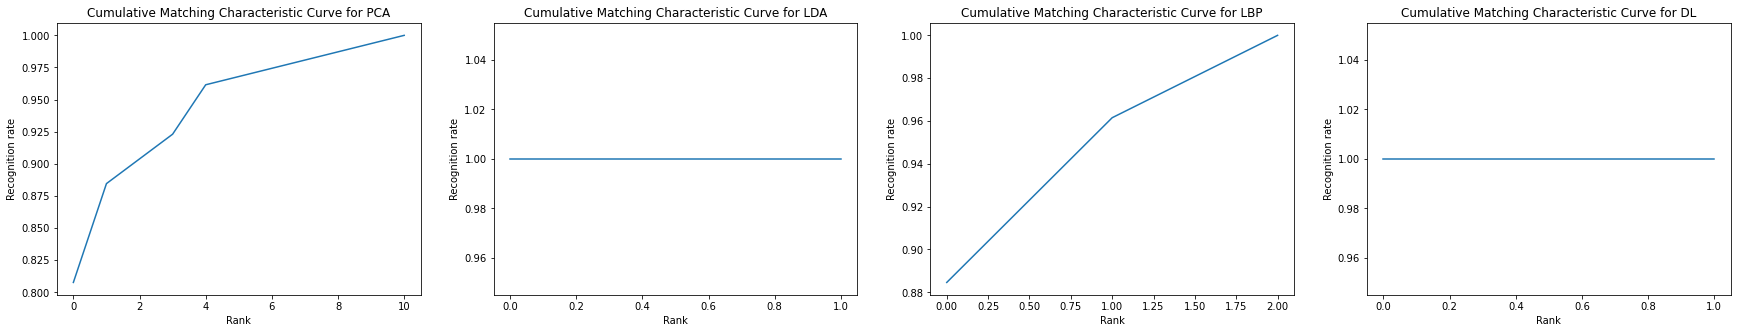

In [215]:
figure, axes = plt.subplots(1, 4, figsize=(30, 5))
metrics.plot_cmc(ranked_pca, axes[0], "PCA")
metrics.plot_cmc(ranked_lda, axes[1], "LDA")
metrics.plot_cmc(ranked_lbp, axes[2], "LBP")
metrics.plot_cmc(ranked_dl, axes[3], "DL")

## VI. Tasks
All tasks should be accompanied by a text providing information on the technique, steps, and the reasoning behind choosing the techniques.


### 1. Mandatory tasks
<b>The student should do all of the tasks indicated below</b>: 
1. Execute all the tasks indicated in the document above
2. Compare the 4 feature representations (LBP, PCA, LDA, DL using Siamese Networks) using the implemented validation metrics in Questions 2-5, and report on the performance. Please make it clear where in your report the comparison is made for each question. 

### 2. Tasks of choice
<b>The student should choose a number of tasks equivalent to <u>at least 3pts</u> from the list below (pts are not related to the grades)</b>. 

1. Evaluate your system on the other two datasets (AT&T, LFW). Feel free to subsample datasets if they are too memory-consuming on your system. (1pt.)
2. Implement 2 different face detectors and compare all techniques to the ground truth bounding boxes provided in <em>CalTechFacesDirs/ImageData.mat</em>. Look up the literature for methods to compare different face detectors. (1pt.)
3. Implement a classification-based scoring method, using an advanced classifier of your choice. Evaluate this system in an identification and verification scenario. (Hint: Follow steps introduced in section IV. Distance-based and classification-based scoring) (2pt.)
4. Experiment with the Siamese deep learning model by implementing a different loss function or a different distance calculation layer. (1pt.)
5. Pre-train your deep learning network on a different (larger) dataset and then fine-tune it with CALTECH and compare the results. (2pt.) 
6. Implement a different deep learning model* (2pt.)


e.g. performing task 4 and 5 is valid because their points sum up to 3. 

<em>Note: Indicate clearly which tasks you end up choosing and where we can find the implementations and/or results. </em>

[*] The implemented network has to be significantly different, adding some layers like batch normalisation, dropout, ... to the current network or increasing the kernel size, amount of filters and activation functions does not count.

#### 2.1 Evaluate your system on the other two datasets (AT&T, LFW). Feel free to subsample datasets if they are too memory-consuming on your system. (1pt.)

##### AT&T face database evaluation

In [53]:
att_faces = fetch_olivetti_faces(data_home='data')

# Convert grayscale to RGB dimension
att_faces.images = np.expand_dims(att_faces.images, axis=-1)
print("AT&T keys: ", att_faces.keys())
print("LFW image shape", att_faces.images.shape)
labels_att = []
for target in att_faces.target:
    pre = "" if target > 8 else "0"
    labels_att.append("person_0" + pre + str(target+1))
labels_att

AT&T keys:  dict_keys(['data', 'images', 'target', 'DESCR'])
LFW image shape (400, 64, 64, 1)


['person_001',
 'person_001',
 'person_001',
 'person_001',
 'person_001',
 'person_001',
 'person_001',
 'person_001',
 'person_001',
 'person_001',
 'person_002',
 'person_002',
 'person_002',
 'person_002',
 'person_002',
 'person_002',
 'person_002',
 'person_002',
 'person_002',
 'person_002',
 'person_003',
 'person_003',
 'person_003',
 'person_003',
 'person_003',
 'person_003',
 'person_003',
 'person_003',
 'person_003',
 'person_003',
 'person_004',
 'person_004',
 'person_004',
 'person_004',
 'person_004',
 'person_004',
 'person_004',
 'person_004',
 'person_004',
 'person_004',
 'person_005',
 'person_005',
 'person_005',
 'person_005',
 'person_005',
 'person_005',
 'person_005',
 'person_005',
 'person_005',
 'person_005',
 'person_006',
 'person_006',
 'person_006',
 'person_006',
 'person_006',
 'person_006',
 'person_006',
 'person_006',
 'person_006',
 'person_006',
 'person_007',
 'person_007',
 'person_007',
 'person_007',
 'person_007',
 'person_007',
 'person_0

In [54]:
att_imshape, n_samples_att, n_classes_att, n_features_att = utils.get_image_db_statistic(att_faces)

Total dataset size:
n_samples: 400
n_classes: 40
n_features: 4096
imshape : (64, 64, 1)


visualize some faces

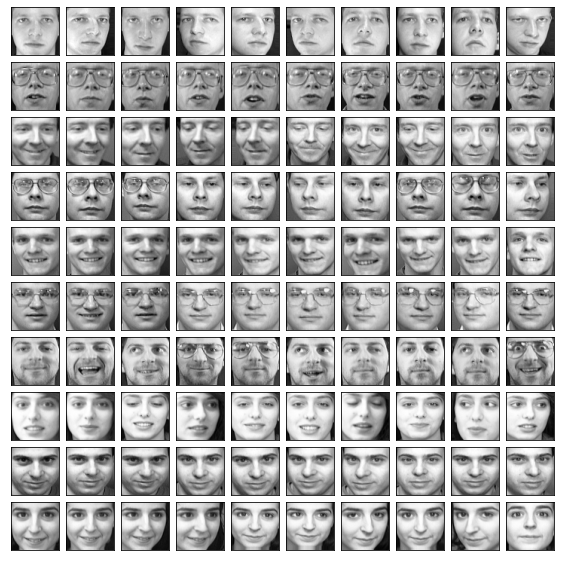

In [56]:
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(10, 10),
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, att_faces['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(np.mean(im, -1), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [97]:
facial_descriptor_att = FacialDescriptor(num_components, att_faces, n_samples_att, n_features_att, n_classes_att, att_imshape)

##### Get similarity scores
###### PCA

In [103]:
embedded_PCA_att, dist_metric_PCA_att = facial_descriptor_att.extract_face_representation(DESC=FeatureDescriptor.PCA)
df_scores_PCA_att, similarity_mat_pca_att = utils.compute_similarity_matrix(embedded_PCA_att, dist_metric_PCA_att, labels_att)
df_scores_PCA_att

False
num_components 25


100%|███████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 444.25it/s]


p1          p2  genuine     score  scores_norm
0       person_001  person_001        1  7.156501     0.465383
1       person_001  person_001        1  3.251076     0.779171
2       person_001  person_001        1  6.297410     0.534408
3       person_001  person_001        1  5.688528     0.583330
4       person_001  person_001        1  6.999084     0.478031
...            ...         ...      ...       ...          ...
159595  person_040  person_040        1  6.368465     0.528699
159596  person_040  person_040        1  6.435156     0.523341
159597  person_040  person_040        1  3.507979     0.758530
159598  person_040  person_040        1  5.627793     0.588210
159599  person_040  person_040        1  5.076917     0.632471

[159600 rows x 5 columns]

In [104]:
face_mat_pca_att = df_scores_PCA_att.pivot_table(index='p1', columns='p2',values='scores_norm',aggfunc = np.average)
face_mat_pca_att

p2          person_001  person_002  person_003  person_004  person_005  \
p1                                                                       
person_001    0.540991    0.500341    0.475408    0.474799    0.497234   
person_002    0.500341    0.705668    0.457972    0.570983    0.503105   
person_003    0.475408    0.457972    0.651550    0.552984    0.567128   
person_004    0.474799    0.570983    0.552984    0.652991    0.541921   
person_005    0.497234    0.503105    0.567128    0.541921    0.713800   
person_006    0.523762    0.534438    0.541749    0.549252    0.618184   
person_007    0.407737    0.408041    0.481643    0.456930    0.453280   
person_008    0.426007    0.418797    0.448306    0.435200    0.449253   
person_009    0.475844    0.472822    0.506044    0.542365    0.545411   
person_010    0.426903    0.405782    0.501666    0.483443    0.488864   
person_011    0.397503    0.416090    0.457808    0.459283    0.452241   
person_012    0.458458    0.453627    0.489093    0.505373    0.535462   
person_013    0.516535    0.536630    0.572979    0.571270    0.572837   
person_014    0.444217    0.453736    0.491796    0.453536    0.524065   
person_015    0.462358    0.516576    0.552135    0.636909    0.568116   
person_016    0.482581    0.498066    0.488467    0.508080    0.502505   
person_017    0.444380    0.438227    0.478655    0.443348    0.497500   
person_018    0.520173    0.503411    0.536514    0.571092    0.561709   
person_019    0.423270    0.500473    0.477051    0.506531    0.472869   
person_020    0.413442    0.458332    0.495094    0.503411    0.465912   
person_021    0.522713    0.537585    0.616074    0.625809    0.612802   
person_022    0.410016    0.488265    0.479182    0.485989    0.493587   
person_023    0.482250    0.495663    0.534807    0.606209    0.589392   
person_024    0.525039    0.501567    0.485772    0.513716    0.523686   
person_025    0.462567    0.525902    0.560290    0.547959    0.572560   
person_026    0.438306    0.499793    0.545906    0.579047    0.565288   
person_027    0.457940    0.493551    0.483396    0.485223    0.483504   
person_028    0.349045    0.373693    0.434669    0.420093    0.382484   
person_029    0.498020    0.491891    0.555775    0.544703    0.498683   
person_030    0.492964    0.522940    0.551608    0.571096    0.612904   
person_031    0.458436    0.516183    0.495409    0.486203    0.551925   
person_032    0.459542    0.506598    0.514728    0.513936    0.522623   
person_033    0.412344    0.385395    0.440674    0.460899    0.482487   
person_034    0.396162    0.460875    0.472490    0.452645    0.456796   
person_035    0.387206    0.371759    0.485005    0.407498    0.491664   
person_036    0.371629    0.391672    0.395758    0.428125    0.473779   
person_037    0.414401    0.417486    0.479260    0.463388    0.450769   
person_038    0.481516    0.518059    0.525635    0.545098    0.552482   
person_039    0.487659    0.506398    0.541495    0.524613    0.550671   
person_040    0.483599    0.505406    0.585602    0.567241    0.607754   

p2          person_006  person_007  person_008  person_009  person_010  ...  \
p1                                                                      ...   
person_001    0.523762    0.407737    0.426007    0.475844    0.426903  ...   
person_002    0.534438    0.408041    0.418797    0.472822    0.405782  ...   
person_003    0.541749    0.481643    0.448306    0.506044    0.501666  ...   
person_004    0.549252    0.456930    0.435200    0.542365    0.483443  ...   
person_005    0.618184    0.453280    0.449253    0.545411    0.488864  ...   
person_006    0.763726    0.481555    0.444464    0.547438    0.457927  ...   
person_007    0.481555    0.583959    0.344211    0.475226    0.389227  ...   
person_008    0.444464    0.344211    0.521325    0.405993    0.449978  ...   
person_009    0.547438    0.475226    0.405993    0.727953    0.513200  ...   
person_010    0.457927

In [105]:
genuine_df_pca_att = df_scores_PCA_att['scores_norm'][df_scores_PCA_att['genuine'] == 1]
imposter_df_pca_att = df_scores_PCA_att['scores_norm'][df_scores_PCA_att['genuine'] == 0]

###### LDA

In [106]:
embedded_LDA_att, dist_metric_LDA_att = facial_descriptor_att.extract_face_representation(DESC=FeatureDescriptor.LDA)
df_scores_LDA_att, similarity_mat_lda_att = utils.compute_similarity_matrix(embedded_LDA_att, dist_metric_LDA_att, labels_att)

face_mat_lda_att = df_scores_LDA_att.pivot_table(index='p1', columns='p2',values='scores_norm',aggfunc = np.average)

genuine_df_lda_att = df_scores_LDA_att['scores_norm'][df_scores_LDA_att['genuine'] == 1]
imposter_df_lda_att = df_scores_LDA_att['scores_norm'][df_scores_LDA_att['genuine'] == 0]

False


100%|███████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 449.66it/s]


###### LBP

In [107]:
embedded_LBP_att, dist_metric_LBP_att = facial_descriptor_att.extract_face_representation(DESC=FeatureDescriptor.LBP)
df_scores_LBP_att, similarity_mat_lbp_att = utils.compute_similarity_matrix(embedded_LBP_att, utils.chi2, labels_att)

face_mat_lbp_att = df_scores_LBP_att.pivot_table(index='p1', columns='p2',values='scores_norm',aggfunc = np.average)

genuine_df_lbp_att = df_scores_LBP_att['scores_norm'][df_scores_LBP_att['genuine'] == 1]
imposter_df_lbp_att = df_scores_LBP_att['scores_norm'][df_scores_LBP_att['genuine'] == 0]

ic| DESC: <FeatureDescriptor.LBP: 'LBP'>


False


100%|███████████████████████████████████████████████████████████████████████████████| 400/400 [00:01<00:00, 298.63it/s]


###### DL

In [108]:
embedded_DL_att, dist_metric_DL_att = facial_descriptor_att.extract_face_representation(DESC=FeatureDescriptor.DL, holdout_split=holdout_split)
df_scores_DL_att, similarity_mat_dl_att = utils.compute_similarity_matrix(embedded_DL_att, dist_metric_DL_att, labels_att)

face_mat_dl_att = df_scores_DL_att.pivot_table(index='p1', columns='p2',values='scores_norm',aggfunc = np.average)

genuine_df_dl_att = df_scores_DL_att['scores_norm'][df_scores_DL_att['genuine'] == 1]
imposter_df_dl_att = df_scores_DL_att['scores_norm'][df_scores_DL_att['genuine'] == 0]

True
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 model_4 (Functional)           (None, 128)          53489472    ['input_10[0][0]',               
                                                                  'input_11[0][0]']               
                                                                                                  
 lambda_4 (Lambda)              (None, 1)            0           ['model_4[0][0]',     

100%|███████████████████████████████████████████████████████████████████████████████| 400/400 [00:01<00:00, 215.99it/s]


##### evaluate

Compute F1 and accuracy scores for variable (and optimal) thresholds

In [109]:
score_pca_att, y_true_pca_att = df_scores_PCA_att['genuine'], df_scores_PCA_att['scores_norm']
score_lda_att, y_true_lda_att = df_scores_LDA_att['genuine'], df_scores_LDA_att['scores_norm']
score_lbp_att, y_true_lbp_att = df_scores_LBP_att['genuine'], df_scores_LBP_att['scores_norm']
score_dl_att, y_true_dl_att = df_scores_DL_att['genuine'], df_scores_DL_att['scores_norm']

df_classification_metrics_pca_att, precision_pca_att, recall_pca_att = metrics.get_f1_and_acc_dataframe(genuine_df_pca_att, imposter_df_pca_att, score_pca_att, y_true_pca_att)
df_classification_metrics_lda_att, precision_lda_att, recall_lda_att = metrics.get_f1_and_acc_dataframe(genuine_df_lda_att, imposter_df_lda_att, score_lda_att, y_true_lda_att)
df_classification_metrics_lbp_att, precision_lbp_att, recall_lbp_att = metrics.get_f1_and_acc_dataframe(genuine_df_lbp_att, imposter_df_lbp_att, score_lbp_att, y_true_lbp_att)
df_classification_metrics_dl_att, precision_dl_att, recall_dl_att = metrics.get_f1_and_acc_dataframe(genuine_df_dl_att, imposter_df_dl_att, score_dl_att, y_true_dl_att)

2022-05-26 14:31:34,637 - Computing precision recall
2022-05-26 14:31:34,670 - Computing accuracy
2022-05-26 14:31:38,407 - Generate dataframe
2022-05-26 14:31:38,416 - Computing precision recall
2022-05-26 14:31:38,438 - Computing accuracy
2022-05-26 14:31:38,885 - Generate dataframe
2022-05-26 14:31:38,889 - Computing precision recall
2022-05-26 14:31:38,913 - Computing accuracy
2022-05-26 14:31:42,358 - Generate dataframe
2022-05-26 14:31:42,367 - Computing precision recall
2022-05-26 14:31:42,390 - Computing accuracy
2022-05-26 14:31:43,220 - Generate dataframe


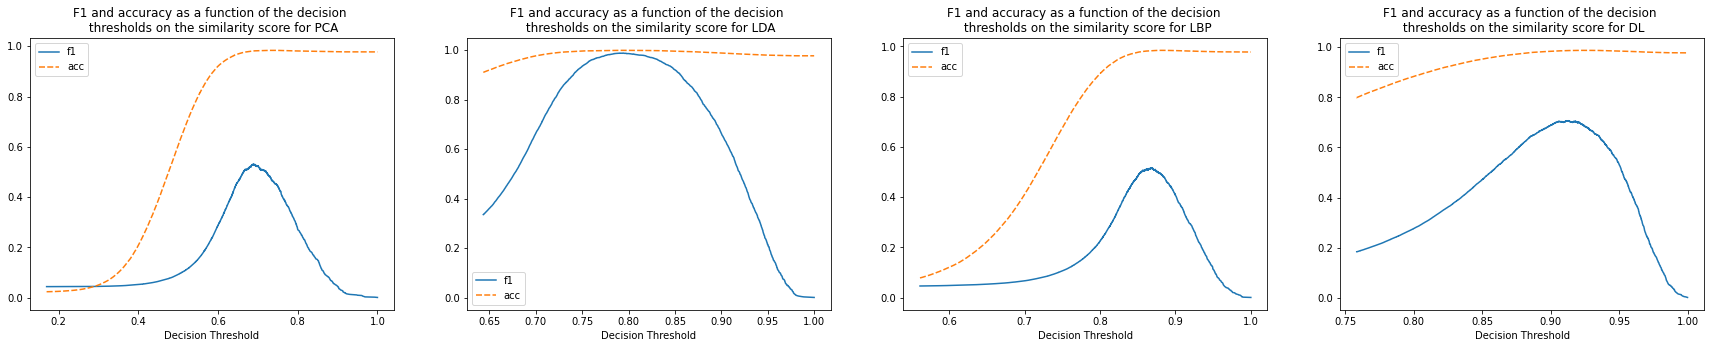

In [110]:
figure, axes = plt.subplots(1, 4, figsize=(30, 5))
metrics.plot_decision_threshold_f1_acc(df_classification_metrics_pca_att, "PCA", axes[0])
metrics.plot_decision_threshold_f1_acc(df_classification_metrics_lda_att, "LDA", axes[1])
metrics.plot_decision_threshold_f1_acc(df_classification_metrics_lbp_att, "LBP", axes[2])
metrics.plot_decision_threshold_f1_acc(df_classification_metrics_dl_att, "DL", axes[3])

Plot genuine and impostor scores
When comparing the different feature extractions/facial representations, discuss the difference in the overlap between genuine and imposter scores.

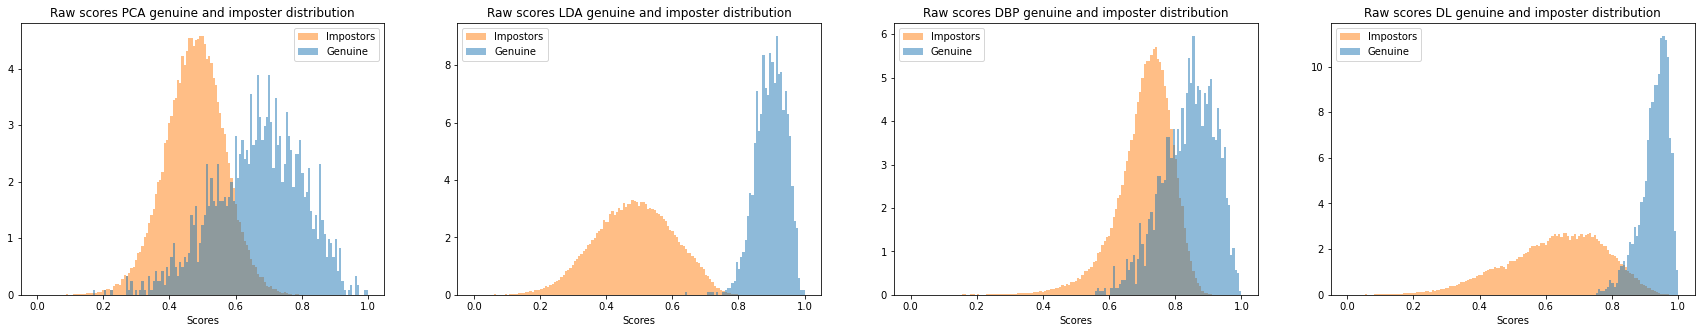

In [111]:
figure, axes = plt.subplots(1, 4, figsize=(30, 5))
# left index
metrics.plot_score_distribution(axes[0], imposter_df_pca_att, genuine_df_pca_att, "PCA genuine and imposter distribution")
metrics.plot_score_distribution(axes[1], imposter_df_lda_att, genuine_df_lda_att, "LDA genuine and imposter distribution")
metrics.plot_score_distribution(axes[2], imposter_df_lbp_att, genuine_df_lbp_att, "DBP genuine and imposter distribution")
metrics.plot_score_distribution(axes[3], imposter_df_dl_att, genuine_df_dl_att, "DL genuine and imposter distribution")

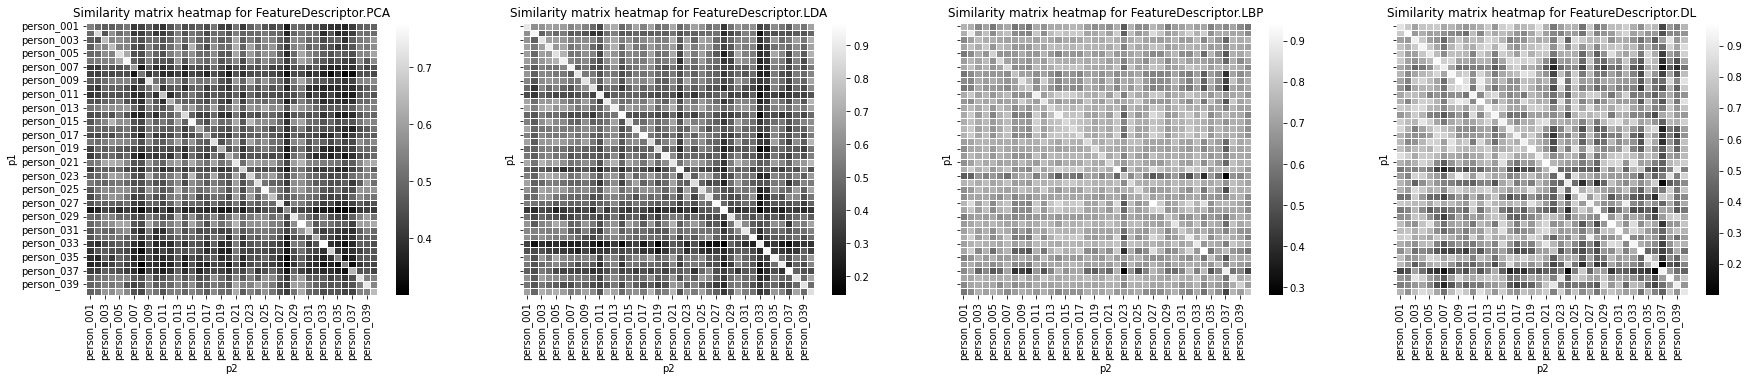

In [112]:
figure, axes = plt.subplots(1, 4, figsize=(30, 5), sharex=True, sharey=True)
metrics.plot_sim_matrix(face_mat_pca_att, axes[0], FeatureDescriptor.PCA)
metrics.plot_sim_matrix(face_mat_lda_att, axes[1], FeatureDescriptor.LDA)
metrics.plot_sim_matrix(face_mat_lbp_att, axes[2], FeatureDescriptor.LBP)
metrics.plot_sim_matrix(face_mat_dl_att, axes[3], FeatureDescriptor.DL)

Perform a full-on verification assessment based on the scores obtained. Interpret the results.

In [113]:
fpr_roc_pca_att, fnr_roc_pca_att, tpr_roc_pca_att, threshold_roc_pca_att = metrics.compute_fpr_fnr_tpr_from_roc_curve(score_pca_att, y_true_pca_att)
fpr_roc_lda_att, fnr_roc_lda_att, tpr_roc_lda_att, threshold_roc_lda_att = metrics.compute_fpr_fnr_tpr_from_roc_curve(score_lda_att, y_true_lda_att)
fpr_roc_lbp_att, fnr_roc_lbp_att, tpr_roc_lbp_att, threshold_roc_lbp_att = metrics.compute_fpr_fnr_tpr_from_roc_curve(score_lbp_att, y_true_lbp_att)
fpr_roc_dl_att, fnr_roc_dl_att, tpr_roc_dl_att, threshold_roc_dl_att = metrics.compute_fpr_fnr_tpr_from_roc_curve(score_dl_att, y_true_dl_att)

2022-05-26 14:31:57,806 - Computing roc curve
2022-05-26 14:31:57,828 - End roc curve computation
2022-05-26 14:31:57,829 - Computing roc curve
2022-05-26 14:31:57,855 - End roc curve computation
2022-05-26 14:31:57,855 - Computing roc curve
2022-05-26 14:31:57,877 - End roc curve computation
2022-05-26 14:31:57,877 - Computing roc curve
2022-05-26 14:31:57,900 - End roc curve computation


In [114]:
roc_au_pca_att = roc_auc_score(y_true=score_pca_att, y_score=y_true_pca_att)
roc_au_lda_att = roc_auc_score(y_true=score_lda_att, y_score=y_true_lda_att)
roc_au_lbp_att = roc_auc_score(y_true=score_lbp_att, y_score=y_true_lbp_att)
roc_au_dl_att = roc_auc_score(y_true=score_dl_att, y_score=y_true_dl_att)
print('ROC score for PCA : ', roc_au_pca_att)
print('ROC score for LDA : ', roc_au_lda_att)
print('ROC score for LBP : ', roc_au_lbp_att)
print('ROC score for DL : ', roc_au_dl_att)

ROC score for PCA :  0.881664188034188
ROC score for LDA :  0.9999104415954416
ROC score for LBP :  0.878029594017094
ROC score for DL :  0.9890507905982906


In [115]:
eer_threshold_roc_pca_att = threshold_roc_pca_att[np.nanargmin(np.absolute((fnr_roc_pca_att - fpr_roc_pca_att)))]
eer_threshold_roc_lda_att = threshold_roc_lda_att[np.nanargmin(np.absolute((fnr_roc_lda_att - fpr_roc_lda_att)))]
eer_threshold_roc_lbp_att = threshold_roc_lbp_att[np.nanargmin(np.absolute((fnr_roc_lbp_att - fpr_roc_lbp_att)))]
eer_threshold_roc_dl_att = threshold_roc_dl_att[np.nanargmin(np.absolute((fnr_roc_dl_att - fpr_roc_dl_att)))]
print('EER threshold for PCA : ', eer_threshold_roc_pca_att)
print('EER threshold for LDA : ', eer_threshold_roc_lda_att)
print('EER threshold for LBP : ', eer_threshold_roc_lbp_att)
print('EER threshold for DL : ', eer_threshold_roc_dl_att)

EER threshold for PCA :  0.550335825284994
EER threshold for LDA :  0.758253999198583
EER threshold for LBP :  0.7737729167313396
EER threshold for DL :  0.8436925805485778


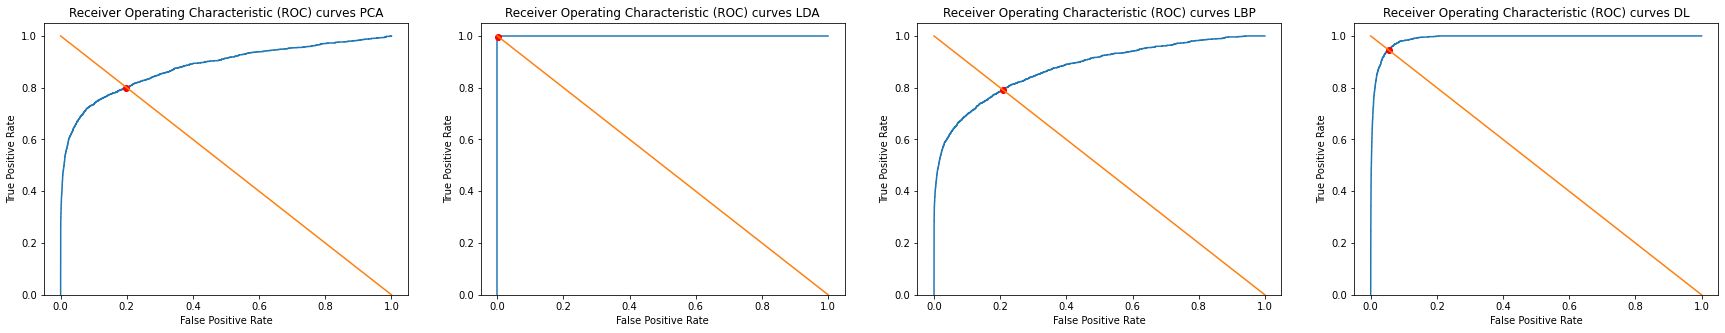

In [116]:
df_decision_threshold_fpr_fnr_pca_att = metrics.generate_dataframe(columns=['fpr', 'fnr', 'tpr'], data_list=[fpr_roc_pca_att, fnr_roc_pca_att, tpr_roc_pca_att], index_values=threshold_roc_pca_att)
df_decision_threshold_fpr_fnr_lda_att = metrics.generate_dataframe(columns=['fpr', 'fnr', 'tpr'], data_list=[fpr_roc_lda_att, fnr_roc_lda_att, tpr_roc_lda_att], index_values=threshold_roc_lda_att)
df_decision_threshold_fpr_fnr_lbp_att = metrics.generate_dataframe(columns=['fpr', 'fnr', 'tpr'], data_list=[fpr_roc_lbp_att, fnr_roc_lbp_att, tpr_roc_lbp_att], index_values=threshold_roc_lbp_att)
df_decision_threshold_fpr_fnr_dl_att = metrics.generate_dataframe(columns=['fpr', 'fnr', 'tpr'], data_list=[fpr_roc_dl_att, fnr_roc_dl_att, tpr_roc_dl_att], index_values=threshold_roc_dl_att)

result_roc_pca_att = df_decision_threshold_fpr_fnr_pca_att.loc[eer_threshold_roc_pca_att]
result_roc_lda_att = df_decision_threshold_fpr_fnr_lda_att.loc[eer_threshold_roc_lda_att]
result_roc_lbp_att = df_decision_threshold_fpr_fnr_lbp_att.loc[eer_threshold_roc_lbp_att]
result_roc_dl_att = df_decision_threshold_fpr_fnr_dl_att.loc[eer_threshold_roc_dl_att]

figure, axes = plt.subplots(1, 4, figsize=(30, 5))
metrics.plot_eer_roc(fpr_roc_pca_att, tpr_roc_pca_att, axes[0], result_roc_pca_att, "PCA")
metrics.plot_eer_roc(fpr_roc_lda_att, tpr_roc_lda_att, axes[1], result_roc_lda_att, "LDA")
metrics.plot_eer_roc(fpr_roc_lbp_att, tpr_roc_lbp_att, axes[2], result_roc_lbp_att, "LBP")
metrics.plot_eer_roc(fpr_roc_dl_att, tpr_roc_dl_att, axes[3], result_roc_dl_att, "DL")

In [117]:
"""Calculate the decision threshold for which the sum of FRR and FAR is minimal."""
df_decision_threshold_fpr_fnr_pca_att["sum"] = df_decision_threshold_fpr_fnr_pca_att[['fpr', 'fnr']].sum(axis=1)
df_decision_threshold_fpr_fnr_lda_att["sum"] = df_decision_threshold_fpr_fnr_lda_att[['fpr', 'fnr']].sum(axis=1)
df_decision_threshold_fpr_fnr_lbp_att["sum"] = df_decision_threshold_fpr_fnr_lbp_att[['fpr', 'fnr']].sum(axis=1)
df_decision_threshold_fpr_fnr_dl_att["sum"] = df_decision_threshold_fpr_fnr_dl_att[['fpr', 'fnr']].sum(axis=1)

print('Decision threshold where sum of frr and far are minimal')
print('threshold for PCA', df_decision_threshold_fpr_fnr_pca_att["sum"].idxmin())
print('threshold for LDA', df_decision_threshold_fpr_fnr_lda_att["sum"].idxmin())
print('threshold for LBP', df_decision_threshold_fpr_fnr_lbp_att["sum"].idxmin())
print('threshold for DL', df_decision_threshold_fpr_fnr_dl_att["sum"].idxmin())

Decision threshold where sum of frr and far are minimal
threshold for PCA 0.5975112997743732
threshold for LDA 0.758253999198583
threshold for LBP 0.7904228343353987
threshold for DL 0.8304639352917621


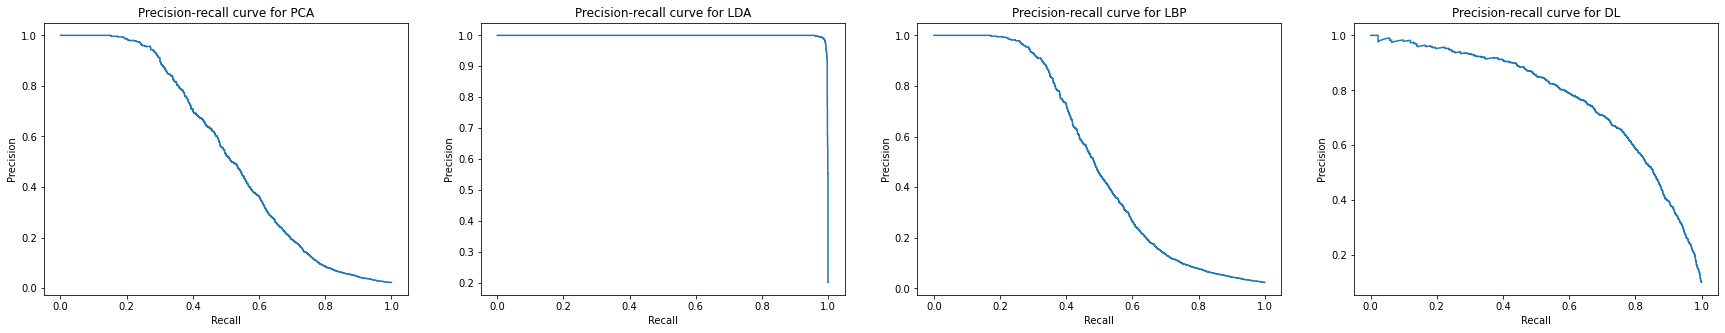

In [118]:
"""Calculate and plot the Precision-Recall curve for this system"""
figure, axes = plt.subplots(1, 4, figsize=(30, 5))
metrics.plot_recall_precision(recall_pca_att, precision_pca_att, axes[0], title_add="PCA")
metrics.plot_recall_precision(recall_lda_att, precision_lda_att, axes[1], title_add="LDA")
metrics.plot_recall_precision(recall_lbp_att, precision_lbp_att, axes[2], title_add="LBP")
metrics.plot_recall_precision(recall_dl_att, precision_dl_att, axes[3], title_add="DL")

In [119]:
"""Calculate the average precision scores"""
average_prec_score_pca_att = average_precision_score(y_true=score_pca_att, y_score=y_true_pca_att)
average_prec_score_lda_att = average_precision_score(y_true=score_lda_att, y_score=y_true_lda_att)
average_prec_score_lbp_att = average_precision_score(y_true=score_lbp_att, y_score=y_true_lbp_att)
average_prec_score_dl_att = average_precision_score(y_true=score_dl_att, y_score=y_true_dl_att)
print('Average precision score for PCA', average_prec_score_pca_att)
print('Average precision score for LDA', average_prec_score_lda_att)
print('Average precision score for LBP', average_prec_score_lbp_att)
print('Average precision score for DL', average_prec_score_dl_att)

Average precision score for PCA 0.5335897755228096
Average precision score for LDA 0.9983240407293815
Average precision score for LBP 0.5143816590454713
Average precision score for DL 0.771019278563091


Validate the systems in an identification scenario.

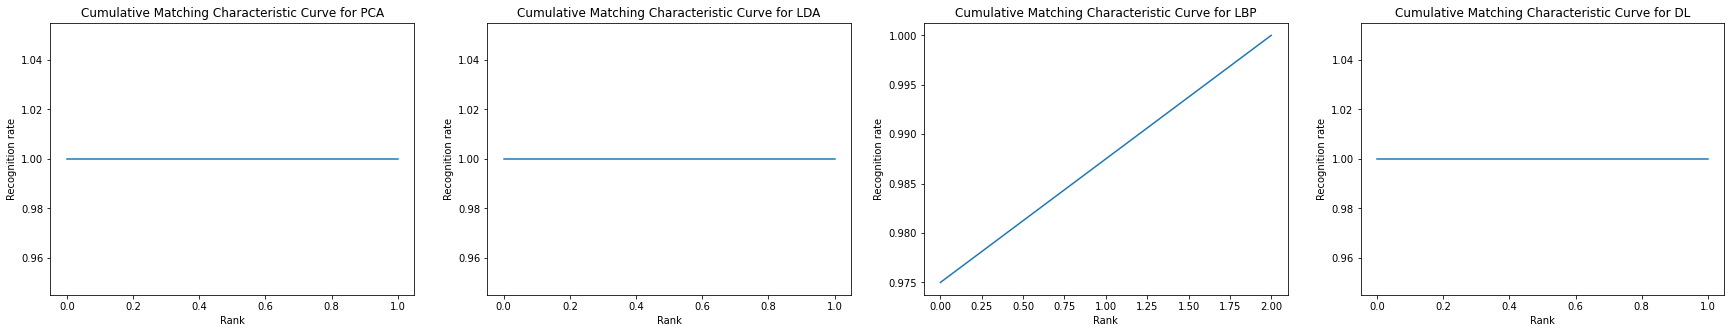

In [120]:
ranked_pca_att = metrics.compute_cmc(face_mat_pca_att)
ranked_lda_att= metrics.compute_cmc(face_mat_lda_att)
ranked_lbp_att = metrics.compute_cmc(face_mat_lbp_att)
ranked_dl_att = metrics.compute_cmc(face_mat_dl_att)

figure, axes = plt.subplots(1, 4, figsize=(30, 5))
metrics.plot_cmc(ranked_pca_att, axes[0], "PCA")
metrics.plot_cmc(ranked_lda_att, axes[1], "LDA")
metrics.plot_cmc(ranked_lbp_att, axes[2], "LBP")
metrics.plot_cmc(ranked_dl_att, axes[3], "DL")

##### Labeled faces in the Wild (lfw) database

In [122]:
lfw_faces = fetch_lfw_people(data_home='data', min_faces_per_person=40, slice_=(slice(78, 172), slice(78, 172)))
# Convert grayscale to RGB dimension
lfw_faces.images = np.expand_dims(lfw_faces.images, axis=-1)
print("LFW keys: ", lfw_faces.keys())
print("LFW image shape", lfw_faces.images.shape)
# for key in lfw_faces.keys():
#     print(lfw_faces[key][0:1])
labels_lfw = []
for target in lfw_faces.target:
    labels_lfw.append(lfw_faces.target_names[target])

LFW keys:  dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])
LFW image shape (1867, 47, 47, 1)


In [123]:
lfw_imshape, n_samples_lfw, n_classes_lfw, n_features_lfw = utils.get_image_db_statistic(lfw_faces)

Total dataset size:
n_samples: 1867
n_classes: 19
n_features: 2209
imshape : (47, 47, 1)


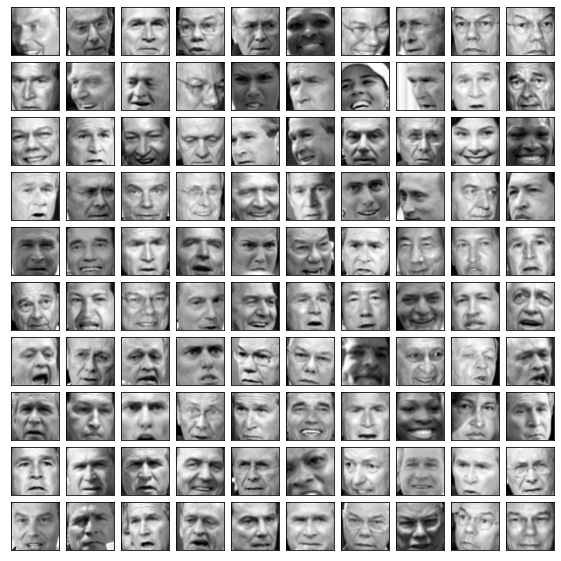

In [124]:
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(10, 10),
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, lfw_faces['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(np.mean(im, -1), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [125]:
facial_descriptor_lfw = FacialDescriptor(num_components, lfw_faces, n_samples_lfw, n_features_lfw, n_classes_lfw, lfw_imshape)

##### Get similarity scores
###### PCA

In [126]:
embedded_PCA_lfw, dist_metric_PCA_lfw = facial_descriptor_lfw.extract_face_representation(DESC=FeatureDescriptor.PCA)
df_scores_PCA_lfw, similarity_mat_pca_lfw = utils.compute_similarity_matrix(embedded_PCA_lfw, dist_metric_PCA_lfw, labels_lfw)
df_scores_PCA_lfw

num_components 25


100%|██████████████████████████████████████████████████████████████████████████████| 1867/1867 [00:24<00:00, 77.06it/s]


p1                       p2  genuine     score  \
0                     Tony Blair               Tony Blair        1  5.871608   
1                     Tony Blair            George W Bush        0  5.253050   
2                     Tony Blair             Colin Powell        0  5.998463   
3                     Tony Blair          Donald Rumsfeld        0  5.749689   
4                     Tony Blair          Serena Williams        0  8.845630   
...                          ...                      ...      ...       ...   
3483817  Gloria Macapagal Arroyo        Gerhard Schroeder        0  7.556830   
3483818  Gloria Macapagal Arroyo  Gloria Macapagal Arroyo        1  7.399401   
3483819  Gloria Macapagal Arroyo            Jean Chretien        0  8.258447   
3483820  Gloria Macapagal Arroyo            George W Bush        0  7.550112   
3483821  Gloria Macapagal Arroyo        Junichiro Koizumi        0  8.135035   

         scores_norm  
0           0.665192  
1           0.703206  
2           0.657396  
3           0.672685  
4           0.482423  
...              ...  
3483817     0.561626  
3483818     0.571301  
3483819     0.518509  
3483820     0.562039  
3483821     0.526093  

[3483822 rows x 5 columns]

In [127]:
face_mat_pca_lfw = df_scores_PCA_lfw.pivot_table(index='p1', columns='p2',values='scores_norm',aggfunc = np.average)

genuine_df_pca_lfw = df_scores_PCA_lfw['scores_norm'][df_scores_PCA_lfw['genuine'] == 1]
imposter_df_pca_lfw = df_scores_PCA_lfw['scores_norm'][df_scores_PCA_lfw['genuine'] == 0]

In [128]:
face_mat_pca_lfw

p2                         Ariel Sharon  Arnold Schwarzenegger  Colin Powell  \
p1                                                                             
Ariel Sharon                   0.620933               0.580705      0.611237   
Arnold Schwarzenegger          0.580705               0.591206      0.595161   
Colin Powell                   0.611237               0.595161      0.640405   
Donald Rumsfeld                0.612150               0.599910      0.631103   
George W Bush                  0.600683               0.588875      0.614135   
Gerhard Schroeder              0.596545               0.599111      0.616411   
Gloria Macapagal Arroyo        0.531299               0.563462      0.559548   
Hugo Chavez                    0.588689               0.598882      0.607033   
Jacques Chirac                 0.602013               0.595551      0.624617   
Jean Chretien                  0.587798               0.570063      0.598942   
Jennifer Capriati              0.550017               0.556979      0.559840   
John Ashcroft                  0.626686               0.607070      0.639304   
Junichiro Koizumi              0.603291               0.596257      0.619999   
Laura Bush                     0.517812               0.532655      0.538784   
Lleyton Hewitt                 0.582486               0.553636      0.578290   
Luiz Inacio Lula da Silva      0.593916               0.591142      0.599739   
Serena Williams                0.544296               0.540800      0.564199   
Tony Blair                     0.601848               0.599075      0.620461   
Vladimir Putin                 0.610479               0.589002      0.619544   

p2                         Donald Rumsfeld  George W Bush  Gerhard Schroeder  \
p1                                                                             
Ariel Sharon                      0.612150       0.600683           0.596545   
Arnold Schwarzenegger             0.599910       0.588875           0.599111   
Colin Powell                      0.631103       0.614135           0.616411   
Donald Rumsfeld                   0.650148       0.622462           0.622291   
George W Bush                     0.622462       0.621708           0.607052   
Gerhard Schroeder                 0.622291       0.607052           0.625402   
Gloria Macapagal Arroyo           0.553564       0.555051           0.573913   
Hugo Chavez                       0.605863       0.604172           0.614351   
Jacques Chirac                    0.620153       0.607896           0.615917   
Jean Chretien                     0.612764       0.584210           0.593531   
Jennifer Capriati                 0.567673       0.566619           0.566343   
John Ashcroft                     0.635586       0.629607           0.633989   
Junichiro Koizumi                 0.604818       0.611061           0.608753   
Laura Bush                        0.535907       0.547283           0.555170   
Lleyton Hewitt                    0.584373       0.585115           0.567649   
Luiz Inacio Lula da Silva         0.609484       0.600035           0.608075   
Serena Williams                   0.554077       0.543394           0.547082   
Tony Blair                        0.623796       0.611735           0.618829   
Vladimir Putin                    0.619888       0.605215           0.604632   

p2                         Gloria Macapagal Arroyo  Hugo Chavez  \
p1                                                                
Ariel Sharon                              0.531299     0.588689   
Arnold Schwarzenegger                     0.563462     0.598882   
Colin Powell                              0.559548     0.607033   
Donald Rumsfeld                           0.553564     0.605863   
George W Bush                             0.555051     0.604172   
Gerhard Schroeder                         0.573913     0.614351   
Gloria Macapagal Arroyo                   0.633436     0.593143   
Hugo Chavez                        

###### LDA

In [129]:
embedded_LDA_lfw, dist_metric_LDA_lfw = facial_descriptor_lfw.extract_face_representation(DESC=FeatureDescriptor.LDA)
df_scores_LDA_lfw, similarity_mat_lda_lfw = utils.compute_similarity_matrix(embedded_LDA_lfw, dist_metric_LDA_lfw, labels_lfw)

face_mat_lda_lfw = df_scores_LDA_lfw.pivot_table(index='p1', columns='p2',values='scores_norm',aggfunc = np.average)

genuine_df_lda_lfw = df_scores_LDA_lfw['scores_norm'][df_scores_LDA_lfw['genuine'] == 1]
imposter_df_lda_lfw = df_scores_LDA_lfw['scores_norm'][df_scores_LDA_lfw['genuine'] == 0]

100%|██████████████████████████████████████████████████████████████████████████████| 1867/1867 [00:23<00:00, 78.00it/s]


###### LBP

In [130]:
embedded_LBP_lfw, dist_metric_LBP_lfw = facial_descriptor_lfw.extract_face_representation(DESC=FeatureDescriptor.LBP)
df_scores_LBP_lfw, similarity_mat_lbp_lfw = utils.compute_similarity_matrix(embedded_LBP_lfw, utils.chi2, labels_lfw)

face_mat_lbp_lfw = df_scores_LBP_lfw.pivot_table(index='p1', columns='p2',values='scores_norm',aggfunc = np.average)

genuine_df_lbp_lfw = df_scores_LBP_lfw['scores_norm'][df_scores_LBP_lfw['genuine'] == 1]
imposter_df_lbp_lfw = df_scores_LBP_lfw['scores_norm'][df_scores_LBP_lfw['genuine'] == 0]

ic| DESC: <FeatureDescriptor.LBP: 'LBP'>
100%|██████████████████████████████████████████████████████████████████████████████| 1867/1867 [00:36<00:00, 51.77it/s]


###### DL

In [131]:
embedded_DL_lfw, dist_metric_DL_lfw = facial_descriptor_lfw.extract_face_representation(DESC=FeatureDescriptor.DL, holdout_split=holdout_split)
df_scores_DL_lfw, similarity_mat_dl_lfw = utils.compute_similarity_matrix(embedded_DL_lfw, dist_metric_DL_lfw, labels_lfw)
#
face_mat_dl_lfw = df_scores_DL_lfw.pivot_table(index='p1', columns='p2',values='scores_norm',aggfunc = np.average)

genuine_df_dl_lfw = df_scores_DL_lfw['scores_norm'][df_scores_DL_lfw['genuine'] == 1]
imposter_df_dl_lfw = df_scores_DL_lfw['scores_norm'][df_scores_DL_lfw['genuine'] == 0]

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 47, 47, 1)]  0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 47, 47, 1)]  0           []                               
                                                                                                  
 sequential_2 (Sequential)      (None, 128)          894400      ['input_7[0][0]',                
                                                                  'input_8[0][0]']                
                                                                                                  
 lambda_2 (Lambda)              (None, 1)            0           ['sequential_2[0][0]',     

100%|██████████████████████████████████████████████████████████████████████████████| 1867/1867 [00:23<00:00, 78.80it/s]


##### evaluate

Compute F1 and accuracy scores for variable (and optimal) thresholds

In [132]:
score_pca_lfw, y_true_pca_lfw = df_scores_PCA_lfw['genuine'], df_scores_PCA_lfw['scores_norm']
score_lda_lfw, y_true_lda_lfw = df_scores_LDA_lfw['genuine'], df_scores_LDA_lfw['scores_norm']
score_lbp_lfw, y_true_lbp_lfw = df_scores_LBP_lfw['genuine'], df_scores_LBP_lfw['scores_norm']
score_dl_lfw, y_true_dl_lfw = df_scores_DL_lfw['genuine'], df_scores_DL_lfw['scores_norm']

In [133]:
df_classification_metrics_pca_lfw, precision_pca_lfw, recall_pca_lfw = metrics.get_f1_and_acc_dataframe(genuine_df_pca_lfw, imposter_df_pca_lfw, score_pca_lfw, y_true_pca_lfw, slice=True)
df_classification_metrics_lda_lfw, precision_lda_lfw, recall_lda_lfw = metrics.get_f1_and_acc_dataframe(genuine_df_lda_lfw, imposter_df_lda_lfw, score_lda_lfw, y_true_lda_lfw)
df_classification_metrics_lbp_lfw, precision_lbp_lfw, recall_lbp_lfw = metrics.get_f1_and_acc_dataframe(genuine_df_lbp_lfw, imposter_df_lbp_lfw, score_lbp_lfw, y_true_lbp_lfw, slice=True)
df_classification_metrics_dl_lfw, precision_dl_lfw, recall_dl_lfw = metrics.get_f1_and_acc_dataframe(genuine_df_dl_lfw, imposter_df_dl_lfw, score_dl_lfw, y_true_dl_lfw, slice=True)

2022-05-28 14:53:00,715 - Computing precision recall
2022-05-28 14:53:01,511 - Computing accuracy
2022-05-28 14:53:02,744 - Generate dataframe
2022-05-28 14:53:02,747 - Computing precision recall
2022-05-28 14:53:03,462 - Computing accuracy
2022-05-28 15:01:14,300 - Generate dataframe
2022-05-28 15:01:14,319 - Computing precision recall
2022-05-28 15:01:15,054 - Computing accuracy
2022-05-28 15:01:16,258 - Generate dataframe
2022-05-28 15:01:16,260 - Computing precision recall
2022-05-28 15:01:17,023 - Computing accuracy
2022-05-28 15:01:18,254 - Generate dataframe


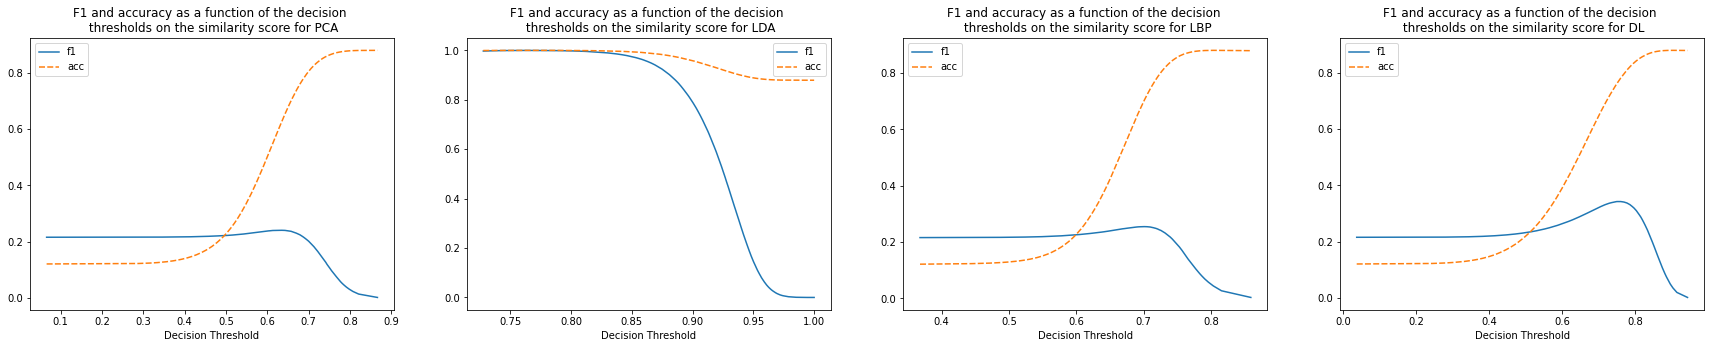

In [134]:
figure, axes = plt.subplots(1, 4, figsize=(30, 5))
metrics.plot_decision_threshold_f1_acc(df_classification_metrics_pca_lfw, "PCA", axes[0])
metrics.plot_decision_threshold_f1_acc(df_classification_metrics_lda_lfw, "LDA", axes[1])
metrics.plot_decision_threshold_f1_acc(df_classification_metrics_lbp_lfw, "LBP", axes[2])
metrics.plot_decision_threshold_f1_acc(df_classification_metrics_dl_lfw, "DL", axes[3])

Plot genuine and impostor scores
When comparing the different feature extractions/facial representations, discuss the difference in the overlap between genuine and imposter scores.

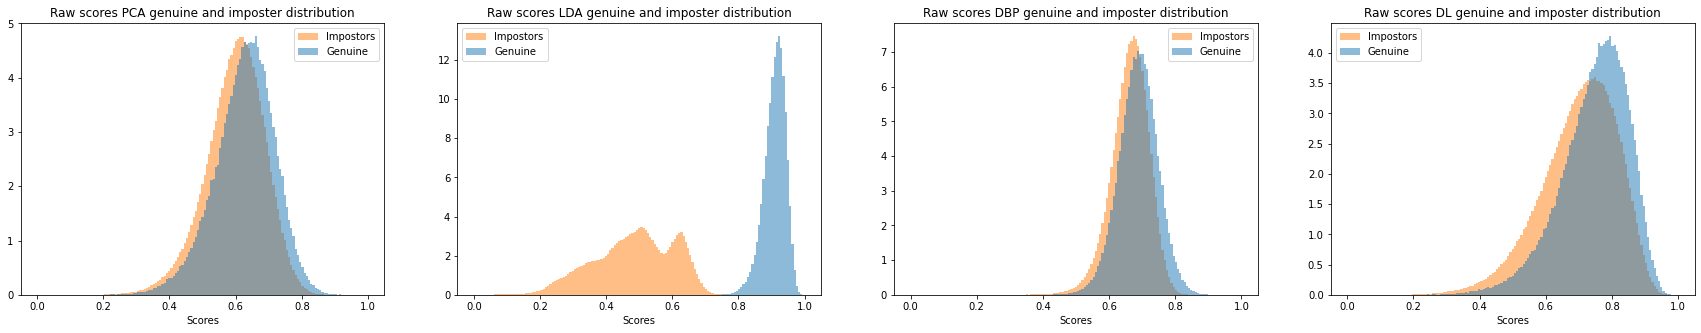

In [157]:
figure, axes = plt.subplots(1, 4, figsize=(30, 5))
# left index
metrics.plot_score_distribution(axes[0], imposter_df_pca_lfw, genuine_df_pca_lfw, "PCA genuine and imposter distribution")
metrics.plot_score_distribution(axes[1], imposter_df_lda_lfw, genuine_df_lda_lfw, "LDA genuine and imposter distribution")
metrics.plot_score_distribution(axes[2], imposter_df_lbp_lfw, genuine_df_lbp_lfw, "DBP genuine and imposter distribution")
metrics.plot_score_distribution(axes[3], imposter_df_dl_lfw, genuine_df_dl_lfw, "DL genuine and imposter distribution")

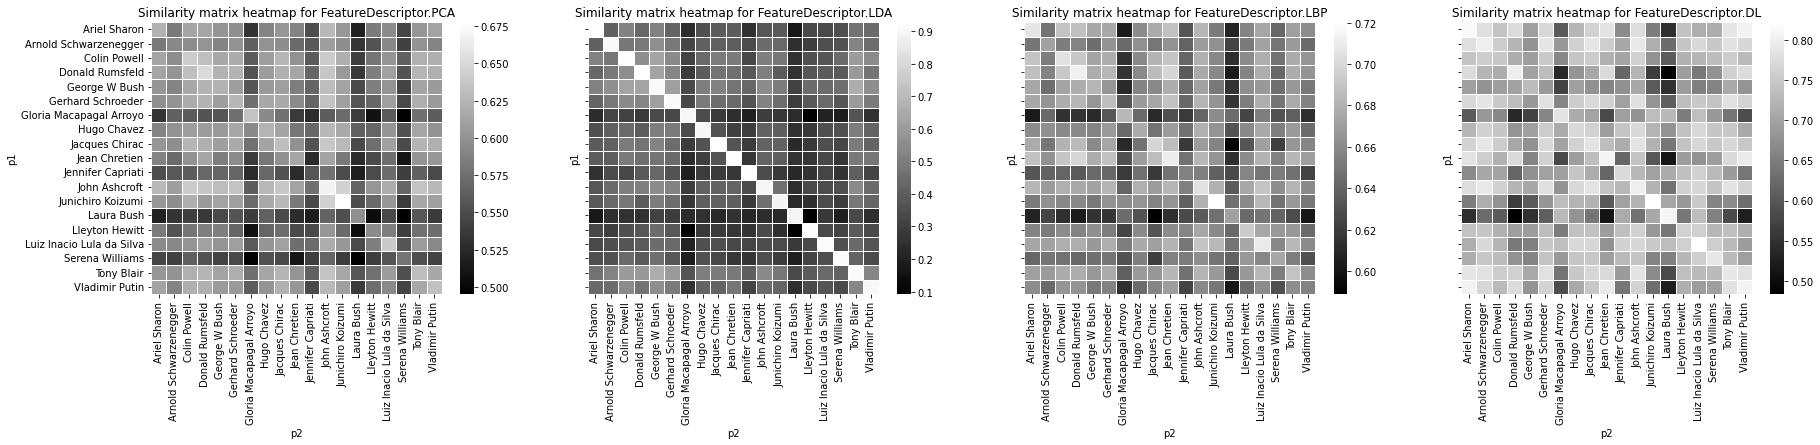

In [158]:
figure, axes = plt.subplots(1, 4, figsize=(30, 5), sharex=True, sharey=True)
metrics.plot_sim_matrix(face_mat_pca_lfw, axes[0], FeatureDescriptor.PCA)
metrics.plot_sim_matrix(face_mat_lda_lfw, axes[1], FeatureDescriptor.LDA)
metrics.plot_sim_matrix(face_mat_lbp_lfw, axes[2], FeatureDescriptor.LBP)
metrics.plot_sim_matrix(face_mat_dl_lfw, axes[3], FeatureDescriptor.DL)

Perform a full-on verification assessment based on the scores obtained. Interpret the results.

In [159]:
fpr_roc_pca_lfw, fnr_roc_pca_lfw, tpr_roc_pca_lfw, threshold_roc_pca_lfw = metrics.compute_fpr_fnr_tpr_from_roc_curve(score_pca_lfw, y_true_pca_lfw)
fpr_roc_lda_lfw, fnr_roc_lda_lfw, tpr_roc_lda_lfw, threshold_roc_lda_lfw = metrics.compute_fpr_fnr_tpr_from_roc_curve(score_lda_lfw, y_true_lda_lfw)
fpr_roc_lbp_lfw, fnr_roc_lbp_lfw, tpr_roc_lbp_lfw, threshold_roc_lbp_lfw = metrics.compute_fpr_fnr_tpr_from_roc_curve(score_lbp_lfw, y_true_lbp_lfw)
fpr_roc_dl_lfw, fnr_roc_dl_lfw, tpr_roc_dl_lfw, threshold_roc_dl_lfw = metrics.compute_fpr_fnr_tpr_from_roc_curve(score_dl_lfw, y_true_dl_lfw)

roc_au_pca_lfw = roc_auc_score(y_true=score_pca_lfw, y_score=y_true_pca_lfw)
roc_au_lda_lfw = roc_auc_score(y_true=score_lda_lfw, y_score=y_true_lda_lfw)
roc_au_lbp_lfw = roc_auc_score(y_true=score_lbp_lfw, y_score=y_true_lbp_lfw)
roc_au_dl_lfw = roc_auc_score(y_true=score_dl_lfw, y_score=y_true_dl_lfw)
print('ROC score for PCA : ', roc_au_pca_lfw)
print('ROC score for LDA : ', roc_au_lda_lfw)
print('ROC score for LBP : ', roc_au_lbp_lfw)
print('ROC score for DL : ', roc_au_dl_lfw)

2022-05-27 17:02:15,349 - Computing roc curve
2022-05-27 17:02:16,016 - End roc curve computation
2022-05-27 17:02:16,017 - Computing roc curve
2022-05-27 17:02:16,649 - End roc curve computation
2022-05-27 17:02:16,649 - Computing roc curve
2022-05-27 17:02:17,311 - End roc curve computation
2022-05-27 17:02:17,312 - Computing roc curve
2022-05-27 17:02:17,976 - End roc curve computation


ROC score for PCA :  0.591731022345471
ROC score for LDA :  0.9999999341217557
ROC score for LBP :  0.6177861095301784
ROC score for DL :  0.6217824298132526


In [160]:
eer_threshold_roc_pca_lfw = threshold_roc_pca_lfw[np.nanargmin(np.absolute((fnr_roc_pca_lfw - fpr_roc_pca_lfw)))]
eer_threshold_roc_lda_lfw = threshold_roc_lda_lfw[np.nanargmin(np.absolute((fnr_roc_lda_lfw - fpr_roc_lda_lfw)))]
eer_threshold_roc_lbp_lfw = threshold_roc_lbp_lfw[np.nanargmin(np.absolute((fnr_roc_lbp_lfw - fpr_roc_lbp_lfw)))]
eer_threshold_roc_dl_lfw = threshold_roc_dl_lfw[np.nanargmin(np.absolute((fnr_roc_dl_lfw - fpr_roc_dl_lfw)))]
print('EER threshold for PCA : ', eer_threshold_roc_pca_lfw)
print('EER threshold for LDA : ', eer_threshold_roc_lda_lfw)
print('EER threshold for LBP : ', eer_threshold_roc_lbp_lfw)
print('EER threshold for DL : ', eer_threshold_roc_dl_lfw)

EER threshold for PCA :  0.6187894960756177
EER threshold for LDA :  0.7524805367842919
EER threshold for LBP :  0.6776878226321911
EER threshold for DL :  0.7384652795534039


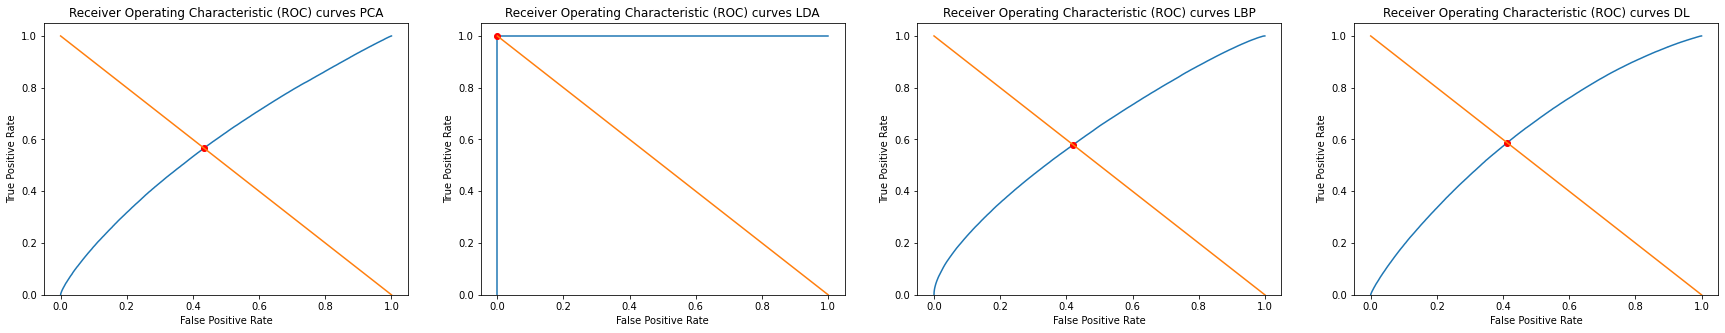

In [161]:
df_decision_threshold_fpr_fnr_pca_lfw = metrics.generate_dataframe(columns=['fpr', 'fnr', 'tpr'], data_list=[fpr_roc_pca_lfw, fnr_roc_pca_lfw, tpr_roc_pca_lfw], index_values=threshold_roc_pca_lfw)
df_decision_threshold_fpr_fnr_lda_lfw = metrics.generate_dataframe(columns=['fpr', 'fnr', 'tpr'], data_list=[fpr_roc_lda_lfw, fnr_roc_lda_lfw, tpr_roc_lda_lfw], index_values=threshold_roc_lda_lfw)
df_decision_threshold_fpr_fnr_lbp_lfw = metrics.generate_dataframe(columns=['fpr', 'fnr', 'tpr'], data_list=[fpr_roc_lbp_lfw, fnr_roc_lbp_lfw, tpr_roc_lbp_lfw], index_values=threshold_roc_lbp_lfw)
df_decision_threshold_fpr_fnr_dl_lfw = metrics.generate_dataframe(columns=['fpr', 'fnr', 'tpr'], data_list=[fpr_roc_dl_lfw, fnr_roc_dl_lfw, tpr_roc_dl_lfw], index_values=threshold_roc_dl_lfw)

result_roc_pca_lfw = df_decision_threshold_fpr_fnr_pca_lfw.loc[eer_threshold_roc_pca_lfw]
result_roc_lda_lfw = df_decision_threshold_fpr_fnr_lda_lfw.loc[eer_threshold_roc_lda_lfw]
result_roc_lbp_lfw = df_decision_threshold_fpr_fnr_lbp_lfw.loc[eer_threshold_roc_lbp_lfw]
result_roc_dl_lfw = df_decision_threshold_fpr_fnr_dl_lfw.loc[eer_threshold_roc_dl_lfw]

figure, axes = plt.subplots(1, 4, figsize=(30, 5))
metrics.plot_eer_roc(fpr_roc_pca_lfw, tpr_roc_pca_lfw, axes[0], result_roc_pca_lfw, "PCA")
metrics.plot_eer_roc(fpr_roc_lda_lfw, tpr_roc_lda_lfw, axes[1], result_roc_lda_lfw, "LDA")
metrics.plot_eer_roc(fpr_roc_lbp_lfw, tpr_roc_lbp_lfw, axes[2], result_roc_lbp_lfw, "LBP")
metrics.plot_eer_roc(fpr_roc_dl_lfw, tpr_roc_dl_lfw, axes[3], result_roc_dl_lfw, "DL")

In [162]:
"""Calculate the decision threshold for which the sum of FRR and FAR is minimal."""
df_decision_threshold_fpr_fnr_pca_lfw["sum"] = df_decision_threshold_fpr_fnr_pca_lfw[['fnr', "fpr"]].sum(axis=1)
df_decision_threshold_fpr_fnr_lda_lfw["sum"] = df_decision_threshold_fpr_fnr_lda_lfw[['fnr', "fpr"]].sum(axis=1)
df_decision_threshold_fpr_fnr_lbp_lfw["sum"] = df_decision_threshold_fpr_fnr_lbp_lfw[['fnr', "fpr"]].sum(axis=1)
df_decision_threshold_fpr_fnr_dl_lfw["sum"] = df_decision_threshold_fpr_fnr_dl_lfw[['fnr', "fpr"]].sum(axis=1)

print('Decision threshold where sum of frr and far are minimal')
print('threshold for PCA', df_decision_threshold_fpr_fnr_pca_lfw["sum"].idxmin())
print('threshold for LDA', df_decision_threshold_fpr_fnr_lda_lfw["sum"].idxmin())
print('threshold for LBP', df_decision_threshold_fpr_fnr_lbp_lfw["sum"].idxmin())
print('threshold for DL', df_decision_threshold_fpr_fnr_dl_lfw["sum"].idxmin())

Decision threshold where sum of frr and far are minimal
threshold for PCA 0.6283285298445995
threshold for LDA 0.7530759035381006
threshold for LBP 0.6941226721463264
threshold for DL 0.7310881464119289


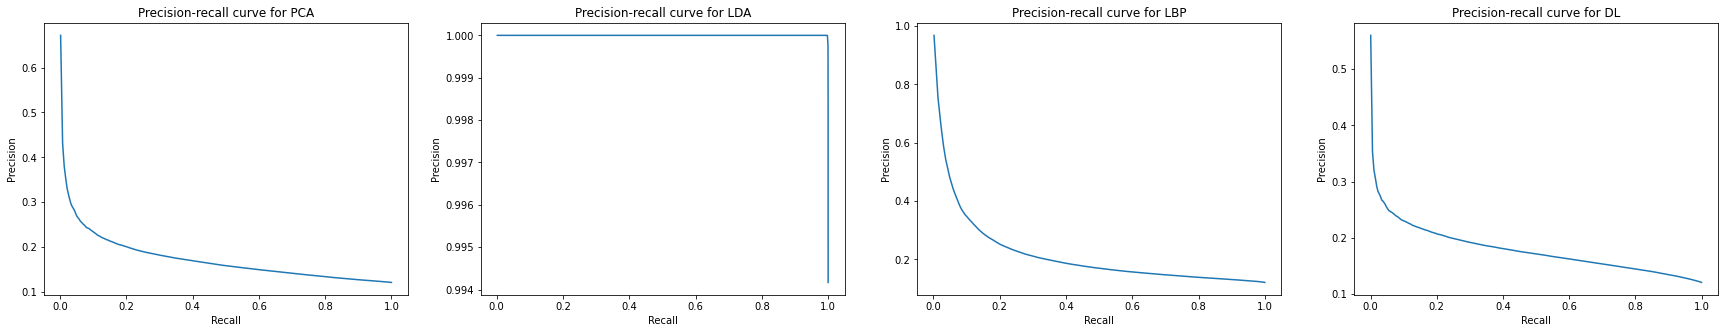

In [163]:
"""Calculate and plot the Precision-Recall curve for this system"""
figure, axes = plt.subplots(1, 4, figsize=(30, 5))
metrics.plot_recall_precision(recall_pca_lfw, precision_pca_lfw, axes[0], title_add="PCA")
metrics.plot_recall_precision(recall_lda_lfw, precision_lda_lfw, axes[1], title_add="LDA")
metrics.plot_recall_precision(recall_lbp_lfw, precision_lbp_lfw, axes[2], title_add="LBP")
metrics.plot_recall_precision(recall_dl_lfw, precision_dl_lfw, axes[3], title_add="DL")

In [164]:
"""Calculate the average precision scores"""
average_prec_score_pca_lfw = average_precision_score(y_true=score_pca_lfw, y_score=y_true_pca_lfw)
average_prec_score_lda_lfw = average_precision_score(y_true=score_lda_lfw, y_score=y_true_lda_lfw)
average_prec_score_lbp_lfw = average_precision_score(y_true=score_lbp_lfw, y_score=y_true_lbp_lfw)
average_prec_score_dl_lfw = average_precision_score(y_true=score_dl_lfw, y_score=y_true_dl_lfw)
print('Average precision score for PCA', average_prec_score_pca_lfw)
print('Average precision score for LDA', average_prec_score_lda_lfw)
print('Average precision score for LBP', average_prec_score_lbp_lfw)
print('Average precision score for DL', average_prec_score_dl_lfw)

Average precision score for PCA 0.17372809948632464
Average precision score for LDA 0.9999995220165461
Average precision score for LBP 0.21542236656704897
Average precision score for DL 0.17919461281435436


Validate the systems in an identification scenario.

In [165]:
ranked_pca_lfw = metrics.compute_cmc(face_mat_pca_lfw)
ranked_lda_lfw= metrics.compute_cmc(face_mat_lda_lfw)
ranked_lbp_lfw = metrics.compute_cmc(face_mat_lbp_lfw)
ranked_dl_lfw = metrics.compute_cmc(face_mat_dl_lfw)
ranked_pca_lfw, ranked_lbp_lfw, ranked_dl_lfw

(0    0.473684
 1    0.842105
 2    0.894737
 9    1.000000
 dtype: float64,
 0    0.736842
 1    0.947368
 8    1.000000
 dtype: float64,
 0    0.789474
 1    0.894737
 2    0.947368
 5    1.000000
 dtype: float64)

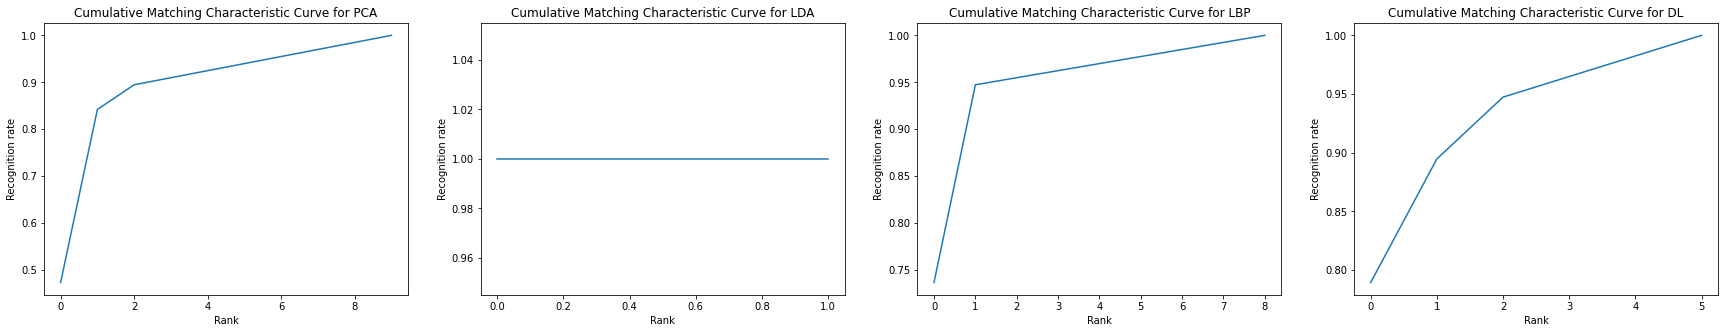

In [166]:
figure, axes = plt.subplots(1, 4, figsize=(30, 5))
metrics.plot_cmc(ranked_pca_lfw, axes[0], "PCA")
metrics.plot_cmc(ranked_lda_lfw, axes[1], "LDA")
metrics.plot_cmc(ranked_lbp_lfw, axes[2], "LBP")
metrics.plot_cmc(ranked_dl_lfw, axes[3], "DL")

#### 2.5 Pre-train your deep learning network on a different (larger) dataset and then fine-tune it with CALTECH and compare the results. (2pt.)

http://vision.ucsd.edu/~iskwak/ExtYaleDatabase/ExtYaleB.html
Contains 5760 single light source images of 10 subjects each seen under 576 viewing conditions (9 poses x 64 illumination conditions). For every subject in a particular pose, an image with ambient (background) illumination was also captured.

In [167]:
# grab in all the subdirs all the image paths associated with the faces
datasetPath_yale = Path("data/yale/CroppedYale")
imagePaths_yale = datasetPath_yale.glob("*/*.pgm")
# read image and label information
imgs_yale = [utils.read_img(imagePath) for imagePath in imagePaths_yale if "Ambient" not in str(imagePath)]
data_yale = pd.DataFrame(imgs_yale, columns =['images', 'target']).to_dict('list')

In [168]:
# display data structure
display(data_yale)
print(data_yale['images'][0].shape)
print(len(data_yale['images']))

{'images': [array([[80, 80, 84, ..., 63, 67, 71],
         [81, 79, 78, ..., 60, 61, 64],
         [80, 79, 82, ..., 61, 59, 62],
         ...,
         [12, 12, 19, ..., 21, 18, 14],
         [12, 12, 15, ..., 14, 14, 14],
         [12, 12, 12, ..., 12, 12, 11]], dtype=uint8),
  array([[94, 94, 96, ..., 72, 76, 79],
         [87, 87, 94, ..., 66, 72, 75],
         [88, 91, 95, ..., 70, 68, 67],
         ...,
         [ 5,  7,  8, ...,  8,  9,  7],
         [ 5,  7,  8, ...,  7,  8,  9],
         [ 4,  7,  7, ...,  6,  7,  8]], dtype=uint8),
  array([[59, 66, 77, ..., 73, 67, 58],
         [67, 76, 82, ..., 71, 72, 72],
         [66, 75, 84, ..., 79, 76, 76],
         ...,
         [ 4,  4,  4, ...,  3,  7,  6],
         [ 4,  5,  5, ...,  4,  5,  6],
         [ 3,  4,  5, ...,  5,  7,  7]], dtype=uint8),
  array([[16, 18, 22, ..., 13, 13, 12],
         [14, 17, 19, ..., 13, 14, 14],
         [14, 16, 18, ..., 12, 13, 11],
         ...,
         [ 1,  2,  2, ...,  3,  5,  5],
         

(192, 168)
2414


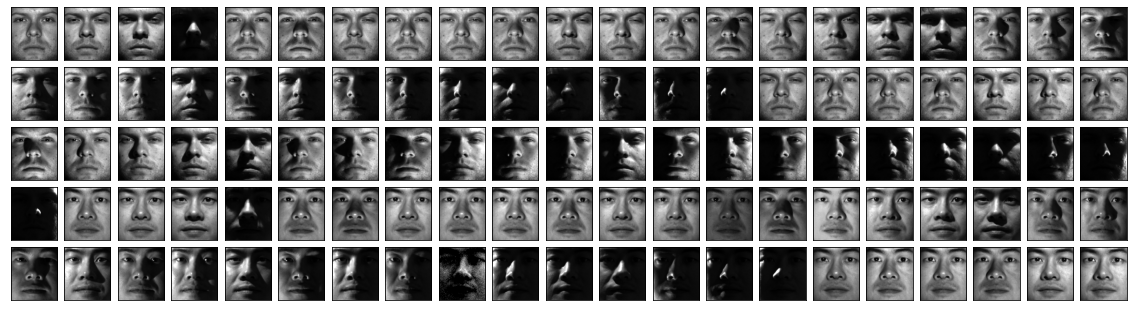

In [527]:
fig = plt.figure(figsize=(20, 20))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(5, 21),
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, data_yale['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [169]:
face_size_yale = [47, 47]
face_size_yale2 = [64, 64]

In [170]:
feat_data_yale, images_yale, labels_yale = [], [], []
feat_data_yale2, images_yale2 = [], []

for img, label in zip(data_yale['images'], data_yale['target']):

    # resize the face to the preferred size
    face = cv2.resize(img, face_size_yale)
    face2 = cv2.resize(img, face_size_yale2)
    face_flatten = face.flatten()
    face_flatten2 = face2.flatten()

    images_yale.append(np.expand_dims(face, axis=-1)), feat_data_yale.append(face_flatten), labels_yale.append(label)
    images_yale2.append(np.expand_dims(face2, axis=-1)), feat_data_yale2.append(face_flatten2)

# encode classes as integer value
label_encoder = LabelEncoder()
targets_yale = label_encoder.fit_transform(labels_yale)

faces_yale = Bunch(
              data       = np.array(feat_data_yale),
              data2       = np.array(feat_data_yale2),
              images     = np.array(images_yale),
              images2     = np.array(images_yale2),
              labels     = np.array(labels_yale),
              target     = np.array(targets_yale))

for key in faces_yale.keys():
    print(faces_yale[key][0:2])

[[ 79  96  99 ...  32  23  16]
 [ 90 110 117 ...  15   9   8]]
[[ 79  89  99 ...  26  16  14]
 [ 87 102 113 ...   9   8   8]]
[[[[ 79]
   [ 96]
   [ 99]
   ...
   [ 88]
   [ 71]
   [ 60]]

  [[ 86]
   [ 92]
   [101]
   ...
   [ 86]
   [ 70]
   [ 59]]

  [[ 81]
   [ 94]
   [106]
   ...
   [ 83]
   [ 65]
   [ 62]]

  ...

  [[ 24]
   [ 38]
   [ 41]
   ...
   [ 38]
   [ 40]
   [ 30]]

  [[ 22]
   [ 23]
   [ 35]
   ...
   [ 53]
   [ 32]
   [ 26]]

  [[ 13]
   [ 22]
   [ 27]
   ...
   [ 32]
   [ 23]
   [ 16]]]


 [[[ 90]
   [110]
   [117]
   ...
   [100]
   [ 81]
   [ 69]]

  [[ 95]
   [102]
   [117]
   ...
   [ 98]
   [ 83]
   [ 69]]

  [[ 88]
   [108]
   [121]
   ...
   [ 96]
   [ 73]
   [ 71]]

  ...

  [[ 11]
   [ 15]
   [ 24]
   ...
   [ 29]
   [ 22]
   [ 13]]

  [[  9]
   [ 11]
   [ 14]
   ...
   [ 25]
   [ 13]
   [ 13]]

  [[  7]
   [ 10]
   [ 11]
   ...
   [ 15]
   [  9]
   [  8]]]]
[[[[ 79]
   [ 89]
   [ 99]
   ...
   [ 75]
   [ 67]
   [ 62]]

  [[ 82]
   [ 87]
   [ 88]
   ...
   [

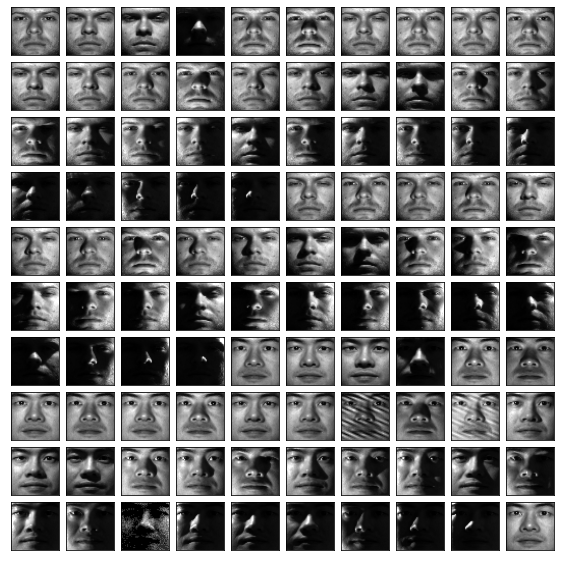

In [171]:
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(10, 10),
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, faces_yale['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(np.mean(im, -1), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [172]:
# extract number of samples and image dimensions (for later display)
imshape_yale, n_samples_yale, n_classes_yale, n_features_yale = utils.get_image_db_statistic(faces_yale)

Total dataset size:
n_samples: 2414
n_classes: 38
n_features: 2209
imshape : (47, 47, 1)


In [173]:
x_train_yale, x_test_yale, y_train_yale, y_test_yale = holdout_split(*siamese.get_siamese_paired_data(faces_yale.images, faces_yale.target))

encoder, model = siamese.create_siamese_model(imshape_yale)

rms = Adam()
model.compile(
    loss=siamese.contrastive_loss,
    optimizer=rms,
    metrics=[siamese.accuracy],
    run_eagerly=True)

epochs = 50

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit([x_train_yale[:, 0], x_train_yale[:, 1]], y_train_yale,
          validation_split=0.2,
          batch_size=32, verbose=2, epochs=epochs, callbacks=[cp_callback])

Epoch 1/50

Epoch 1: saving model to training_1\cp.ckpt
38/38 - 3s - loss: 0.5760 - accuracy: 0.5197 - val_loss: 0.1600 - val_accuracy: 0.5375 - 3s/epoch - 78ms/step
Epoch 2/50

Epoch 2: saving model to training_1\cp.ckpt
38/38 - 3s - loss: 0.1437 - accuracy: 0.5016 - val_loss: 0.1552 - val_accuracy: 0.5562 - 3s/epoch - 75ms/step
Epoch 3/50

Epoch 3: saving model to training_1\cp.ckpt
38/38 - 3s - loss: 0.1362 - accuracy: 0.5477 - val_loss: 0.1631 - val_accuracy: 0.5562 - 3s/epoch - 78ms/step
Epoch 4/50

Epoch 4: saving model to training_1\cp.ckpt
38/38 - 3s - loss: 0.1309 - accuracy: 0.5370 - val_loss: 0.1434 - val_accuracy: 0.4979 - 3s/epoch - 72ms/step
Epoch 5/50

Epoch 5: saving model to training_1\cp.ckpt
38/38 - 3s - loss: 0.1193 - accuracy: 0.6184 - val_loss: 0.1301 - val_accuracy: 0.5656 - 3s/epoch - 75ms/step
Epoch 6/50

Epoch 6: saving model to training_1\cp.ckpt
38/38 - 3s - loss: 0.1135 - accuracy: 0.6447 - val_loss: 0.1130 - val_accuracy: 0.6396 - 3s/epoch - 72ms/step
Epoc

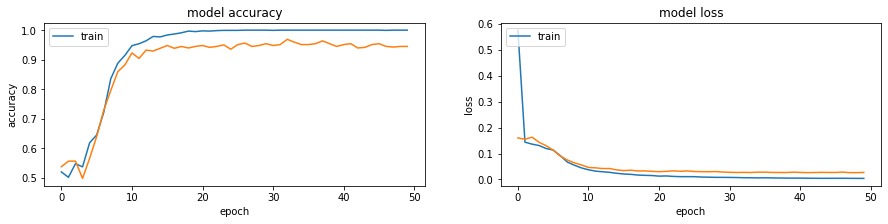

In [220]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots(1, 2, figsize=(15, 3))
# summarize history for accuracy
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train'], loc = 'upper left')

# summarize history for loss
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('model loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['train'], loc = 'upper left')
plt.show()

In [70]:
x_train_yale2, x_test_yale2, y_train_yale2, y_test_yale2 = holdout_split(*siamese.get_siamese_paired_data(faces_yale.images2, faces_yale.target))

_, h, w, n_channels = faces_yale.images2.shape
imshape2 = (h, w, n_channels)
encoder2, model2 = siamese.create_siamese_model(imshape2)

rms = Adam()
model2.compile(
    loss=siamese.contrastive_loss,
    optimizer=rms,
    metrics=[siamese.accuracy],
    run_eagerly=True)

epochs = 50

checkpoint_path2 = "training_2/cp.ckpt"
checkpoint_dir2 = os.path.dirname(checkpoint_path2)

# Create a callback that saves the model's weights
cp_callback2 = ModelCheckpoint(filepath=checkpoint_path2,
                                                 save_weights_only=True,
                                                 verbose=1)

history2 = model2.fit([x_train_yale2[:, 0], x_train_yale2[:, 1]], y_train_yale2,
          validation_split=0.2,
          batch_size=32, verbose=2, epochs=epochs, callbacks=[cp_callback2])

Epoch 1/50

Epoch 1: saving model to training_2\cp.ckpt
38/38 - 6s - loss: 20.5475 - accuracy: 0.4942 - val_loss: 0.1637 - val_accuracy: 0.5594 - 6s/epoch - 153ms/step
Epoch 2/50

Epoch 2: saving model to training_2\cp.ckpt
38/38 - 5s - loss: 0.1392 - accuracy: 0.5222 - val_loss: 0.1882 - val_accuracy: 0.5562 - 5s/epoch - 126ms/step
Epoch 3/50

Epoch 3: saving model to training_2\cp.ckpt
38/38 - 5s - loss: 0.1461 - accuracy: 0.5099 - val_loss: 0.1554 - val_accuracy: 0.5594 - 5s/epoch - 125ms/step
Epoch 4/50

Epoch 4: saving model to training_2\cp.ckpt
38/38 - 5s - loss: 0.1253 - accuracy: 0.5757 - val_loss: 0.1470 - val_accuracy: 0.5813 - 5s/epoch - 137ms/step
Epoch 5/50

Epoch 5: saving model to training_2\cp.ckpt
38/38 - 5s - loss: 0.1276 - accuracy: 0.5740 - val_loss: 0.1521 - val_accuracy: 0.5365 - 5s/epoch - 124ms/step
Epoch 6/50

Epoch 6: saving model to training_2\cp.ckpt
38/38 - 5s - loss: 0.1236 - accuracy: 0.5822 - val_loss: 0.1349 - val_accuracy: 0.5844 - 5s/epoch - 125ms/st

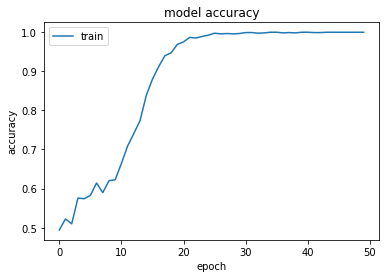

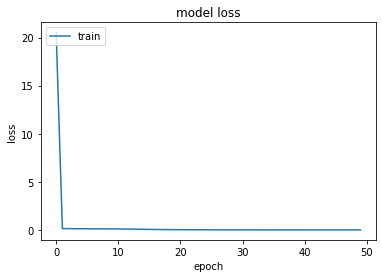

In [71]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc = 'upper left')
plt.show()

# summarize history for loss
plt.plot(history2.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc = 'upper left')
plt.show()

In [175]:
# Loads the weights
model.load_weights(checkpoint_path)

test_scores = model.predict([x_test_yale[:, 0], x_test_yale[:, 1]])
test_acc = accuracy_score(y_test_yale, test_scores > 0.5)
print("Accuracy on the test set: {}".format(test_acc))


Accuracy on the test set: 0.932


In [176]:
transfer_system = {
    'model': model,
    'encoder': encoder
}

In [177]:
embedded_TL, dist_metric_TL = facial_descriptor.extract_face_representation(DESC=FeatureDescriptor.TL, holdout_split=holdout_split, transfer_system=transfer_system)
df_scores_TL, similarity_mat_TL = utils.compute_similarity_matrix(embedded_TL, dist_metric_TL, labels)
face_mat_TL = df_scores_TL.pivot_table(index='p1', columns='p2',values='scores_norm',aggfunc = np.average)
face_mat_TL

Epoch 1/15
38/38 - 2s - loss: 0.0696 - accuracy: 0.8166 - val_loss: 0.0390 - val_accuracy: 0.9125 - 2s/epoch - 61ms/step
Epoch 2/15
38/38 - 2s - loss: 0.0372 - accuracy: 0.9334 - val_loss: 0.0349 - val_accuracy: 0.9354 - 2s/epoch - 56ms/step
Epoch 3/15
38/38 - 2s - loss: 0.0293 - accuracy: 0.9564 - val_loss: 0.0316 - val_accuracy: 0.9448 - 2s/epoch - 54ms/step
Epoch 4/15
38/38 - 2s - loss: 0.0215 - accuracy: 0.9778 - val_loss: 0.0288 - val_accuracy: 0.9354 - 2s/epoch - 54ms/step
Epoch 5/15
38/38 - 2s - loss: 0.0186 - accuracy: 0.9811 - val_loss: 0.0245 - val_accuracy: 0.9531 - 2s/epoch - 58ms/step
Epoch 6/15
38/38 - 2s - loss: 0.0165 - accuracy: 0.9877 - val_loss: 0.0188 - val_accuracy: 0.9719 - 2s/epoch - 53ms/step
Epoch 7/15
38/38 - 2s - loss: 0.0125 - accuracy: 0.9918 - val_loss: 0.0169 - val_accuracy: 0.9812 - 2s/epoch - 43ms/step
Epoch 8/15
38/38 - 2s - loss: 0.0096 - accuracy: 0.9967 - val_loss: 0.0160 - val_accuracy: 0.9750 - 2s/epoch - 42ms/step
Epoch 9/15
38/38 - 2s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████████████| 440/440 [00:01<00:00, 328.37it/s]


p2          person_001  person_002  person_003  person_004  person_005  \
p1                                                                       
person_001    0.864167    0.480677    0.643272    0.553324    0.506500   
person_002    0.480677    0.947845    0.549810    0.802436    0.238477   
person_003    0.643272    0.549810    0.894962    0.550529    0.334238   
person_004    0.553324    0.802436    0.550529    0.927661    0.286221   
person_005    0.506500    0.238477    0.334238    0.286221    0.916151   
person_006    0.480753    0.671771    0.601983    0.676634    0.206407   
person_007    0.567423    0.751308    0.669962    0.681186    0.306846   
person_008    0.542876    0.499794    0.460790    0.606155    0.347976   
person_009    0.482201    0.529388    0.430163    0.631148    0.272747   
person_010    0.533877    0.707403    0.595506    0.725774    0.289349   
person_011    0.538194    0.501352    0.597475    0.479354    0.320519   
person_012    0.551430    0.708046    0.521848    0.861710    0.284104   
person_013    0.568942    0.602436    0.514864    0.606312    0.600289   
person_014    0.294109    0.328916    0.245952    0.434492    0.098198   
person_015    0.517735    0.307886    0.411117    0.425649    0.287682   
person_016    0.581802    0.709888    0.618561    0.696610    0.355433   
person_017    0.596580    0.427085    0.580817    0.540287    0.307540   
person_018    0.636536    0.770070    0.637860    0.762981    0.397685   
person_019    0.629046    0.705975    0.810143    0.697818    0.327583   
person_020    0.424875    0.602554    0.480093    0.624527    0.191116   
person_021    0.554197    0.348272    0.472214    0.428641    0.331998   
person_022    0.500878    0.762469    0.552271    0.703845    0.278926   
person_023    0.608062    0.504390    0.690675    0.580080    0.302437   
person_024    0.721685    0.647038    0.791646    0.707324    0.387286   
person_025    0.637717    0.568210    0.659597    0.597221    0.363094   
person_026    0.693544    0.623593    0.666503    0.612026    0.480788   

p2          person_006  person_007  person_008  person_009  person_010  ...  \
p1                                                                      ...   
person_001    0.480753    0.567423    0.542876    0.482201    0.533877  ...   
person_002    0.671771    0.751308    0.499794    0.529388    0.707403  ...   
person_003    0.601983    0.669962    0.460790    0.430163    0.595506  ...   
person_004    0.676634    0.681186    0.606155    0.631148    0.725774  ...   
person_005    0.206407    0.306846    0.347976    0.272747    0.289349  ...   
person_006    0.933298    0.608896    0.498562    0.583754    0.792372  ...   
person_007    0.608896    0.918346    0.500555    0.484145    0.617472  ...   
person_008    0.498562    0.500555    0.947468    0.794316    0.517492  ...   
person_009    0.583754    0.484145    0.794316    0.908517    0.568292  ...   
person_010    0.792372    0.617472    0.517492    0.568292    0.956446  ...   
person_011    0.441623    0.658429    0.477010    0.421412    0.435255  ...   
person_012    0.660291    0.616826    0.635861    0.675031    0.693356  ...   
person_013    0.505863    0.585679    0.516431    0.487610    0.599387  ...   
person_014    0.515707    0.256515    0.469594    0.600689    0.494050  ...   
person_015    0.418115    0.353930    0.678278    0.672487    0.394328  ...   
person_016    0.628943    0.724847    0.694305    0.651701    0.641711  ...   
person_017    0.582141    0.470964    0.631990    0.653434    0.538160  ...   
person_018    0.624915    0.734819    0.524510    0.516593    0.722954  ...   
person_019    0.701720    0.738662    0.518691    0.514238    0.720457  ...   
person_020    0.752782    0.514472    0.461777    0.532773    0.797872  ...   
person_021    0.346595    0.474641    0.614555    0.518121    0.346946  ...   
person_022    0.613449    0.764707    0.558723    0.568794    0.618549  ...   
person_023    0.699872    0.539

In [178]:
genuine_df_TL = df_scores_TL['scores_norm'][df_scores_TL['genuine'] == 1]
imposter_df_TL = df_scores_TL['scores_norm'][df_scores_TL['genuine'] == 0]

In [179]:
embedded_TL_lfw, dist_metric_TL_lfw = facial_descriptor_lfw.extract_face_representation(DESC=FeatureDescriptor.TL, holdout_split=holdout_split, transfer_system=transfer_system, epochs=30)
df_scores_TL_lfw, similarity_mat_TL_lfw = utils.compute_similarity_matrix(embedded_TL_lfw, dist_metric_TL_lfw, labels_lfw)
face_mat_TL_lfw = df_scores_TL_lfw.pivot_table(index='p1', columns='p2',values='scores_norm',aggfunc = np.average)
genuine_df_TL_lfw = df_scores_TL_lfw['scores_norm'][df_scores_TL_lfw['genuine'] == 1]
imposter_df_TL_lfw = df_scores_TL_lfw['scores_norm'][df_scores_TL_lfw['genuine'] == 0]
face_mat_TL_lfw

Epoch 1/30
38/38 - 2s - loss: 0.1257 - accuracy: 0.5732 - val_loss: 0.1245 - val_accuracy: 0.5917 - 2s/epoch - 46ms/step
Epoch 2/30
38/38 - 2s - loss: 0.1155 - accuracy: 0.6209 - val_loss: 0.1148 - val_accuracy: 0.6281 - 2s/epoch - 47ms/step
Epoch 3/30
38/38 - 2s - loss: 0.1011 - accuracy: 0.6891 - val_loss: 0.1153 - val_accuracy: 0.6250 - 2s/epoch - 58ms/step
Epoch 4/30
38/38 - 2s - loss: 0.0934 - accuracy: 0.7245 - val_loss: 0.1081 - val_accuracy: 0.6552 - 2s/epoch - 57ms/step
Epoch 5/30
38/38 - 2s - loss: 0.0835 - accuracy: 0.7763 - val_loss: 0.1024 - val_accuracy: 0.7021 - 2s/epoch - 44ms/step
Epoch 6/30
38/38 - 2s - loss: 0.0744 - accuracy: 0.8215 - val_loss: 0.0986 - val_accuracy: 0.6844 - 2s/epoch - 44ms/step
Epoch 7/30
38/38 - 2s - loss: 0.0671 - accuracy: 0.8421 - val_loss: 0.1040 - val_accuracy: 0.6906 - 2s/epoch - 44ms/step
Epoch 8/30
38/38 - 2s - loss: 0.0592 - accuracy: 0.8734 - val_loss: 0.0906 - val_accuracy: 0.7344 - 2s/epoch - 58ms/step
Epoch 9/30
38/38 - 2s - loss: 0.

100%|██████████████████████████████████████████████████████████████████████████████| 1867/1867 [00:20<00:00, 93.26it/s]


p2                         Ariel Sharon  Arnold Schwarzenegger  Colin Powell  \
p1                                                                             
Ariel Sharon                   0.812878               0.818315      0.702846   
Arnold Schwarzenegger          0.818315               0.840152      0.704554   
Colin Powell                   0.702846               0.704554      0.750151   
Donald Rumsfeld                0.781207               0.788787      0.679581   
George W Bush                  0.745169               0.771892      0.634077   
Gerhard Schroeder              0.809998               0.824309      0.717896   
Gloria Macapagal Arroyo        0.701966               0.702669      0.568523   
Hugo Chavez                    0.805515               0.827091      0.685879   
Jacques Chirac                 0.720848               0.730042      0.732712   
Jean Chretien                  0.817383               0.812276      0.681861   
Jennifer Capriati              0.767886               0.786908      0.616308   
John Ashcroft                  0.773492               0.777897      0.740626   
Junichiro Koizumi              0.665340               0.673231      0.746287   
Laura Bush                     0.734439               0.760048      0.583604   
Lleyton Hewitt                 0.757379               0.784069      0.601847   
Luiz Inacio Lula da Silva      0.770344               0.804907      0.706706   
Serena Williams                0.755955               0.769885      0.610927   
Tony Blair                     0.775646               0.798325      0.729424   
Vladimir Putin                 0.824219               0.839538      0.707552   

p2                         Donald Rumsfeld  George W Bush  Gerhard Schroeder  \
p1                                                                             
Ariel Sharon                      0.781207       0.745169           0.809998   
Arnold Schwarzenegger             0.788787       0.771892           0.824309   
Colin Powell                      0.679581       0.634077           0.717896   
Donald Rumsfeld                   0.821770       0.759383           0.804390   
George W Bush                     0.759383       0.767450           0.769874   
Gerhard Schroeder                 0.804390       0.769874           0.828195   
Gloria Macapagal Arroyo           0.622839       0.657136           0.684169   
Hugo Chavez                       0.765446       0.763880           0.808588   
Jacques Chirac                    0.663180       0.660830           0.734137   
Jean Chretien                     0.794628       0.746955           0.811758   
Jennifer Capriati                 0.764830       0.738317           0.756365   
John Ashcroft                     0.723084       0.703680           0.781783   
Junichiro Koizumi                 0.610889       0.594222           0.679449   
Laura Bush                        0.676582       0.705793           0.714698   
Lleyton Hewitt                    0.737138       0.740878           0.745701   
Luiz Inacio Lula da Silva         0.731820       0.726413           0.777910   
Serena Williams                   0.761220       0.720430           0.743119   
Tony Blair                        0.795527       0.753515           0.808278   
Vladimir Putin                    0.804445       0.774137           0.831621   

p2                         Gloria Macapagal Arroyo  Hugo Chavez  \
p1                                                                
Ariel Sharon                              0.701966     0.805515   
Arnold Schwarzenegger                     0.702669     0.827091   
Colin Powell                              0.568523     0.685879   
Donald Rumsfeld                           0.622839     0.765446   
George W Bush                             0.657136     0.763880   
Gerhard Schroeder                         0.684169     0.808588   
Gloria Macapagal Arroyo                   0.845484     0.735258   
Hugo Chavez                        

In [180]:
checkpoint_path2 = "training_2/cp.ckpt"
model2.load_weights(checkpoint_path2)
transfer_system2 = {
    'model': model2,
    'encoder': encoder2
}

In [181]:
embedded_TL_att, dist_metric_TL_att = facial_descriptor_att.extract_face_representation(DESC=FeatureDescriptor.TL, holdout_split=holdout_split, transfer_system=transfer_system2)
df_scores_TL_att, similarity_mat_TL_att = utils.compute_similarity_matrix(embedded_TL_att, dist_metric_TL_att, labels_att)

Epoch 1/15
38/38 - 3s - loss: 0.1152 - accuracy: 0.6291 - val_loss: 0.0967 - val_accuracy: 0.6875 - 3s/epoch - 91ms/step
Epoch 2/15
38/38 - 3s - loss: 0.0679 - accuracy: 0.8150 - val_loss: 0.0693 - val_accuracy: 0.7906 - 3s/epoch - 90ms/step
Epoch 3/15
38/38 - 3s - loss: 0.0510 - accuracy: 0.8890 - val_loss: 0.0530 - val_accuracy: 0.8646 - 3s/epoch - 91ms/step
Epoch 4/15
38/38 - 4s - loss: 0.0432 - accuracy: 0.9046 - val_loss: 0.0433 - val_accuracy: 0.9135 - 4s/epoch - 96ms/step
Epoch 5/15
38/38 - 3s - loss: 0.0370 - accuracy: 0.9359 - val_loss: 0.0443 - val_accuracy: 0.9104 - 3s/epoch - 91ms/step
Epoch 6/15
38/38 - 4s - loss: 0.0336 - accuracy: 0.9465 - val_loss: 0.0397 - val_accuracy: 0.9083 - 4s/epoch - 96ms/step
Epoch 7/15
38/38 - 4s - loss: 0.0283 - accuracy: 0.9589 - val_loss: 0.0426 - val_accuracy: 0.8979 - 4s/epoch - 94ms/step
Epoch 8/15
38/38 - 3s - loss: 0.0292 - accuracy: 0.9613 - val_loss: 0.0316 - val_accuracy: 0.9448 - 3s/epoch - 73ms/step
Epoch 9/15
38/38 - 3s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 484.98it/s]


In [182]:
face_mat_TL_att = df_scores_TL_att.pivot_table(index='p1', columns='p2',values='scores_norm',aggfunc = np.average)
genuine_df_TL_att = df_scores_TL_att['scores_norm'][df_scores_TL_att['genuine'] == 1]
imposter_df_TL_att = df_scores_TL_att['scores_norm'][df_scores_TL_att['genuine'] == 0]
face_mat_TL_att

p2          person_001  person_002  person_003  person_004  person_005  \
p1                                                                       
person_001    0.881156    0.676697    0.741377    0.824169    0.808555   
person_002    0.676697    0.932462    0.657842    0.709041    0.565737   
person_003    0.741377    0.657842    0.847967    0.791872    0.779096   
person_004    0.824169    0.709041    0.791872    0.880226    0.783629   
person_005    0.808555    0.565737    0.779096    0.783629    0.896797   
person_006    0.708849    0.412731    0.597972    0.644343    0.758664   
person_007    0.826161    0.624684    0.708701    0.766081    0.773525   
person_008    0.755001    0.547087    0.747460    0.757329    0.788376   
person_009    0.712919    0.549047    0.798374    0.767408    0.780808   
person_010    0.634385    0.417186    0.695730    0.665251    0.730804   
person_011    0.708957    0.683163    0.748369    0.772137    0.667809   
person_012    0.779264    0.623755    0.819465    0.785407    0.835622   
person_013    0.802363    0.708612    0.834594    0.850949    0.793392   
person_014    0.705803    0.771537    0.815079    0.768695    0.681614   
person_015    0.766763    0.648326    0.795838    0.857488    0.767467   
person_016    0.816154    0.682902    0.701801    0.806530    0.728975   
person_017    0.751015    0.641269    0.788145    0.783618    0.744108   
person_018    0.770110    0.487959    0.693303    0.737797    0.836228   
person_019    0.784783    0.715470    0.800521    0.814743    0.746863   
person_020    0.751031    0.680518    0.740827    0.833834    0.709919   
person_021    0.726748    0.750072    0.793057    0.816637    0.694570   
person_022    0.487016    0.685999    0.591954    0.586561    0.445140   
person_023    0.720575    0.538394    0.801267    0.753303    0.800462   
person_024    0.705037    0.761879    0.657143    0.772645    0.605160   
person_025    0.725953    0.653962    0.838633    0.764308    0.755451   
person_026    0.630506    0.656098    0.790449    0.686559    0.652339   
person_027    0.750371    0.761973    0.824902    0.816727    0.716080   
person_028    0.645439    0.703216    0.785283    0.724417    0.630801   
person_029    0.612067    0.709633    0.737044    0.708669    0.592589   
person_030    0.771876    0.699007    0.798940    0.855362    0.762620   
person_031    0.655941    0.815948    0.728513    0.725603    0.604569   
person_032    0.769757    0.801746    0.751570    0.762396    0.689254   
person_033    0.723611    0.771194    0.767216    0.799478    0.682509   
person_034    0.443977    0.709414    0.498442    0.528686    0.366328   
person_035    0.784358    0.627543    0.840875    0.829415    0.829194   
person_036    0.834263    0.612390    0.701893    0.807988    0.783208   
person_037    0.523574    0.626451    0.704698    0.608205    0.536150   
person_038    0.783731    0.643313    0.843073    0.786076    0.841762   
person_039    0.453611    0.653667    0.574100    0.558414    0.416676   
person_040    0.796272    0.570924    0.802429    0.802195    0.870519   

p2          person_006  person_007  person_008  person_009  person_010  ...  \
p1                                                                      ...   
person_001    0.708849    0.826161    0.755001    0.712919    0.634385  ...   
person_002    0.412731    0.624684    0.547087    0.549047    0.417186  ...   
person_003    0.597972    0.708701    0.747460    0.798374    0.695730  ...   
person_004    0.644343    0.766081    0.757329    0.767408    0.665251  ...   
person_005    0.758664    0.773525    0.788376    0.780808    0.730804  ...   
person_006    0.897641    0.750760    0.757454    0.683554    0.709227  ...   
person_007    0.750760    0.902873    0.765339    0.723238    0.655058  ...   
person_008    0.757454    0.765339    0.819864    0.800456    0.769533  ...   
person_009    0.683554    0.723238    0.800456    0.890958    0.820986  ...   
person_010    0.709227

In [221]:
score_TL, y_true_TL = df_scores_TL['genuine'], df_scores_TL['scores_norm']
score_TL_att, y_true_TL_att = df_scores_TL_att['genuine'], df_scores_TL_att['scores_norm']
score_TL_lfw, y_true_TL_lfw = df_scores_TL_lfw['genuine'], df_scores_TL_lfw['scores_norm']
df_classification_metrics_TL, precision_TL, recall_TL = metrics.get_f1_and_acc_dataframe(genuine_df_TL, imposter_df_TL, score_TL, y_true_TL)
df_classification_metrics_TL_att, precision_TL_att, recall_TL_att = metrics.get_f1_and_acc_dataframe(genuine_df_TL_att, imposter_df_TL_att, score_TL_att, y_true_TL_att)
df_classification_metrics_TL_lfw, precision_TL_lfw, recall_TL_lfw = metrics.get_f1_and_acc_dataframe(genuine_df_TL_lfw, imposter_df_TL_lfw, score_TL_lfw, y_true_TL_lfw, slice=True)

2022-05-27 18:10:18,153 - Computing precision recall
2022-05-27 18:10:18,183 - Computing accuracy
2022-05-27 18:10:18,209 - Generate dataframe
2022-05-27 18:10:18,212 - Computing precision recall
2022-05-27 18:10:18,235 - Computing accuracy
2022-05-27 18:10:18,258 - Generate dataframe
2022-05-27 18:10:18,261 - Computing precision recall
2022-05-27 18:10:18,992 - Computing accuracy
2022-05-27 18:10:20,278 - Generate dataframe


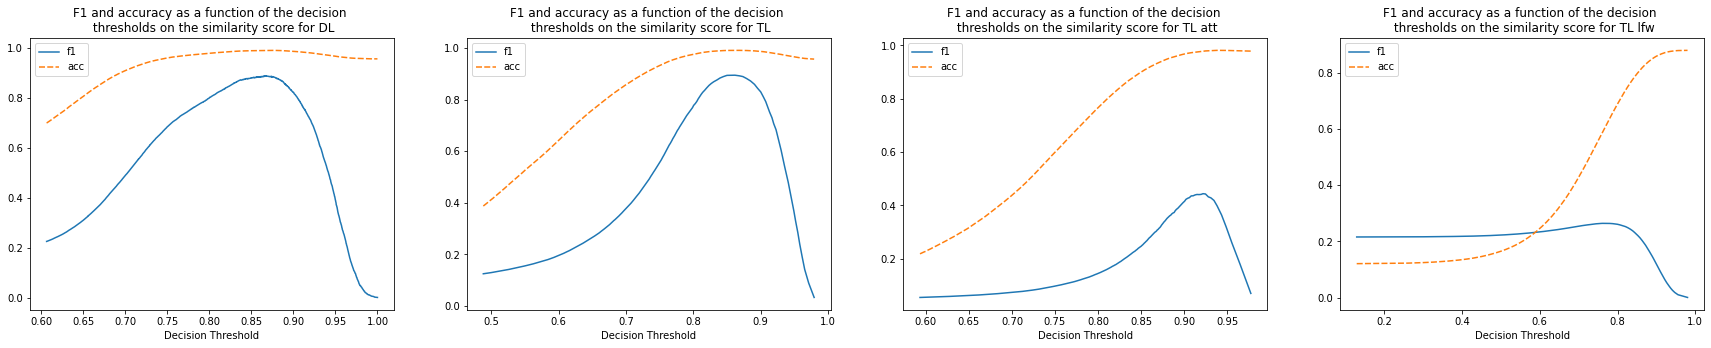

In [222]:
figure, axes = plt.subplots(1, 4, figsize=(30, 5))
metrics.plot_decision_threshold_f1_acc(df_classification_metrics_dl, "DL", axes[0])
metrics.plot_decision_threshold_f1_acc(df_classification_metrics_TL, "TL", axes[1])
metrics.plot_decision_threshold_f1_acc(df_classification_metrics_TL_att, "TL att", axes[2])
metrics.plot_decision_threshold_f1_acc(df_classification_metrics_TL_lfw, "TL lfw", axes[3])

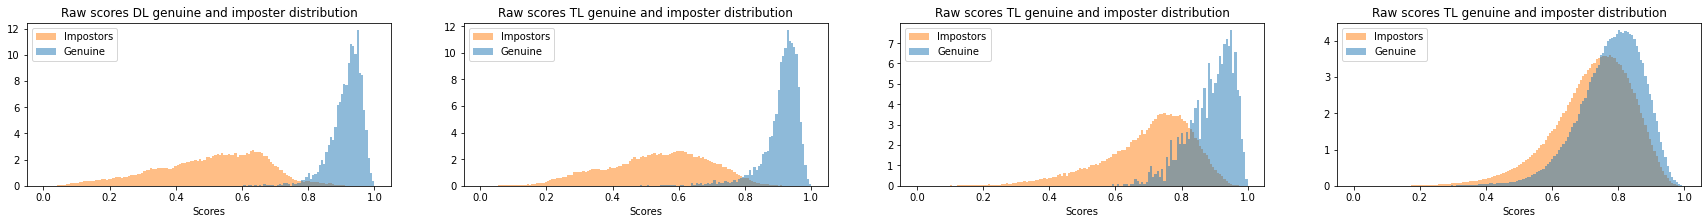

In [223]:
figure, axes = plt.subplots(1, 4, figsize=(30, 3))
metrics.plot_score_distribution(axes[0], imposter_df_dl, genuine_df_dl, "DL genuine and imposter distribution")
metrics.plot_score_distribution(axes[1], imposter_df_TL, genuine_df_TL, "TL genuine and imposter distribution")
metrics.plot_score_distribution(axes[2], imposter_df_TL_att, genuine_df_TL_att, "TL genuine and imposter distribution")
metrics.plot_score_distribution(axes[3], imposter_df_TL_lfw, genuine_df_TL_lfw, "TL genuine and imposter distribution")

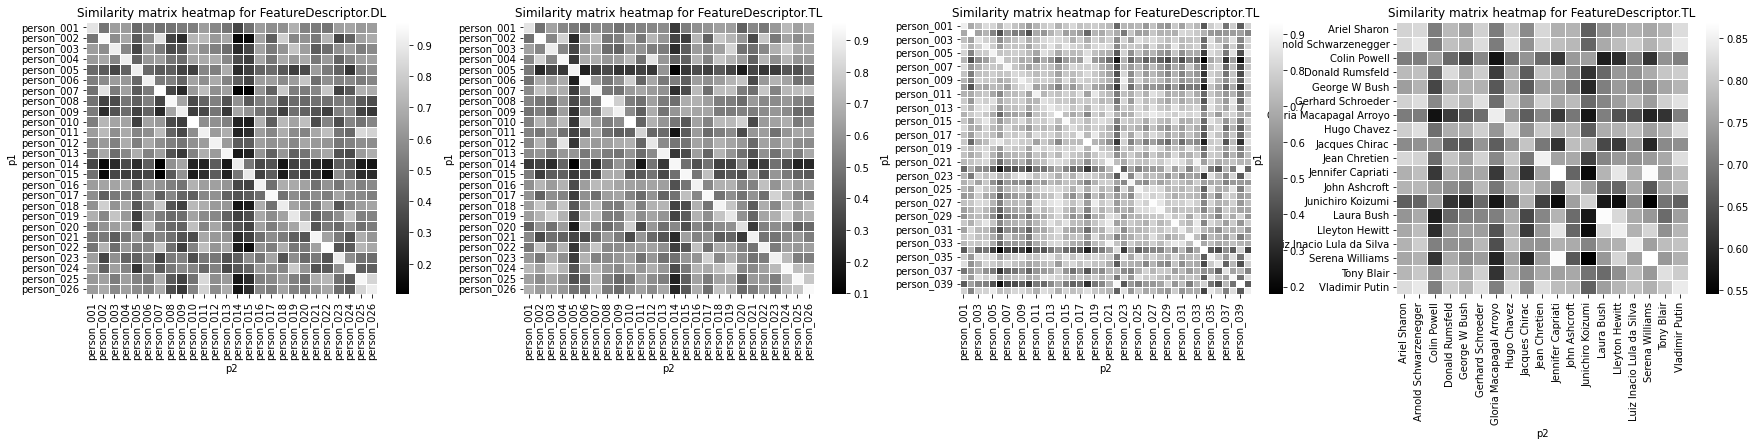

In [224]:
figure, axes = plt.subplots(1, 4, figsize=(30, 5))
metrics.plot_sim_matrix(face_mat_dl, axes[0], FeatureDescriptor.DL)
metrics.plot_sim_matrix(face_mat_TL, axes[1], FeatureDescriptor.TL)
metrics.plot_sim_matrix(face_mat_TL_att, axes[2], FeatureDescriptor.TL)
metrics.plot_sim_matrix(face_mat_TL_lfw, axes[3], FeatureDescriptor.TL)

In [225]:
fpr_roc_TL, fnr_roc_TL, tpr_roc_TL, threshold_roc_TL = metrics.compute_fpr_fnr_tpr_from_roc_curve(score_TL, y_true_TL)
fpr_roc_TL_att, fnr_roc_TL_att, tpr_roc_TL_att, threshold_roc_TL_att = metrics.compute_fpr_fnr_tpr_from_roc_curve(score_TL_att, y_true_TL_att)
fpr_roc_TL_lfw, fnr_roc_TL_lfw, tpr_roc_TL_lfw, threshold_roc_TL_lfw = metrics.compute_fpr_fnr_tpr_from_roc_curve(score_TL_lfw, y_true_TL_lfw)
roc_au_TL = roc_auc_score(y_true=score_TL, y_score=y_true_TL)
roc_au_TL_lfw = roc_auc_score(y_true=score_TL_lfw, y_score=y_true_TL_lfw)
roc_au_TL_att = roc_auc_score(y_true=score_TL_att, y_score=y_true_TL_att)
print('ROC score for DL : ', roc_au_dl)
print('ROC score for TL : ', roc_au_TL)
print('ROC score for TL att : ', roc_au_TL_att)
print('ROC score for TL lfw : ', roc_au_TL_lfw)

2022-05-27 18:11:45,454 - Computing roc curve
2022-05-27 18:11:45,487 - End roc curve computation
2022-05-27 18:11:45,488 - Computing roc curve
2022-05-27 18:11:45,512 - End roc curve computation
2022-05-27 18:11:45,512 - Computing roc curve
2022-05-27 18:11:46,200 - End roc curve computation


ROC score for DL :  0.9972034382532091
ROC score for TL :  0.9935182179384419
ROC score for TL att :  0.9150733689458688
ROC score for TL lfw :  0.6385292692590441


In [188]:
eer_threshold_roc_TL = threshold_roc_TL[np.nanargmin(np.absolute((fnr_roc_TL - fpr_roc_TL)))]
eer_threshold_roc_TL_att = threshold_roc_TL_att[np.nanargmin(np.absolute((fnr_roc_TL_att - fpr_roc_TL_att)))]
eer_threshold_roc_TL_lfw = threshold_roc_TL_lfw[np.nanargmin(np.absolute((fnr_roc_TL_lfw - fpr_roc_TL_lfw)))]
print('EER threshold for DL : ', eer_threshold_roc_dl)
print('EER threshold for TL : ', eer_threshold_roc_TL)

EER threshold for DL :  0.8253875184915246
EER threshold for TL :  0.7821310408129426


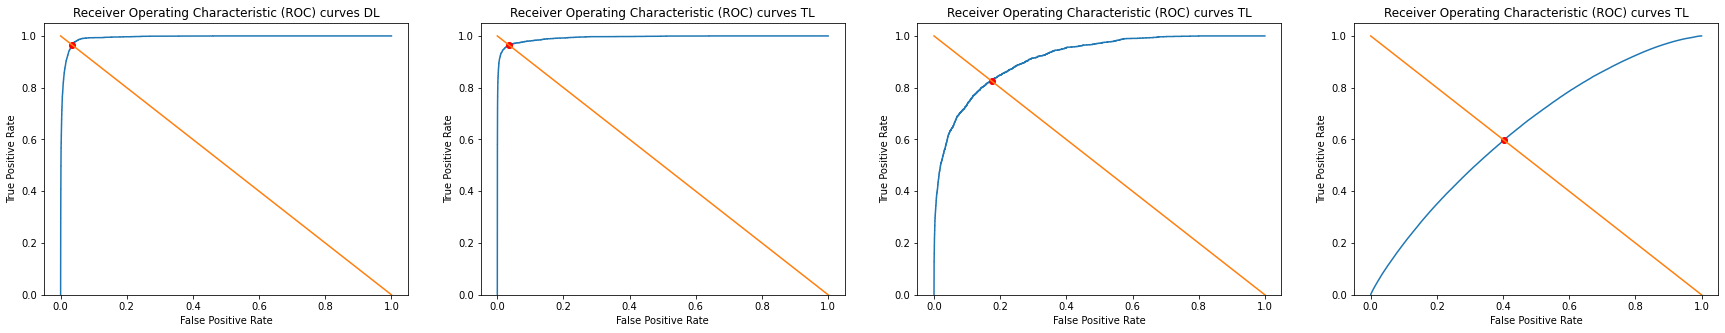

In [189]:
df_decision_threshold_fpr_fnr_TL = metrics.generate_dataframe(columns=['fpr', 'fnr', 'tpr'], data_list=[fpr_roc_TL, fnr_roc_TL, tpr_roc_TL], index_values=threshold_roc_TL)
df_decision_threshold_fpr_fnr_TL_att = metrics.generate_dataframe(columns=['fpr', 'fnr', 'tpr'], data_list=[fpr_roc_TL_att, fnr_roc_TL_att, tpr_roc_TL_att], index_values=threshold_roc_TL_att)
df_decision_threshold_fpr_fnr_TL_lfw = metrics.generate_dataframe(columns=['fpr', 'fnr', 'tpr'], data_list=[fpr_roc_TL_lfw, fnr_roc_TL_lfw, tpr_roc_TL_lfw], index_values=threshold_roc_TL_lfw)
result_roc_TL = df_decision_threshold_fpr_fnr_TL.loc[eer_threshold_roc_TL]
result_roc_TL_att = df_decision_threshold_fpr_fnr_TL_att.loc[eer_threshold_roc_TL_att]
result_roc_TL_lfw = df_decision_threshold_fpr_fnr_TL_lfw.loc[eer_threshold_roc_TL_lfw]
figure, axes = plt.subplots(1, 4, figsize=(30, 5))
metrics.plot_eer_roc(fpr_roc_dl, tpr_roc_dl, axes[0], result_roc_dl, "DL")
metrics.plot_eer_roc(fpr_roc_TL, tpr_roc_TL, axes[1], result_roc_TL, "TL")
metrics.plot_eer_roc(fpr_roc_TL_att, tpr_roc_TL_att, axes[2], result_roc_TL_att, "TL")
metrics.plot_eer_roc(fpr_roc_TL_lfw, tpr_roc_TL_lfw, axes[3], result_roc_TL_lfw, "TL")

In [190]:
"""Calculate the decision threshold for which the sum of FRR and FAR is minimal."""
df_decision_threshold_fpr_fnr_TL["sum"] = df_decision_threshold_fpr_fnr_TL[['fpr', 'fnr']].sum(axis=1)
df_decision_threshold_fpr_fnr_TL_att["sum"] = df_decision_threshold_fpr_fnr_TL_att[['fpr', 'fnr']].sum(axis=1)
df_decision_threshold_fpr_fnr_TL_lfw["sum"] = df_decision_threshold_fpr_fnr_TL_lfw[['fpr', 'fnr']].sum(axis=1)

print('Decision threshold where sum of frr and far are minimal')
print('threshold for DL', df_decision_threshold_fpr_fnr_dl["sum"].idxmin())
print('threshold for TL', df_decision_threshold_fpr_fnr_TL["sum"].idxmin())
print('threshold for TL', df_decision_threshold_fpr_fnr_TL_att["sum"].idxmin())
print('threshold for TL', df_decision_threshold_fpr_fnr_TL_lfw["sum"].idxmin())

Decision threshold where sum of frr and far are minimal
threshold for DL 0.8078889682077453
threshold for TL 0.7892728753874024
threshold for TL 0.8236265146462975
threshold for TL 0.7485900037687411


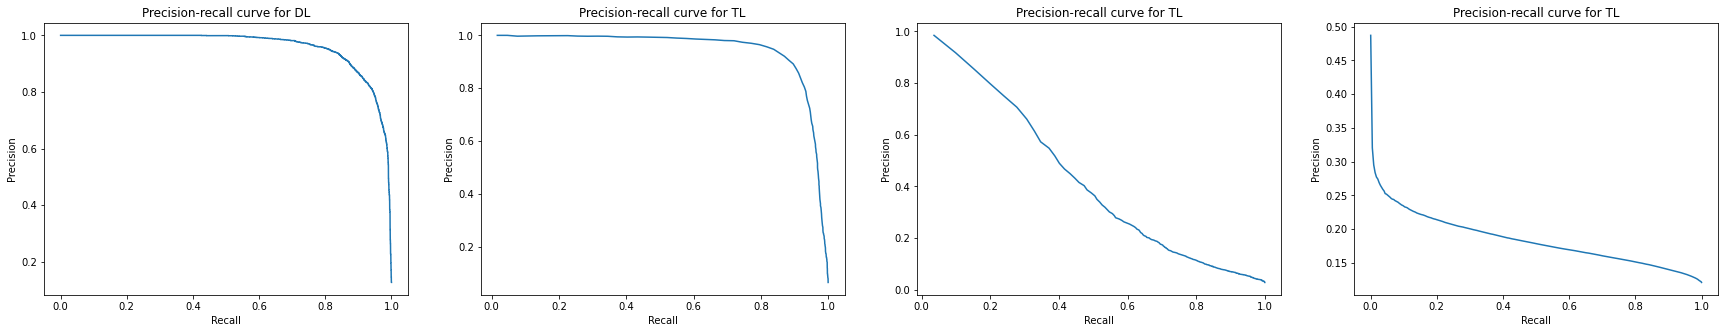

In [226]:
"""Calculate and plot the Precision-Recall curve for this system"""
figure, axes = plt.subplots(1, 4, figsize=(30, 5))
metrics.plot_recall_precision(recall_dl, precision_dl, axes[0], title_add="DL")
metrics.plot_recall_precision(recall_TL, precision_TL, axes[1], title_add="TL")
metrics.plot_recall_precision(recall_TL_att, precision_TL_att, axes[2], title_add="TL")
metrics.plot_recall_precision(recall_TL_lfw, precision_TL_lfw, axes[3], title_add="TL")

In [227]:
"""Calculate the average precision scores"""
average_prec_score_TL = average_precision_score(y_true=score_TL, y_score=y_true_TL)
average_prec_score_TL_att = average_precision_score(y_true=score_TL_att, y_score=y_true_TL_att)
average_prec_score_TL_lfw = average_precision_score(y_true=score_TL_lfw, y_score=y_true_TL_lfw)
print('Average precision score for DL', average_prec_score_dl)
print('Average precision score for TL', average_prec_score_TL)
print('Average precision score for TL', average_prec_score_TL_att)
print('Average precision score for TL', average_prec_score_TL_lfw)

Average precision score for DL 0.960075541799788
Average precision score for TL 0.9466999895112896
Average precision score for TL 0.43733662574619964
Average precision score for TL 0.18433954989120285


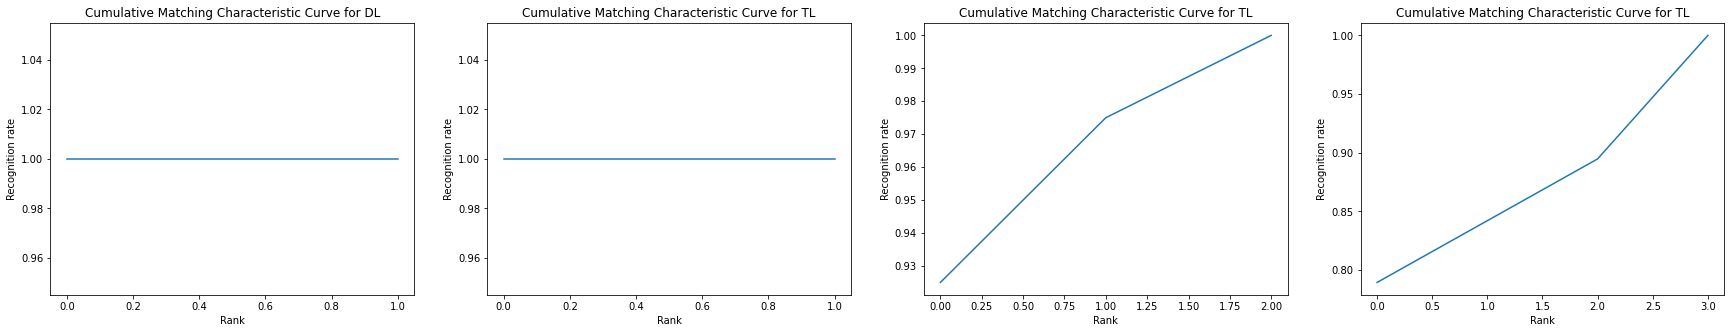

In [193]:
ranked_TL = metrics.compute_cmc(face_mat_TL)
ranked_TL_att = metrics.compute_cmc(face_mat_TL_att)
ranked_TL_lfw = metrics.compute_cmc(face_mat_TL_lfw)
figure, axes = plt.subplots(1, 4, figsize=(30, 5))
metrics.plot_cmc(ranked_dl, axes[0], "DL")
metrics.plot_cmc(ranked_TL, axes[1], "TL")
metrics.plot_cmc(ranked_TL_att, axes[2], "TL")
metrics.plot_cmc(ranked_TL_lfw, axes[3], "TL")

#### 2.6 Implement a different deep learning model* (2pt.)

In [53]:
# size of each face after preprocessing
face_size_nn=224

In [54]:
feat_data_nn, images_nn, labels_nn = [], [], []

for img, label in zip(data['images'], data['target']):
    faces = faceCascade.detectMultiScale(
        img,
        scaleFactor = 1.2,
        minNeighbors = 9,
        minSize = (30, 30),
        flags = cv2.CASCADE_SCALE_IMAGE
    )

    # iterate faces found in image
    for (x, y, w, h) in faces:
        new_img = img.copy()

        # extract ROI
        raw_face = new_img[y:y+h, x:x+w]

        # resize the face to the preferred size
        face = cv2.resize(raw_face, (face_size_nn, face_size_nn))
        face_flatten = face.flatten()

        images_nn.append(np.expand_dims(face, axis=-1)), feat_data_nn.append(face_flatten), labels_nn.append(label)

# encode classes as integer value
label_encoder = LabelEncoder()
targets_nn = label_encoder.fit_transform(labels)

faces_nn = Bunch(data       = np.array(feat_data_nn),
              images     = np.array(images_nn),
              labels     = np.array(labels_nn),
              target     = np.array(targets_nn))

for key in faces_nn.keys():
    print(faces_nn[key][0:2])

[[181 165 153 ...  74  76  84]
 [125 118 105 ...  28  32  50]]
[[[[181]
   [165]
   [153]
   ...
   [ 81]
   [ 84]
   [ 83]]

  [[193]
   [174]
   [156]
   ...
   [ 86]
   [ 82]
   [ 84]]

  [[182]
   [164]
   [117]
   ...
   [ 80]
   [ 81]
   [ 81]]

  ...

  [[113]
   [ 98]
   [ 81]
   ...
   [ 82]
   [ 83]
   [ 87]]

  [[ 93]
   [ 94]
   [ 95]
   ...
   [ 85]
   [ 74]
   [ 77]]

  [[ 93]
   [101]
   [ 83]
   ...
   [ 74]
   [ 76]
   [ 84]]]


 [[[125]
   [118]
   [105]
   ...
   [ 42]
   [ 35]
   [ 38]]

  [[128]
   [118]
   [110]
   ...
   [ 27]
   [ 22]
   [ 23]]

  [[128]
   [117]
   [109]
   ...
   [ 25]
   [ 22]
   [ 21]]

  ...

  [[ 53]
   [ 57]
   [109]
   ...
   [ 47]
   [ 83]
   [108]]

  [[ 50]
   [ 55]
   [ 99]
   ...
   [ 34]
   [ 57]
   [ 84]]

  [[ 62]
   [ 59]
   [101]
   ...
   [ 28]
   [ 32]
   [ 50]]]]
['person_001' 'person_001']
[0 0]


In [158]:
faces_nn_lfw = fetch_lfw_people(data_home='data', min_faces_per_person=40, slice_=(slice(70, 195), slice(70, 195)))
# Convert grayscale to RGB dimension
faces_nn_lfw.images = np.expand_dims(faces_nn_lfw.images, axis=-1)
print("LFW keys: ", faces_nn_lfw.keys())
print("LFW image shape", faces_nn_lfw.images.shape)
# for key in lfw_faces.keys():
#     print(lfw_faces[key][0:1])
labels_nn_lfw = []
for target in faces_nn_lfw.target:
    labels_nn_lfw.append(faces_nn_lfw.target_names[target])
print(type(faces_nn_lfw.images))

LFW keys:  dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])
LFW image shape (1867, 62, 62, 1)
<class 'numpy.ndarray'>


In [56]:
# from skimage.transform import resize
# images_nn_lfw = []

# for img in faces_nn_lfw['images']:
#     # resize the face to the preferred size
#     face = resize(img, (face_size_nn, face_size_nn))
#     images_nn_lfw.append(face)

# faces_nn_lfw['images'] = np.array(images_nn_lfw)

# faces_nn_lfw.images.shape

In [159]:
lfw_imshape_nn, n_samples_lfw_nn, n_classes_lfw_nn, n_features_lfw_nn = utils.get_image_db_statistic(faces_nn_lfw)

Total dataset size:
n_samples: 1867
n_classes: 19
n_features: 3844
imshape : (62, 62, 1)


In [58]:
x_train_nn, x_test_nn, y_train_nn, y_test_nn = holdout_split(faces_nn.images, faces_nn.target)
x_train_nn = np.array([cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB) for gray in x_train_nn])
x_test_nn = np.array([cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB) for gray in x_test_nn])
images_nn = np.array([cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB) for gray in faces_nn.images])

In [160]:
x_train_nn_lfw, x_test_nn_lfw, y_train_nn_lfw, y_test_nn_lfw = holdout_split(faces_nn_lfw.images, faces_nn_lfw.target)
x_train_nn_lfw = np.array([cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB) for gray in x_train_nn_lfw])
x_test_nn_lfw = np.array([cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB) for gray in x_test_nn_lfw])
images_nn_lfw = np.array([cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB) for gray in faces_nn_lfw.images])

In [60]:
data_processor = DataPreProcessor(images_train_x=x_train_nn, images_train_y=y_train_nn, images_test_x=x_test_nn, images_test_y=y_test_nn, batch_size=16, n_classes=n_classes)
train_set = data_processor.get_train_set
val_set = data_processor.get_val_set
test_set = data_processor.get_test_set

In [161]:
data_processor_lfw = DataPreProcessor(images_train_x=x_train_nn_lfw, images_train_y=y_train_nn_lfw, images_test_x=x_test_nn_lfw, images_test_y=y_test_nn_lfw, batch_size=16, n_classes=n_classes_lfw_nn)
train_set_lfw = data_processor_lfw.get_train_set
val_set_lfw = data_processor_lfw.get_val_set
test_set_lfw = data_processor_lfw.get_test_set

In [62]:
train_set.x[0].shape

(224, 224, 3)

In [162]:
train_set_lfw.x[0].shape

(62, 62, 3)

In [64]:
# !pip install keras_vggface
# !pip install keras_applications --no-deps
filename="C:/Users/harol/miniconda3/envs/biometrics37/Lib/site-packages/keras_vggface/models.py"
# filename = "/opt/conda/lib/python3.7/site-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))

20951

In [65]:
from src.neuralnetwork import ClassificationModel, TransferModels

In [66]:
# adam, rmsprop, nadam,
model_dashboard = ClassificationModel(optimiser='rmsprop', input_size=(face_size_nn, face_size_nn, 3), n_classes=data_processor.n_classes)
model_choice = 'vgg16_resnet'
model_dashboard.compute_model(transfer_model=TransferModels.resnet50_vggface, pretrained=True, vggface=True)

ic| len(tf_model.layers): 175


Model: "vggface_resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)                         )                                                  

In [67]:
# model_dashboard.fit(train_set, val_set, model_choice=model_choice, epochs=100)
model_dashboard.load_model('best_weights_67-0.06.hdf5', model_choice)

[+] Model loaded from vgg16_resnet/best_weights_67-0.06.hdf5


In [68]:
model_vgg = model_dashboard.get_model
print(model_vgg.summary())
vgg_face_descriptor = Model(inputs=model_vgg.layers[0].input
, outputs=model_vgg.layers[-2].output)
vgg_face_descriptor.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)                         )                                                           

In [69]:
embedded_nn = vgg_face_descriptor(images_nn).numpy()
dist_metric_nn = euclidean

In [70]:
df_scores_nn, similarity_mat_nn = utils.compute_similarity_matrix(embedded_nn, dist_metric_nn, labels_nn)

face_mat_nn = df_scores_nn.pivot_table(index='p1', columns='p2',values='scores_norm',aggfunc = np.average)

genuine_df_nn = df_scores_nn['scores_norm'][df_scores_nn['genuine'] == 1]
imposter_df_nn = df_scores_nn['scores_norm'][df_scores_nn['genuine'] == 0]

100%|███████████████████████████████████████████████████████████████████████████████| 440/440 [00:01<00:00, 270.34it/s]


In [163]:
# adam, rmsprop, nadam,
model_dashboard_lfw = ClassificationModel(optimiser='rmsprop', input_size=(train_set_lfw.x[0].shape), n_classes=data_processor_lfw.n_classes)
model_choice_lfw = 'vgg16_vgg_lfw'
model_dashboard_lfw.compute_model(transfer_model=TransferModels.vgg16_vggface, pretrained=True, vggface=True)
model_dashboard_lfw.fit(train_set_lfw, val_set_lfw, model_choice=model_choice_lfw, epochs=100)

ic| len(tf_model.layers): 20


Model: "vggface_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 62, 62, 3)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 62, 62, 64)        1792      
                                                                 
 conv1_2 (Conv2D)            (None, 62, 62, 64)        36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 31, 31, 64)        0         
                                                                 
 conv2_1 (Conv2D)            (None, 31, 31, 128)       73856     
                                                                 
 conv2_2 (Conv2D)            (None, 31, 31, 128)       147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 15, 15, 128)     

In [164]:
# model_dashboard_lfw.load_model('best_weights_49-0.29.hdf5', model_choice_lfw)

In [165]:
model_vgg_lfw = model_dashboard_lfw.get_model
print(model_vgg_lfw.summary())
vgg_face_descriptor_lfw = Model(inputs=model_vgg_lfw.layers[0].input
, outputs=model_vgg_lfw.layers[-2].output)
vgg_face_descriptor_lfw.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 62, 62, 3)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 62, 62, 64)        1792      
                                                                 
 conv1_2 (Conv2D)            (None, 62, 62, 64)        36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 31, 31, 64)        0         
                                                                 
 conv2_1 (Conv2D)            (None, 31, 31, 128)       73856     
                                                                 
 conv2_2 (Conv2D)            (None, 31, 31, 128)       147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 15, 15, 128)       0  

In [166]:
embedded_nn_lfw = vgg_face_descriptor_lfw(images_nn_lfw).numpy()
dist_metric_nn_lfw = euclidean

In [167]:
df_scores_nn_lfw, similarity_mat_nn_lfw = utils.compute_similarity_matrix(embedded_nn_lfw, dist_metric_nn_lfw, labels_nn_lfw)

face_mat_nn_lfw = df_scores_nn_lfw.pivot_table(index='p1', columns='p2',values='scores_norm',aggfunc = np.average)

genuine_df_nn_lfw = df_scores_nn_lfw['scores_norm'][df_scores_nn_lfw['genuine'] == 1]
imposter_df_nn_lfw = df_scores_nn_lfw['scores_norm'][df_scores_nn_lfw['genuine'] == 0]

100%|██████████████████████████████████████████████████████████████████████████████| 1867/1867 [00:29<00:00, 62.57it/s]


2022-05-28 15:31:57,673 - Computing precision recall
2022-05-28 15:31:57,706 - Computing accuracy
2022-05-28 15:32:03,583 - Generate dataframe
2022-05-28 15:32:03,594 - Computing precision recall
2022-05-28 15:32:04,273 - Computing accuracy
2022-05-28 15:32:05,473 - Generate dataframe


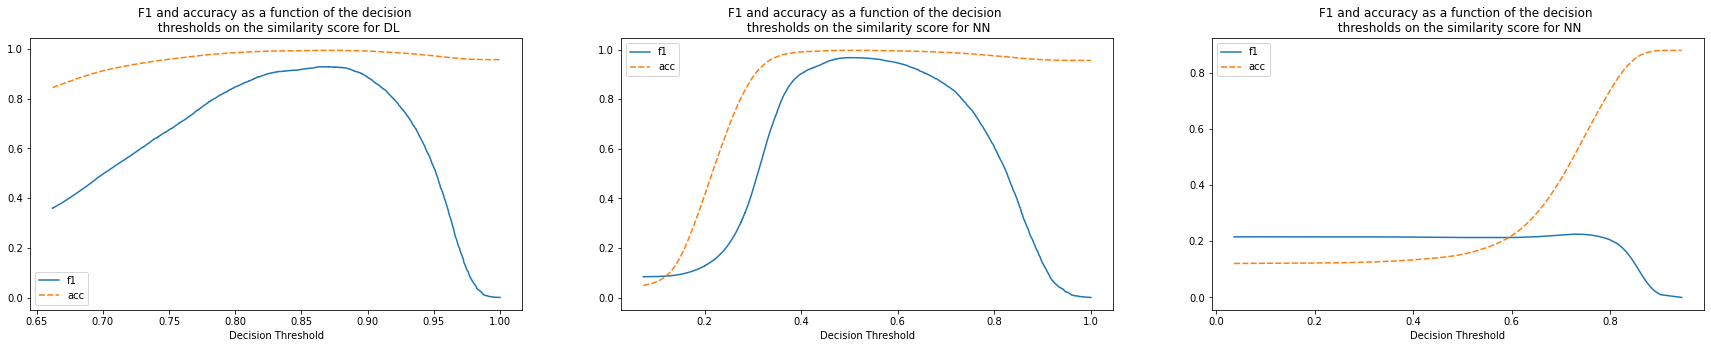

In [168]:
score_nn, y_true_nn = df_scores_nn['genuine'], df_scores_nn['scores_norm']
score_nn_lfw, y_true_nn_lfw = df_scores_nn_lfw['genuine'], df_scores_nn_lfw['scores_norm']
df_classification_metrics_nn, precision_nn, recall_nn = metrics.get_f1_and_acc_dataframe(genuine_df_nn, imposter_df_nn, score_nn, y_true_nn)
df_classification_metrics_nn_lfw, precision_nn_lfw, recall_nn_lfw = metrics.get_f1_and_acc_dataframe(genuine_df_nn_lfw, imposter_df_nn_lfw, score_nn_lfw, y_true_nn_lfw, slice=True)
figure, axes = plt.subplots(1, 3, figsize=(30, 5))
metrics.plot_decision_threshold_f1_acc(df_classification_metrics_dl, "DL", axes[0])
metrics.plot_decision_threshold_f1_acc(df_classification_metrics_nn, "NN", axes[1])
metrics.plot_decision_threshold_f1_acc(df_classification_metrics_nn_lfw, "NN", axes[2])

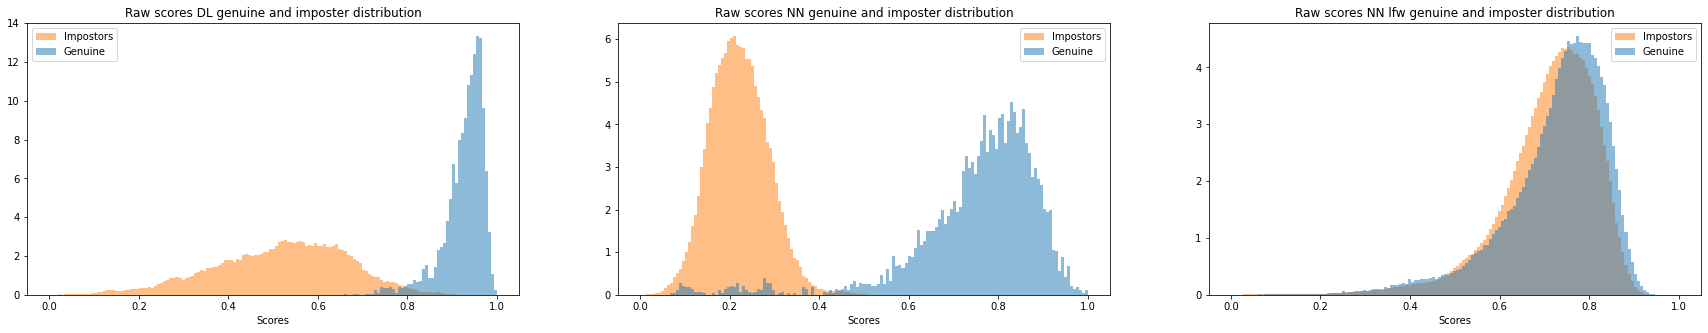

In [169]:
figure, axes = plt.subplots(1, 3, figsize=(30, 5))
metrics.plot_score_distribution(axes[0], imposter_df_dl, genuine_df_dl, "DL genuine and imposter distribution")
metrics.plot_score_distribution(axes[1], imposter_df_nn, genuine_df_nn, "NN genuine and imposter distribution")
metrics.plot_score_distribution(axes[2], imposter_df_nn_lfw, genuine_df_nn_lfw, "NN lfw genuine and imposter distribution")

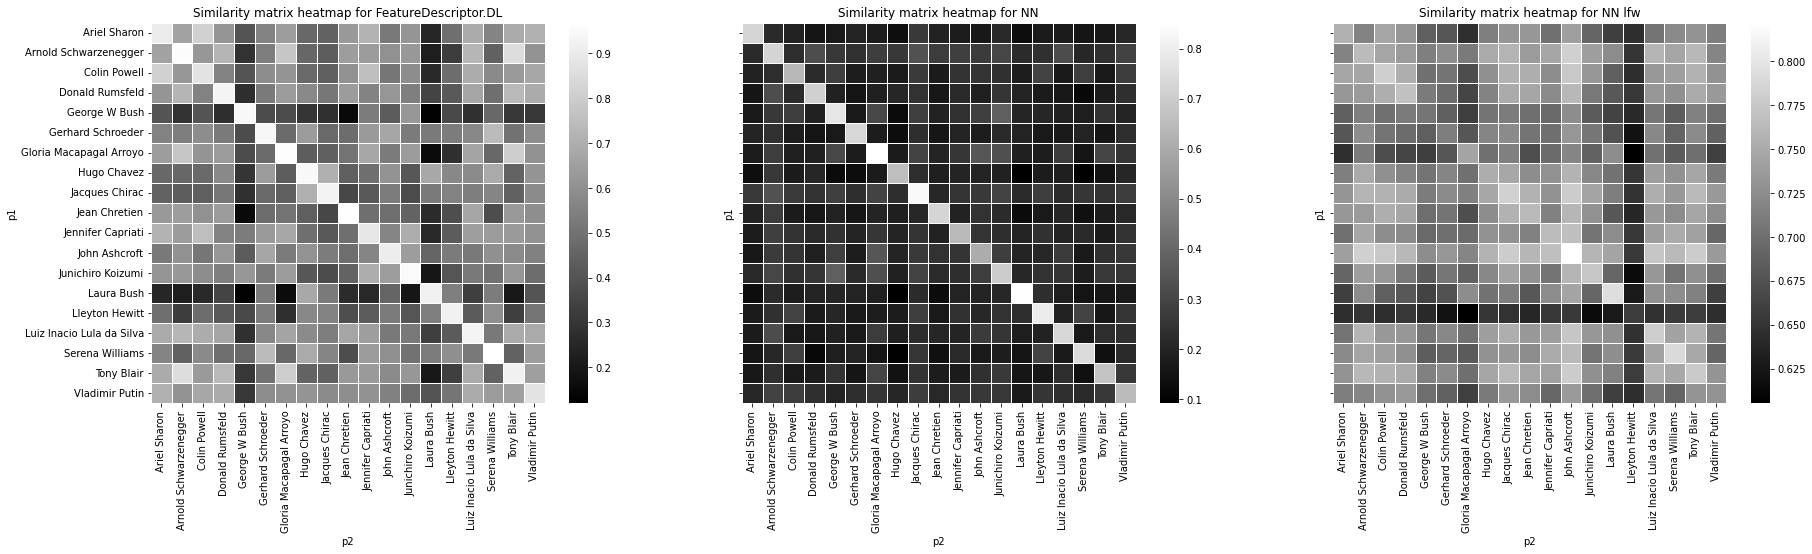

In [182]:
figure, axes = plt.subplots(1, 3, figsize=(30, 7), sharex=True, sharey=True)
metrics.plot_sim_matrix(face_mat_dl, axes[0], FeatureDescriptor.DL)
metrics.plot_sim_matrix(face_mat_nn, axes[1], "NN")
metrics.plot_sim_matrix(face_mat_nn_lfw, axes[2], "NN lfw")

In [171]:
fpr_roc_nn, fnr_roc_nn, tpr_roc_nn, threshold_roc_nn = metrics.compute_fpr_fnr_tpr_from_roc_curve(score_nn, y_true_nn)
fpr_roc_nn_lfw, fnr_roc_nn_lfw, tpr_roc_nn_lfw, threshold_roc_nn_lfw = metrics.compute_fpr_fnr_tpr_from_roc_curve(score_nn_lfw, y_true_nn_lfw)
roc_au_nn = roc_auc_score(y_true=score_nn, y_score=y_true_nn)
roc_au_nn_lfw = roc_auc_score(y_true=score_nn_lfw, y_score=y_true_nn_lfw)
print('ROC score for DL : ', roc_au_dl)
print('ROC score for NN : ', roc_au_nn)
print('ROC score for NN : ', roc_au_nn_lfw)

2022-05-28 15:32:16,950 - Computing roc curve
2022-05-28 15:32:16,981 - End roc curve computation
2022-05-28 15:32:16,982 - Computing roc curve
2022-05-28 15:32:17,746 - End roc curve computation


ROC score for DL :  0.9985069701862566
ROC score for NN :  0.9827822256200343
ROC score for NN :  0.5558486740038658


In [172]:
eer_threshold_roc_nn = threshold_roc_nn[np.nanargmin(np.absolute((fnr_roc_nn - fpr_roc_nn)))]
eer_threshold_roc_nn_lfw = threshold_roc_nn_lfw[np.nanargmin(np.absolute((fnr_roc_nn_lfw - fpr_roc_nn_lfw)))]
print('EER threshold for DL : ', eer_threshold_roc_dl)
print('EER threshold for NN : ', eer_threshold_roc_nn)
print('EER threshold for NN lfw : ', eer_threshold_roc_nn_lfw)

EER threshold for DL :  0.7868242612282494
EER threshold for NN :  0.3464176267198203
EER threshold for NN lfw :  0.7392505762343625


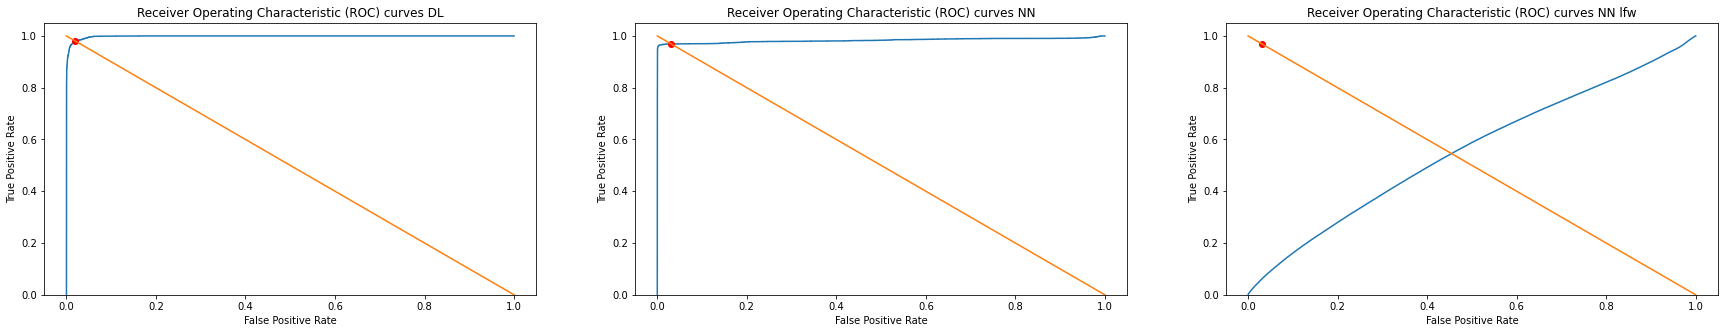

In [173]:
df_decision_threshold_fpr_fnr_nn = metrics.generate_dataframe(columns=['fpr', 'fnr', 'tpr'], data_list=[fpr_roc_nn, fnr_roc_nn, tpr_roc_nn], index_values=threshold_roc_nn)
df_decision_threshold_fpr_fnr_nn_lfw = metrics.generate_dataframe(columns=['fpr', 'fnr', 'tpr'], data_list=[fpr_roc_nn_lfw, fnr_roc_nn_lfw, tpr_roc_nn_lfw], index_values=threshold_roc_nn_lfw)
result_roc_nn = df_decision_threshold_fpr_fnr_nn.loc[eer_threshold_roc_nn]
result_roc_nn_lfw = df_decision_threshold_fpr_fnr_nn_lfw.loc[eer_threshold_roc_nn_lfw]
figure, axes = plt.subplots(1, 3, figsize=(30, 5))
metrics.plot_eer_roc(fpr_roc_dl, tpr_roc_dl, axes[0], result_roc_dl, "DL")
metrics.plot_eer_roc(fpr_roc_nn, tpr_roc_nn, axes[1], result_roc_nn, "NN")
metrics.plot_eer_roc(fpr_roc_nn_lfw, tpr_roc_nn_lfw, axes[2], result_roc_nn, "NN lfw")

In [174]:
"""Calculate the decision threshold for which the sum of FRR and FAR is minimal."""
df_decision_threshold_fpr_fnr_nn["sum"] = df_decision_threshold_fpr_fnr_nn[['fnr', 'fpr']].sum(axis=1)
df_decision_threshold_fpr_fnr_nn_lfw["sum"] = df_decision_threshold_fpr_fnr_nn_lfw[['fnr', 'fpr']].sum(axis=1)

print('Decision threshold where sum of frr and far are minimal')
print('threshold for DL', df_decision_threshold_fpr_fnr_dl["sum"].idxmin())
print('threshold for NN', df_decision_threshold_fpr_fnr_nn["sum"].idxmin())
print('threshold for NN lfw', df_decision_threshold_fpr_fnr_nn_lfw["sum"].idxmin())

Decision threshold where sum of frr and far are minimal
threshold for DL 0.791767176066947
threshold for NN 0.4347897282580902
threshold for NN lfw 0.7523709214381785


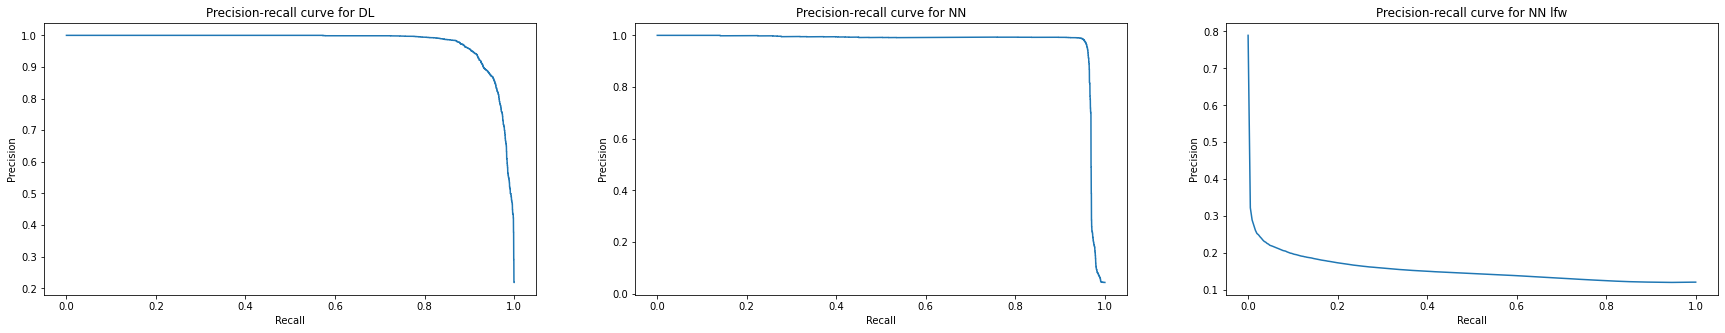

In [175]:
"""Calculate and plot the Precision-Recall curve for this system"""
figure, axes = plt.subplots(1, 3, figsize=(30, 5))
metrics.plot_recall_precision(recall_dl, precision_dl, axes[0], title_add="DL")
metrics.plot_recall_precision(recall_nn, precision_nn, axes[1], title_add="NN")
metrics.plot_recall_precision(recall_nn_lfw, precision_nn_lfw, axes[2], title_add="NN lfw")

In [176]:
"""Calculate the average precision scores"""
average_prec_score_nn = average_precision_score(y_true=score_nn, y_score=y_true_nn)
average_prec_score_nn_lfw = average_precision_score(y_true=score_nn_lfw, y_score=y_true_nn_lfw)
print('Average precision score for DL', average_prec_score_dl)
print('Average precision score for NN', average_prec_score_nn)
print('Average precision score for NN lfw', average_prec_score_nn_lfw)

Average precision score for DL 0.9783628694945233
Average precision score for NN 0.9659801215554832
Average precision score for NN lfw 0.15367826521728847


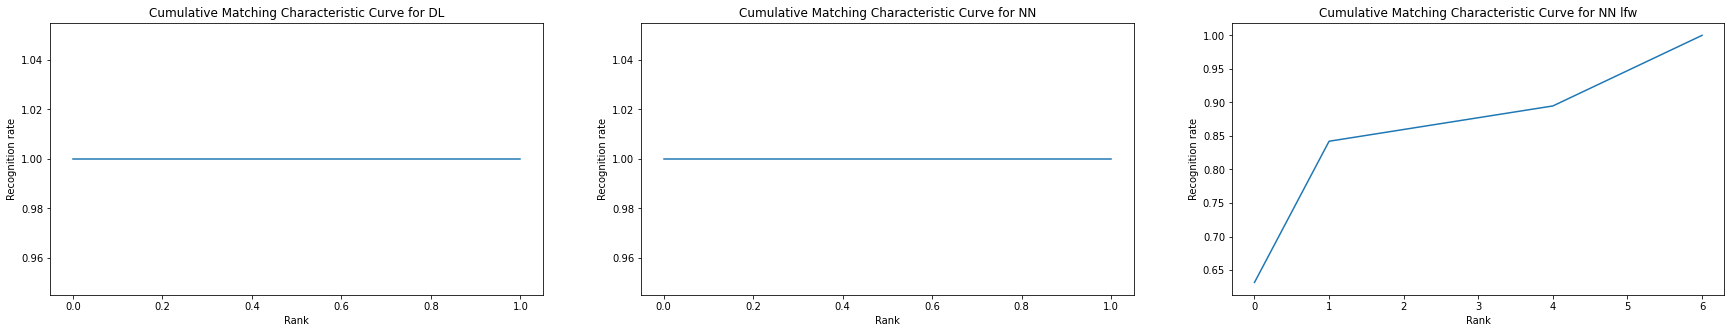

In [183]:
ranked_nn = metrics.compute_cmc(face_mat_nn)
ranked_nn_lfw = metrics.compute_cmc(face_mat_nn_lfw)
figure, axes = plt.subplots(1, 3, figsize=(30, 5))
metrics.plot_cmc(ranked_dl, axes[0], "DL")
metrics.plot_cmc(ranked_nn, axes[1], "NN")
metrics.plot_cmc(ranked_nn_lfw, axes[2], "NN lfw")

## Fine tuning
doesn't improve the model

In [178]:
# model_tf = model_dashboard.get_model
# model_tf = model_dashboard.activate_training_layers(model_tf, 18)
# model_dashboard.set_model(model_tf)
# model_dashboard.compile_model(opt=Adam(1e-5)) ## slow learning

In [179]:
# model_dashboard.fit(train_set, val_set, model_choice=model_choice, epochs=30, fine_tuning=True)

In [180]:
# model_dashboard.plot_accuracy_and_loss_plt()